In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# -----------------------
# Baseline hyperparameters
# -----------------------
lr = 0.001
layers = [3,128,128,128,1]
activation = "tanh"
epochs = 500
seed = 42
pde_weight_min = 1e-6
pde_weight_max = 0.05
pde_ramp_power = 2.0
use_log = True

torch.manual_seed(seed)
np.random.seed(seed)

# -----------------------
# Load data
# -----------------------
with open("data/devpos.json","r") as f:
    sensor_positions = json.load(f)
data = pd.read_csv("data/dfdevc.csv")
records = []
for sensor,pos in sensor_positions.items():
    x,z = pos
    for idx,row in data.iterrows():
        t = row["Time"]
        T = row[sensor]
        records.append([sensor,x,z,t,T])
df_full = pd.DataFrame(records,columns=["sensor","x","z","t","T"])


In [ ]:
# -----------------------
# PINN
# -----------------------
class PINN(nn.Module):
    def __init__(self,layers,activation="tanh"):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i],layers[i+1]))
        self.act = nn.Tanh() if activation=="tanh" else nn.SiLU()
    def forward(self,x):
        out = x
        for layer in self.layers[:-1]:
            out = self.act(layer(out))
        return self.layers[-1](out)

# -----------------------
# PDE residual
# -----------------------
def pde_residual(model, xyz, alpha):
    xyz.requires_grad_(True)
    T_pred = model(xyz)
    grads = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred),
                                retain_graph=True, create_graph=True)[0]
    T_x = grads[:,0:1]; T_z = grads[:,1:2]; T_t = grads[:,2:3]
    T_xx = torch.autograd.grad(T_x, xyz, grad_outputs=torch.ones_like(T_x),
                               retain_graph=True, create_graph=True)[0][:,0:1]
    T_zz = torch.autograd.grad(T_z, xyz, grad_outputs=torch.ones_like(T_z),
                               retain_graph=True, create_graph=True)[0][:,1:2]
    return T_t - alpha*(T_xx + T_zz)

In [ ]:
# -----------------------
# Prepare data
# -----------------------
def prepare_data(df,use_log=True):
    df = df.copy()
    if use_log:
        df["T_scaled"] = np.log1p(df["T"])
    else:
        df["T_scaled"] = df["T"]
    df["x_norm"] = (df["x"] - df["x"].min())/(df["x"].max()-df["x"].min())
    df["z_norm"] = (df["z"] - df["z"].min())/(df["z"].max()-df["z"].min())
    df["t_norm"] = df["t"]/df["t"].max()
    X = torch.tensor(df[["x_norm","z_norm","t_norm"]].values,dtype=torch.float32)
    T = torch.tensor(df[["T_scaled"]].values,dtype=torch.float32)
    return X,T,df

# -----------------------
# PDE weight schedule
# -----------------------
def pde_weight_schedule(epoch, epochs, wmin, wmax, power):
    frac = (epoch/epochs)**power
    return wmin + (wmax - wmin) * frac

# -----------------------
# Adaptive per-sensor weighting
# -----------------------
def get_weights(df):
    sensor_counts = df.groupby("sensor").size()
    weights = {s:1.0/len(sensor_counts) for s in sensor_counts.keys()}
    weights_tensor = torch.tensor(df["sensor"].map(weights).values,dtype=torch.float32).unsqueeze(1)
    return weights, weights_tensor


In [ ]:
# -----------------------
# Training function
# -----------------------
def train_model(model, X, T, df, epochs, alpha, w_data, w_pde):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    running_data = 0.0
    running_pde = 0.0
    ema_decay = 0.99
    sensor_weights, weights_tensor = get_weights(df)

    log = {"epoch":[],"data_loss":[],"pde_loss":[],"total_loss":[],"mean_residual":[],"pde_weight":[]}

    for epoch in range(epochs+1):
        optimizer.zero_grad()
        T_pred = model(X)

        # Adaptive per-sensor weighting update every 100 epochs
        if epoch % 100 == 0:
            with torch.no_grad():
                df["T_pred_tmp"] = T_pred.numpy()
                sensor_mse = {}
                for s in sensor_weights.keys():
                    s_data = df[df["sensor"]==s]
                    mse_s = ((s_data["T_scaled"]-s_data["T_pred_tmp"])**2).mean()
                    sensor_mse[s] = mse_s
                
                # Normalize weights based on MSE (higher MSE = higher weight)
                total_mse = sum(sensor_mse.values())
                if total_mse > 0:
                    sensor_weights = {k: 0.5 + v/total_mse for k,v in sensor_mse.items()}
                    total_weight = sum(sensor_weights.values())
                    sensor_weights = {k:v/total_weight for k,v in sensor_weights.items()}
                
                weights_tensor = torch.tensor(df["sensor"].map(sensor_weights).values,dtype=torch.float32).unsqueeze(1)

        data_loss = torch.mean(weights_tensor*(T_pred - T)**2)
        residual = pde_residual(model, X, alpha)
        pde_weight = pde_weight_schedule(epoch, epochs, pde_weight_min, pde_weight_max, pde_ramp_power)
        pde_loss = torch.mean(residual**2) * pde_weight

        # EMA normalization
        running_data = ema_decay*running_data + (1-ema_decay)*data_loss.item()
        running_pde  = ema_decay*running_pde  + (1-ema_decay)*pde_loss.item()
        total_loss = w_data*(data_loss/(running_data+1e-12)) + w_pde*(pde_loss/(running_pde+1e-12))

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        log["epoch"].append(epoch)
        log["data_loss"].append(data_loss.item())
        log["pde_loss"].append(pde_loss.item())
        log["total_loss"].append(total_loss.item())
        log["mean_residual"].append(residual.abs().mean().item())
        log["pde_weight"].append(pde_weight)

    return model, log


In [ ]:
# -----------------------
# Run hypertuning
# -----------------------
X,T,df = prepare_data(df_full, use_log)

# Stage A: alpha sweep
alpha_list = [0.5, 1.0, 2.0,1e-5,2e-5,1.2e-5,1.5e-5,1.9e-5]
alpha_logs = {}
best_alpha = None
best_rmse = float('inf')

for alpha_val in alpha_list:
    print(f"\n--- Training with alpha={alpha_val} ---")
    model = PINN(layers, activation)
    model, log = train_model(model, X, T, df, epochs, alpha_val, w_data=1.0, w_pde=1e-3)
    alpha_logs[alpha_val] = log
    
    # Evaluate model for current alpha
    model.eval()
    with torch.no_grad():
        T_pred_scaled = model(X).numpy()
        if use_log:
            T_pred = np.expm1(T_pred_scaled)
        else:
            T_pred = T_pred_scaled
        df["T_pred"] = T_pred

    # Compute per-sensor RMSE
    sensor_rmse = {}
    all_errors = []
    for s in df["sensor"].unique():
        s_data = df[df["sensor"]==s]
        errors = s_data["T"] - s_data["T_pred"]
        sensor_rmse[s] = np.sqrt((errors**2).mean())
        all_errors.extend(errors.tolist())
    total_rmse = np.sqrt(np.mean(np.array(all_errors)**2))

    print(f"Alpha={alpha_val} | Total RMSE={total_rmse:.3f}")
    for s,rmse in sensor_rmse.items():
        print(f"{s}: RMSE={rmse:.3f}")
    
    # Track best alpha
    if total_rmse < best_rmse:
        best_rmse = total_rmse
        best_alpha = alpha_val

print(f"\nBest alpha: {best_alpha} with RMSE: {best_rmse:.3f}")


In [ ]:
# Plot actual vs predicted for 9 sensors
plt.figure(figsize=(12,8))
for i,sensor in enumerate(df["sensor"].unique()):
    x_s, z_s = sensor_positions[sensor]
    s_data = df[(df["x"]==x_s)&(df["z"]==z_s)]
    plt.subplot(3,3,i+1)
    plt.plot(s_data["t"], s_data["T"], 'o-', label="Actual")
    plt.plot(s_data["t"], s_data["T_pred"], 'x--', label="Predicted")
    plt.title(sensor)
    plt.xlabel("Time")
    plt.ylabel("Temp")
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5000

# Weight for physics vs data
pde_weight_schedule = lambda epoch: min(0.1 + 0.9*(epoch/epochs), 1.0)  # gradually increase

# Initialize loss tracking lists
data_losses = []
pde_losses = []
total_losses = []
epochs_list = []

for epoch in range(epochs+1):
    optimizer.zero_grad()

    # Forward pass
    T_pred = model(X_data)

    # Weighted data loss (optional sqrt transform)
    weights = 1 + (T_data / T_data.max())
    data_loss = torch.mean(weights * (T_pred - T_data)**2)

    # PDE residual loss
    residual = pde_residual(X_data)
    pde_weight = pde_weight_schedule(epoch)
    pde_loss = pde_weight * torch.mean(residual**2)

    loss = data_loss + pde_loss
    loss.backward()
    optimizer.step()

    # Store loss values for plotting
    data_losses.append(data_loss.item())
    pde_losses.append(pde_loss.item())
    total_losses.append(loss.item())
    epochs_list.append(epoch)

    if epoch % 500 == 0:
        mse = torch.mean((T_pred - T_data)**2).item()
        rmse = np.sqrt(mse)
        print(f"Epoch {epoch} | Data Loss: {data_loss.item():.4f} | PDE Loss: {pde_loss.item():.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f}")


Epoch 0 | Data Loss: 0.2143 | PDE Loss: 0.0002 | MSE: 0.1242 | RMSE: 0.3525
Epoch 500 | Data Loss: 0.0205 | PDE Loss: 0.0106 | MSE: 0.0166 | RMSE: 0.1287
Epoch 1000 | Data Loss: 0.0087 | PDE Loss: 0.0003 | MSE: 0.0075 | RMSE: 0.0866
Epoch 1500 | Data Loss: 0.0063 | PDE Loss: 0.0002 | MSE: 0.0055 | RMSE: 0.0739
Epoch 2000 | Data Loss: 0.0036 | PDE Loss: 0.0001 | MSE: 0.0030 | RMSE: 0.0548
Epoch 2500 | Data Loss: 0.0027 | PDE Loss: 0.0000 | MSE: 0.0021 | RMSE: 0.0463
Epoch 3000 | Data Loss: 0.0029 | PDE Loss: 0.0005 | MSE: 0.0024 | RMSE: 0.0489
Epoch 3500 | Data Loss: 0.0022 | PDE Loss: 0.0000 | MSE: 0.0018 | RMSE: 0.0421
Epoch 4000 | Data Loss: 0.0024 | PDE Loss: 0.0026 | MSE: 0.0019 | RMSE: 0.0437
Epoch 4500 | Data Loss: 0.0022 | PDE Loss: 0.0014 | MSE: 0.0018 | RMSE: 0.0425
Epoch 5000 | Data Loss: 0.0021 | PDE Loss: 0.0006 | MSE: 0.0017 | RMSE: 0.0415


In [39]:
model.eval()
with torch.no_grad():
    T_pred_norm = model(X_data).numpy()
    T_pred = T_pred_norm * (T_max - T_min) + T_min
    long_data["T_pred"] = T_pred


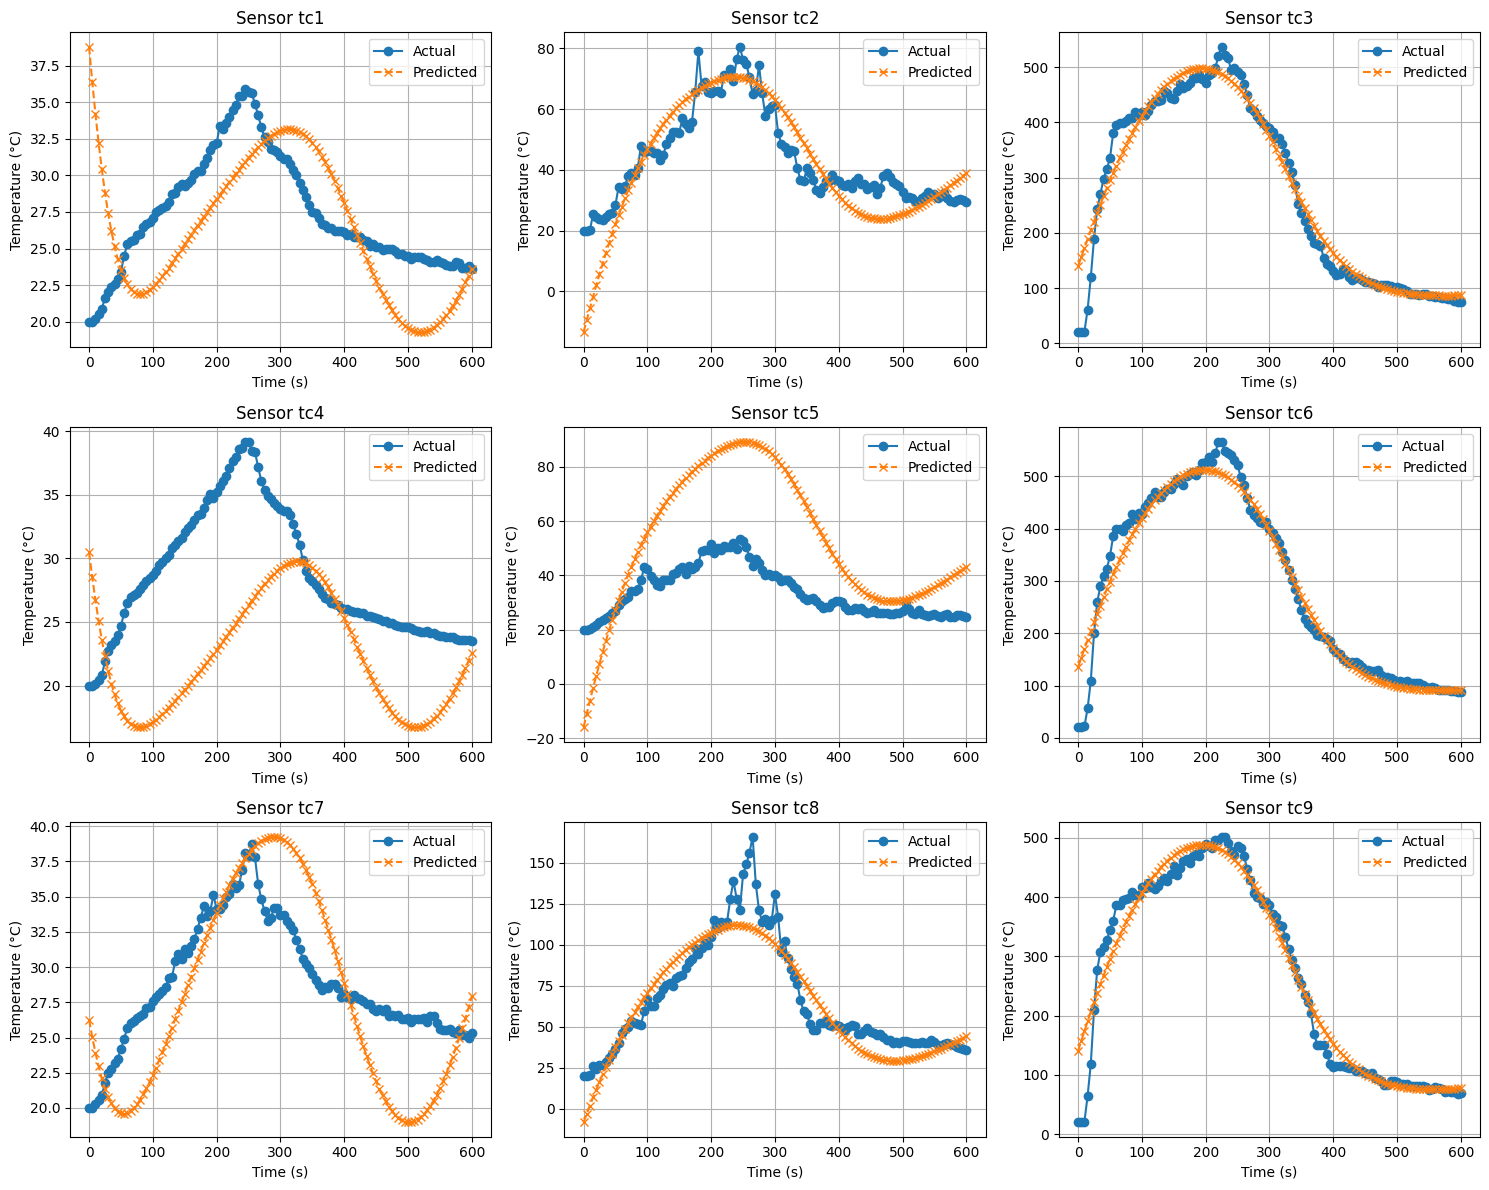

In [40]:
plt.figure(figsize=(15,12))
sensors = list(sensor_positions.keys())

for i, sensor in enumerate(sensors):
    plt.subplot(3, 3, i+1)
    x_s, z_s = sensor_positions[sensor]
    sensor_data = long_data[(long_data["x"]==x_s) & (long_data["z"]==z_s)]
    plt.plot(sensor_data["t"], sensor_data["T"], 'o-', label="Actual")
    plt.plot(sensor_data["t"], sensor_data["T_pred"], 'x--', label="Predicted")
    plt.title(f"Sensor {sensor}")
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [41]:
for sensor in sensors:
    x_s, z_s = sensor_positions[sensor]
    sensor_data = long_data[(long_data["x"]==x_s) & (long_data["z"]==z_s)]
    mse = np.mean((sensor_data["T"] - sensor_data["T_pred"])**2)
    rmse = np.sqrt(mse)
    print(f"{sensor}: MSE={mse:.2f}, RMSE={rmse:.2f}")


tc1: MSE=21.84, RMSE=4.67
tc2: MSE=85.79, RMSE=9.26
tc3: MSE=1160.32, RMSE=34.06
tc4: MSE=67.62, RMSE=8.22
tc5: MSE=676.27, RMSE=26.01
tc6: MSE=1151.18, RMSE=33.93
tc7: MSE=20.22, RMSE=4.50
tc8: MSE=186.61, RMSE=13.66
tc9: MSE=1132.10, RMSE=33.65


In [46]:
# Method 1: Calculate overall RMSE from all data points
def calculate_overall_rmse(long_data, sensor_positions):
    """
    Calculate overall RMSE across all sensors combined
    """
    all_actual = []
    all_predicted = []
    
    for sensor, (x_s, z_s) in sensor_positions.items():
        sensor_data = long_data[(long_data["x"] == x_s) & (long_data["z"] == z_s)]
        all_actual.extend(sensor_data["T"].values)
        all_predicted.extend(sensor_data["T_pred"].values)
    
    all_actual = np.array(all_actual)
    all_predicted = np.array(all_predicted)
    
    mse_overall = np.mean((all_actual - all_predicted)**2)
    rmse_overall = np.sqrt(mse_overall)
    
    return mse_overall, rmse_overall

# Calculate overall RMSE
mse_total, rmse_total = calculate_overall_rmse(long_data, sensor_positions)
print(f"Overall MSE: {mse_total:.2f}")
print(f"Overall RMSE: {rmse_total:.2f}")

Overall MSE: 500.22
Overall RMSE: 22.37


Epoch 0 | Data Loss: 2.0009 | PDE Loss: 0.0000 | RMSE: 4.2436
Epoch 500 | Data Loss: 0.0214 | PDE Loss: 0.0010 | RMSE: 0.4387
Epoch 1000 | Data Loss: 0.0141 | PDE Loss: 0.0003 | RMSE: 0.3557
Epoch 1500 | Data Loss: 0.0086 | PDE Loss: 0.0001 | RMSE: 0.2788
Epoch 2000 | Data Loss: 0.0077 | PDE Loss: 0.0079 | RMSE: 0.2631
Epoch 2500 | Data Loss: 0.0058 | PDE Loss: 0.0000 | RMSE: 0.2281
Epoch 3000 | Data Loss: 0.0058 | PDE Loss: 0.0001 | RMSE: 0.2282
Epoch 3500 | Data Loss: 0.0052 | PDE Loss: 0.0066 | RMSE: 0.2170
Epoch 4000 | Data Loss: 0.0053 | PDE Loss: 0.0000 | RMSE: 0.2183
Epoch 4500 | Data Loss: 0.0053 | PDE Loss: 0.0000 | RMSE: 0.2183
Epoch 5000 | Data Loss: 0.0049 | PDE Loss: 0.0000 | RMSE: 0.2096


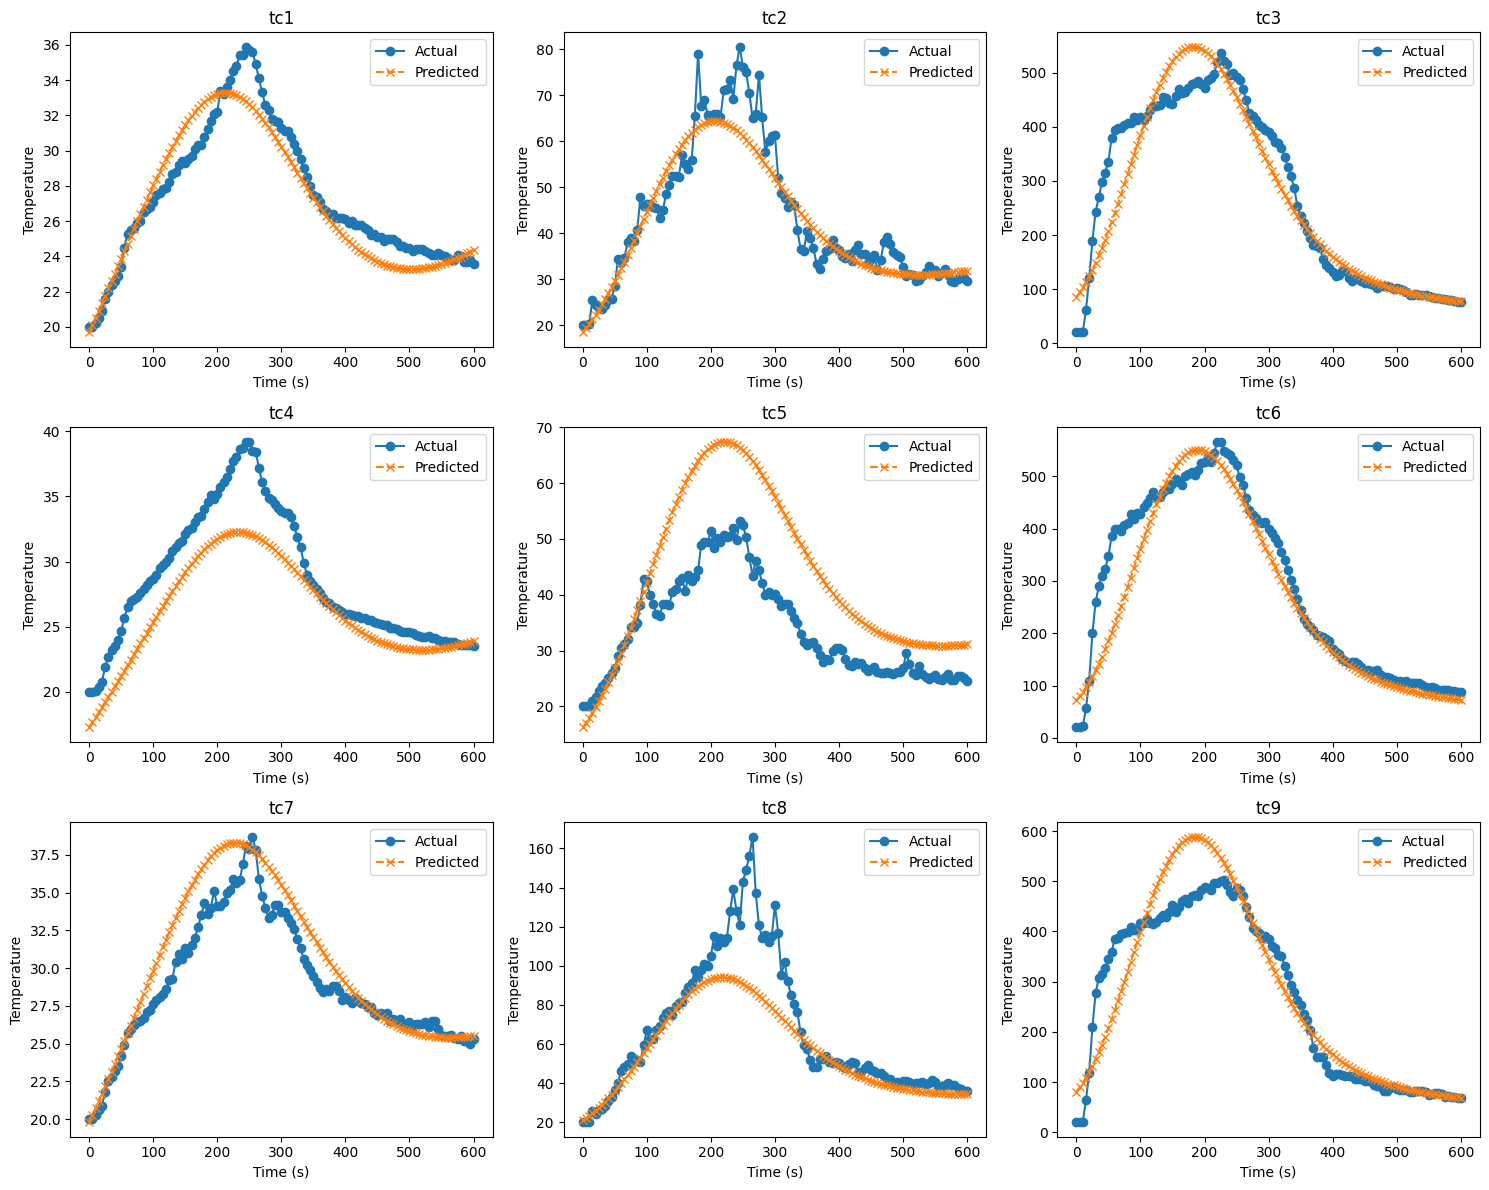

tc1: RMSE=1.26
tc2: RMSE=5.32
tc3: RMSE=52.86
tc4: RMSE=2.97
tc5: RMSE=11.74
tc6: RMSE=56.78
tc7: RMSE=1.91
tc8: RMSE=18.51
tc9: RMSE=62.06


In [48]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Config / Hyperparams
# -----------------------
CONFIG = {
    "data_csv": "data/dfdevc.csv",
    "sensor_json": "data/devpos.json",
    "layers": [3, 256, 256, 256, 1],  # slightly bigger network
    "activation": "tanh",             # tanh or silu
    "alpha": 1.0,                     # thermal diffusivity
    "lr": 1e-3,
    "epochs": 5000,
    "pde_weight_start": 0.05,         # start PDE weight low
    "pde_weight_max": 1.0,
    "seed": 42,
    "use_log_scale": True,             # log scaling for temperature
}

# -----------------------
# Reproducibility
# -----------------------
torch.manual_seed(CONFIG["seed"])
np.random.seed(CONFIG["seed"])

# -----------------------
# Load Data
# -----------------------
with open(CONFIG["sensor_json"], "r") as f:
    sensor_positions = json.load(f)

data = pd.read_csv(CONFIG["data_csv"])

records = []
for sensor, pos in sensor_positions.items():
    x, z = pos
    for idx, row in data.iterrows():
        t = row["Time"]
        T = row[sensor]
        records.append([sensor, x, z, t, T])
long_data = pd.DataFrame(records, columns=["sensor", "x", "z", "t", "T"])

# Apply log-scaling if chosen
if CONFIG["use_log_scale"]:
    long_data["T_scaled"] = np.log1p(long_data["T"])
else:
    long_data["T_scaled"] = long_data["T"]

# Normalize spatial and temporal coords
long_data["x_norm"] = (long_data["x"] - long_data["x"].min()) / (long_data["x"].max() - long_data["x"].min())
long_data["z_norm"] = (long_data["z"] - long_data["z"].min()) / (long_data["z"].max() - long_data["z"].min())
long_data["t_norm"] = long_data["t"] / long_data["t"].max()

# Convert to tensors
X_data = torch.tensor(long_data[["x_norm", "z_norm", "t_norm"]].values, dtype=torch.float32)
T_data = torch.tensor(long_data[["T_scaled"]].values, dtype=torch.float32)

# -----------------------
# Define PINN
# -----------------------
class PINN(nn.Module):
    def __init__(self, layers, activation="tanh"):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.act = nn.Tanh() if activation=="tanh" else nn.SiLU()

    def forward(self, x):
        out = x
        for layer in self.layers[:-1]:
            out = self.act(layer(out))
        return self.layers[-1](out)

model = PINN(CONFIG["layers"], CONFIG["activation"])

# -----------------------
# PDE Residual
# -----------------------
def pde_residual(xyz):
    xyz.requires_grad_(True)
    T_pred = model(xyz)
    T_t = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred), retain_graph=True, create_graph=True)[0][:,2:3]
    T_x = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred), retain_graph=True, create_graph=True)[0][:,0:1]
    T_xx = torch.autograd.grad(T_x, xyz, grad_outputs=torch.ones_like(T_x), retain_graph=True, create_graph=True)[0][:,0:1]
    T_z = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred), retain_graph=True, create_graph=True)[0][:,1:2]
    T_zz = torch.autograd.grad(T_z, xyz, grad_outputs=torch.ones_like(T_z), retain_graph=True, create_graph=True)[0][:,1:2]
    residual = T_t - CONFIG["alpha"]*(T_xx + T_zz)
    return residual

# -----------------------
# Sensor weights
# -----------------------
sensor_counts = long_data.groupby("sensor").size()
sensor_weights = {s: 1.0/len(sensor_counts) for s in sensor_counts.keys()}  # equal start
long_data["weight"] = long_data["sensor"].map(sensor_weights)
weights_tensor = torch.tensor(long_data["weight"].values, dtype=torch.float32).unsqueeze(1)

# -----------------------
# Training
# -----------------------
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG["lr"])

# Initialize sensor weights
sensor_counts = long_data.groupby("sensor").size()
sensor_weights = {s: 1.0/len(sensor_counts) for s in sensor_counts.keys()}

# Training loop with adaptive weighting
for epoch in range(CONFIG["epochs"]+1):
    optimizer.zero_grad()
    
    T_pred = model(X_data)
    
    # Update adaptive weights every 100 epochs
    if epoch % 100 == 0:
        with torch.no_grad():
            long_data["T_pred_tmp"] = T_pred.numpy()
            # Compute sensor-wise RMSE
            for s in sensor_weights.keys():
                s_data = long_data[long_data["sensor"]==s]
                mse_s = ((s_data["T_scaled"] - s_data["T_pred_tmp"])**2).mean()
                sensor_weights[s] = 0.5 + mse_s / mse_s.sum()  # weight proportional to RMSE
        # Normalize
        total = sum(sensor_weights.values())
        sensor_weights = {k:v/total for k,v in sensor_weights.items()}
        weights_tensor = torch.tensor(long_data["sensor"].map(sensor_weights).values, dtype=torch.float32).unsqueeze(1)

    # Weighted data loss
    data_loss = torch.mean(weights_tensor * (T_pred - T_data)**2)
    
    # PDE loss
    residual = pde_residual(X_data)
    pde_weight = CONFIG["pde_weight_start"] + (CONFIG["pde_weight_max"] - CONFIG["pde_weight_start"])*(epoch/CONFIG["epochs"])
    pde_loss = pde_weight * torch.mean(residual**2)
    
    loss = data_loss + pde_loss
    loss.backward()
    optimizer.step()
    
    if epoch % 500 == 0:
        mse = torch.mean((T_pred - T_data)**2).item()
        rmse = np.sqrt(mse)
        print(f"Epoch {epoch} | Data Loss: {data_loss.item():.4f} | PDE Loss: {pde_loss.item():.4f} | RMSE: {rmse:.4f}")


# -----------------------
# Evaluation
# -----------------------
model.eval()
with torch.no_grad():
    T_pred_scaled = model(X_data).numpy()
    # inverse-transform
    if CONFIG["use_log_scale"]:
        T_pred = np.expm1(T_pred_scaled)
    else:
        T_pred = T_pred_scaled
    long_data["T_pred"] = T_pred

# Plot
sensors = list(sensor_positions.keys())
plt.figure(figsize=(15,12))
for i, sensor in enumerate(sensors):
    plt.subplot(3,3,i+1)
    x_s, z_s = sensor_positions[sensor]
    s_data = long_data[(long_data["x"]==x_s)&(long_data["z"]==z_s)]
    plt.plot(s_data["t"], s_data["T"], 'o-', label="Actual")
    plt.plot(s_data["t"], s_data["T_pred"], 'x--', label="Predicted")
    plt.title(sensor)
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature")
    plt.legend()
plt.tight_layout()
plt.show()

# Print sensor-wise RMSE
for sensor in sensors:
    x_s, z_s = sensor_positions[sensor]
    s_data = long_data[(long_data["x"]==x_s)&(long_data["z"]==z_s)]
    mse = np.mean((s_data["T"]-s_data["T_pred"])**2)
    rmse = np.sqrt(mse)
    print(f"{sensor}: RMSE={rmse:.2f}")


In [2]:
import math
rmses = [1.26, 5.32, 52.86, 2.97, 11.74, 56.78, 1.91, 18.51, 62.06]
# Equal samples per sensor:
overall_equal = math.sqrt(sum(r*r for r in rmses)/len(rmses))
# Root-sum-square (not averaged):
rss = math.sqrt(sum(r*r for r in rmses))
overall_equal, rss

(33.98103768607166, 101.94311305821498)


--- Hyperparam Set 1/32 ---
lr=0.001, layers=[3, 128, 128, 128, 1], activation=tanh, pde_weight_start=0.05, use_log=True
tc1: RMSE=1.98
tc2: RMSE=7.79
tc3: RMSE=66.15
tc4: RMSE=2.00
tc5: RMSE=14.38
tc6: RMSE=66.51
tc7: RMSE=1.57
tc8: RMSE=27.89
tc9: RMSE=61.66
Total/System RMSE: 38.96


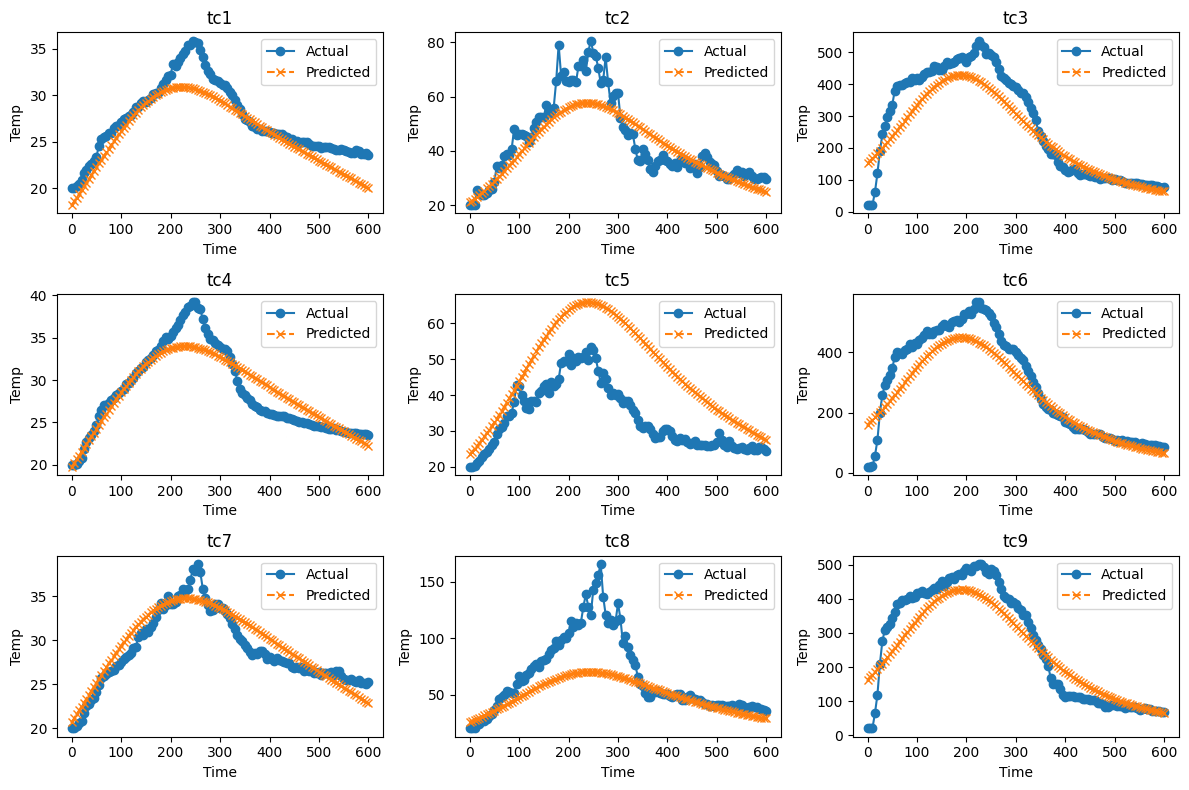


--- Hyperparam Set 2/32 ---
lr=0.001, layers=[3, 128, 128, 128, 1], activation=tanh, pde_weight_start=0.05, use_log=False
tc1: RMSE=7.67
tc2: RMSE=59.90
tc3: RMSE=188.48
tc4: RMSE=8.03
tc5: RMSE=71.53
tc6: RMSE=204.43
tc7: RMSE=9.13
tc8: RMSE=54.18
tc9: RMSE=185.47
Total/System RMSE: 117.17


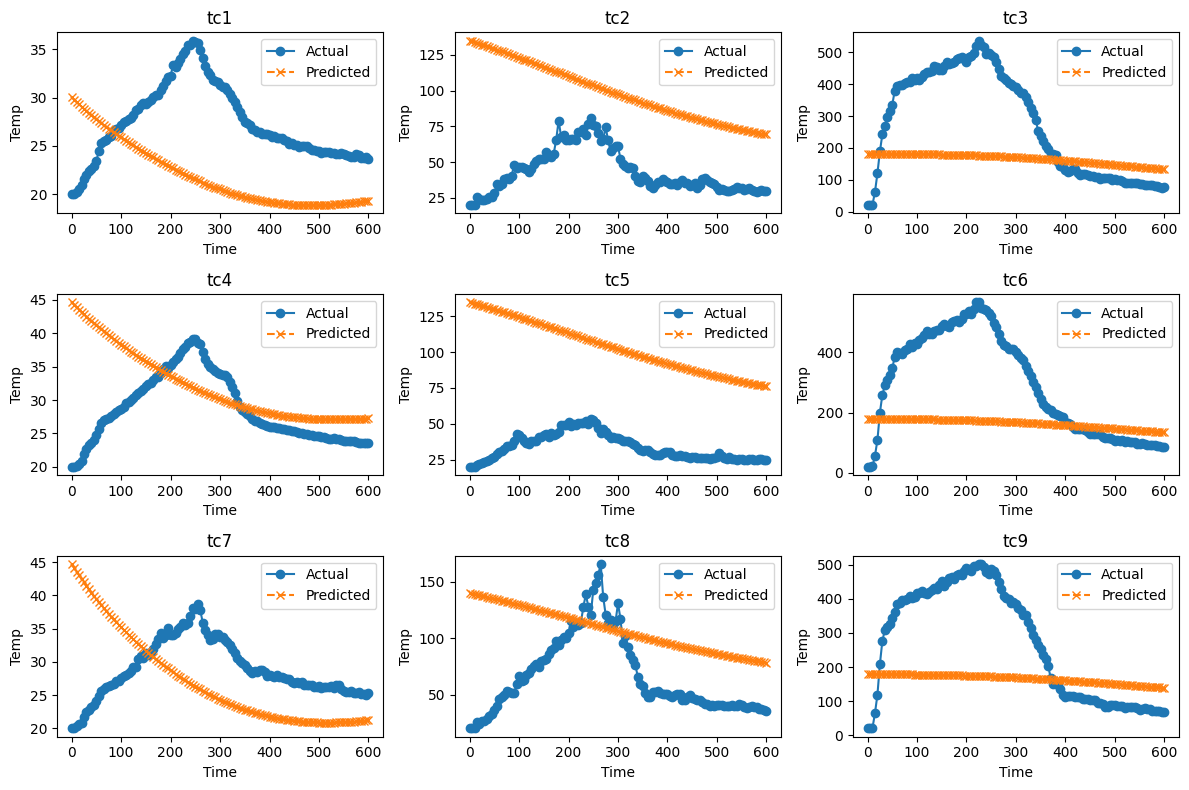


--- Hyperparam Set 3/32 ---
lr=0.001, layers=[3, 128, 128, 128, 1], activation=tanh, pde_weight_start=0.1, use_log=True
tc1: RMSE=6.84
tc2: RMSE=10.75
tc3: RMSE=100.42
tc4: RMSE=4.73
tc5: RMSE=35.26
tc6: RMSE=66.75
tc7: RMSE=4.58
tc8: RMSE=23.58
tc9: RMSE=81.55
Total/System RMSE: 50.77


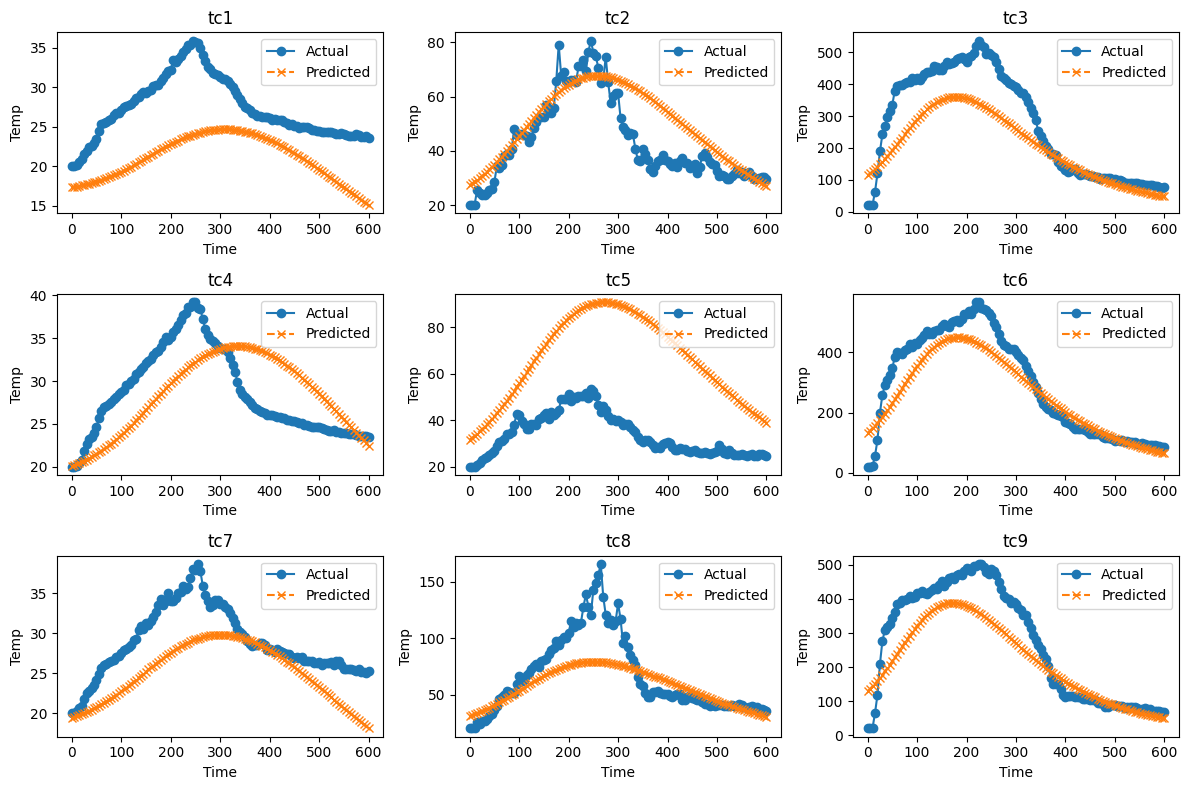


--- Hyperparam Set 4/32 ---
lr=0.001, layers=[3, 128, 128, 128, 1], activation=tanh, pde_weight_start=0.1, use_log=False
tc1: RMSE=20.53
tc2: RMSE=43.73
tc3: RMSE=188.61
tc4: RMSE=6.19
tc5: RMSE=62.61
tc6: RMSE=204.51
tc7: RMSE=15.55
tc8: RMSE=46.73
tc9: RMSE=185.06
Total/System RMSE: 115.65


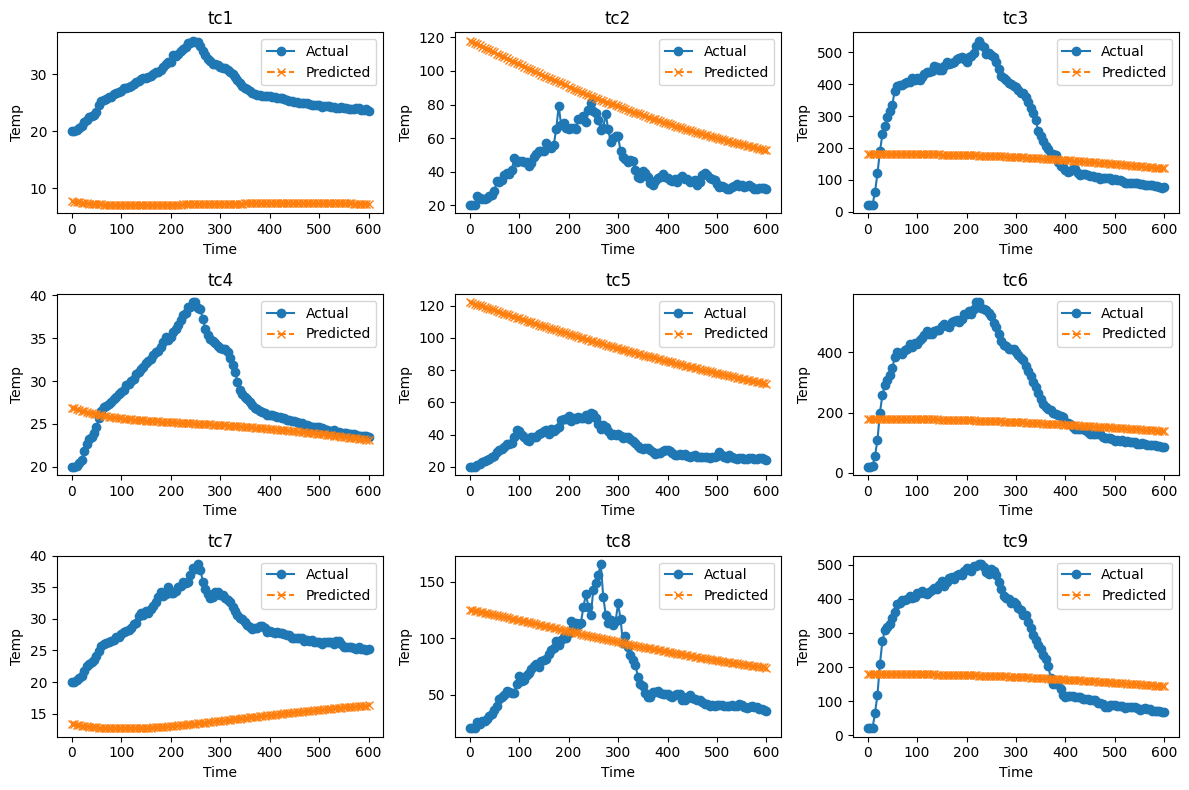


--- Hyperparam Set 5/32 ---
lr=0.001, layers=[3, 128, 128, 128, 1], activation=silu, pde_weight_start=0.05, use_log=True
tc1: RMSE=6.10
tc2: RMSE=10.55
tc3: RMSE=113.14
tc4: RMSE=4.70
tc5: RMSE=36.16
tc6: RMSE=77.82
tc7: RMSE=3.95
tc8: RMSE=25.24
tc9: RMSE=93.85
Total/System RMSE: 57.54


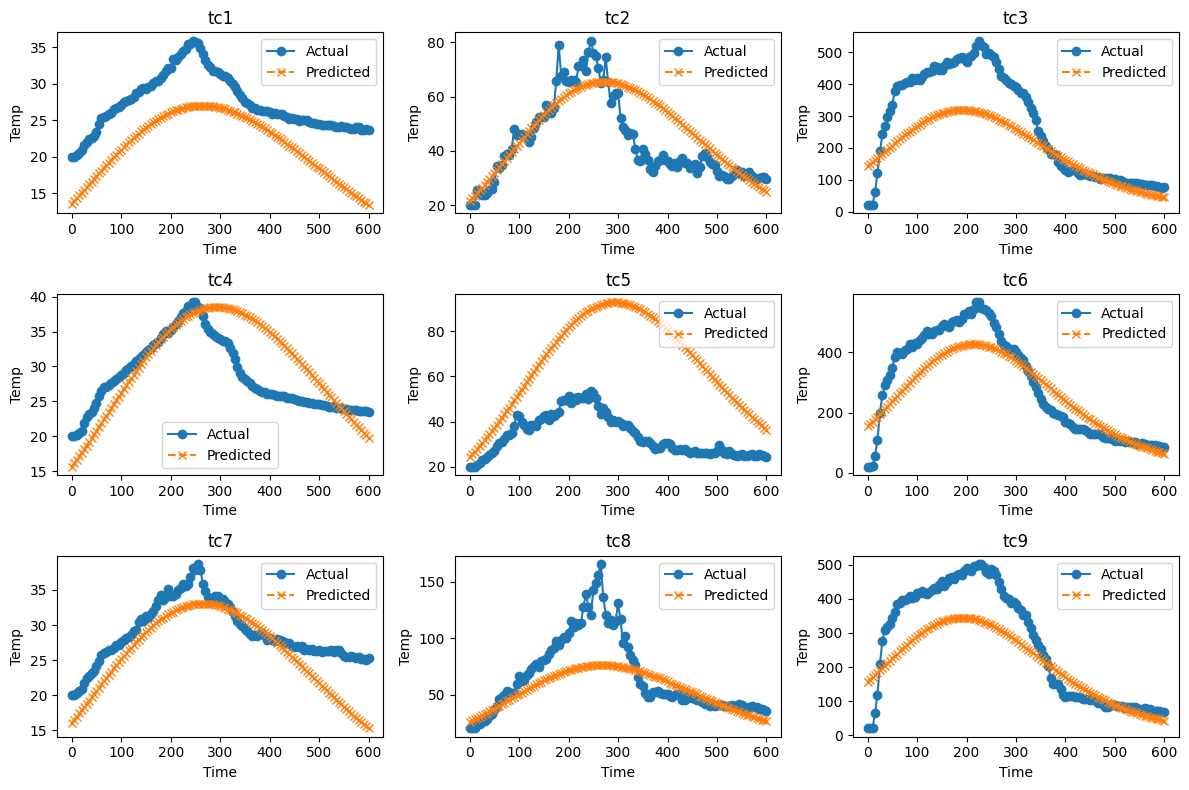


--- Hyperparam Set 6/32 ---
lr=0.001, layers=[3, 128, 128, 128, 1], activation=silu, pde_weight_start=0.05, use_log=False
tc1: RMSE=9.73
tc2: RMSE=28.92
tc3: RMSE=64.56
tc4: RMSE=8.90
tc5: RMSE=42.64
tc6: RMSE=65.43
tc7: RMSE=8.29
tc8: RMSE=31.77
tc9: RMSE=62.64
Total/System RMSE: 42.53


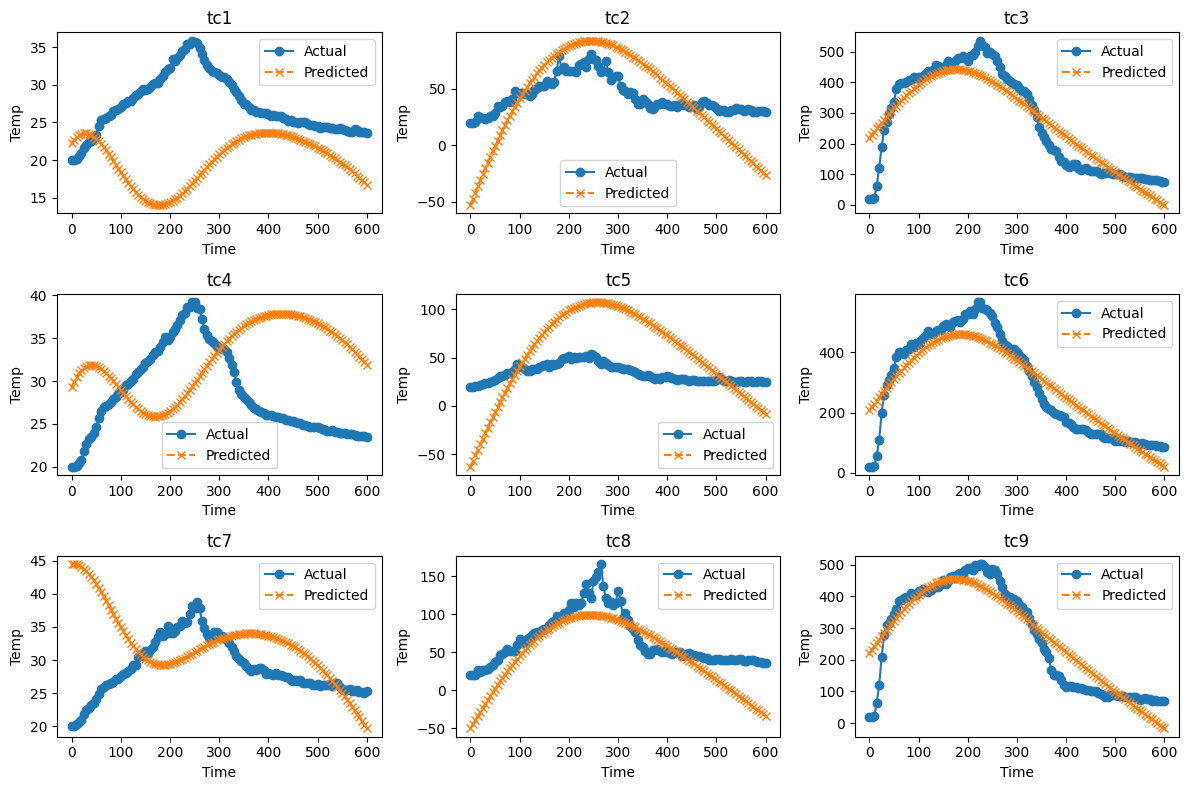


--- Hyperparam Set 7/32 ---
lr=0.001, layers=[3, 128, 128, 128, 1], activation=silu, pde_weight_start=0.1, use_log=True
tc1: RMSE=6.14
tc2: RMSE=11.35
tc3: RMSE=122.46
tc4: RMSE=4.43
tc5: RMSE=35.83
tc6: RMSE=91.15
tc7: RMSE=4.27
tc8: RMSE=25.85
tc9: RMSE=108.31
Total/System RMSE: 64.28


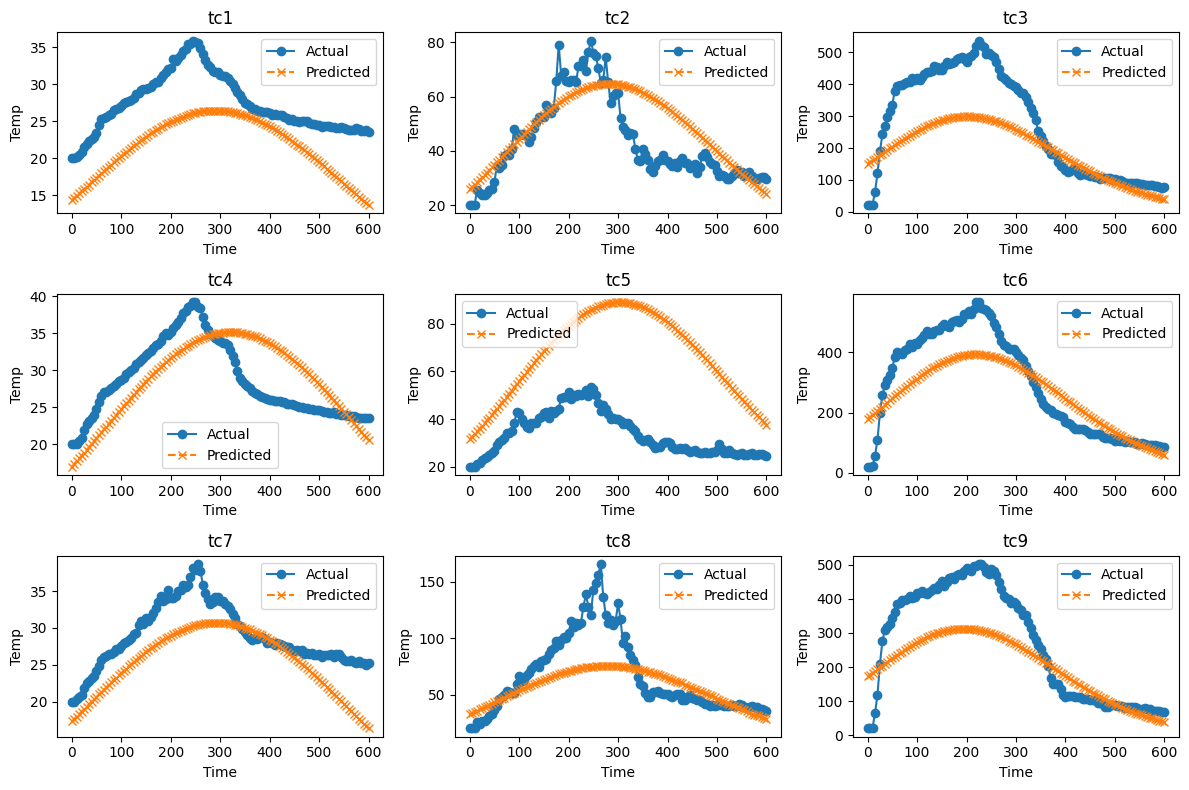


--- Hyperparam Set 8/32 ---
lr=0.001, layers=[3, 128, 128, 128, 1], activation=silu, pde_weight_start=0.1, use_log=False
tc1: RMSE=12.47
tc2: RMSE=33.40
tc3: RMSE=54.50
tc4: RMSE=11.27
tc5: RMSE=50.23
tc6: RMSE=53.46
tc7: RMSE=7.35
tc8: RMSE=29.83
tc9: RMSE=51.86
Total/System RMSE: 38.56


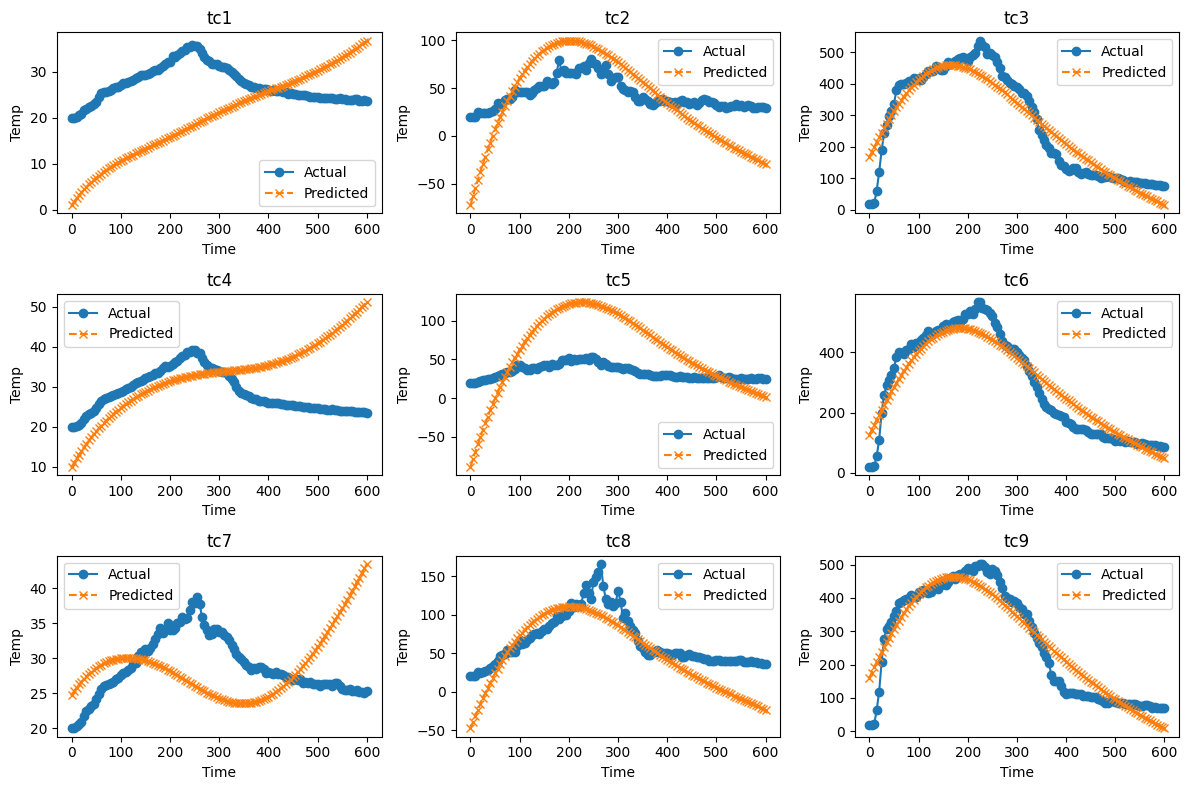


--- Hyperparam Set 9/32 ---
lr=0.001, layers=[3, 256, 256, 256, 1], activation=tanh, pde_weight_start=0.05, use_log=True
tc1: RMSE=8.05
tc2: RMSE=9.21
tc3: RMSE=145.87
tc4: RMSE=5.69
tc5: RMSE=26.40
tc6: RMSE=114.83
tc7: RMSE=6.17
tc8: RMSE=28.70
tc9: RMSE=132.02
Total/System RMSE: 77.20


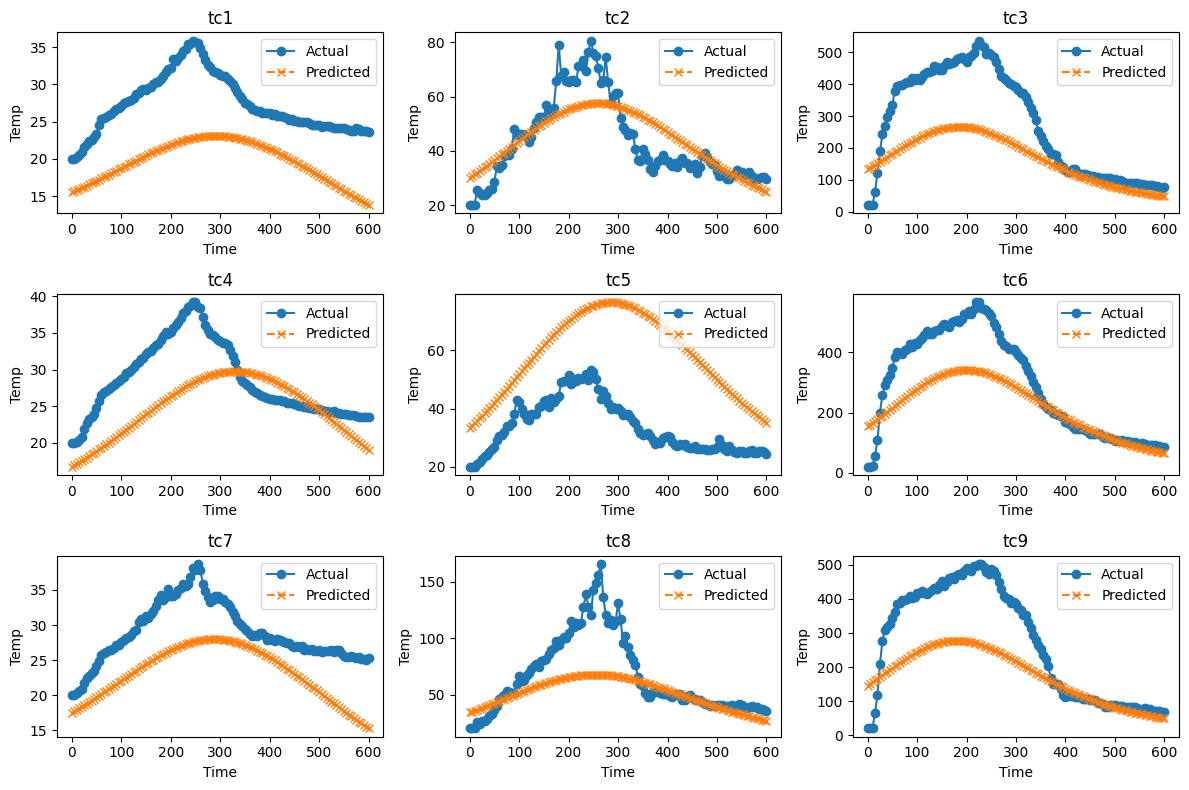


--- Hyperparam Set 10/32 ---
lr=0.001, layers=[3, 256, 256, 256, 1], activation=tanh, pde_weight_start=0.05, use_log=False
tc1: RMSE=24.32
tc2: RMSE=40.85
tc3: RMSE=133.49
tc4: RMSE=10.61
tc5: RMSE=68.20
tc6: RMSE=151.14
tc7: RMSE=21.09
tc8: RMSE=36.72
tc9: RMSE=132.81
Total/System RMSE: 86.36


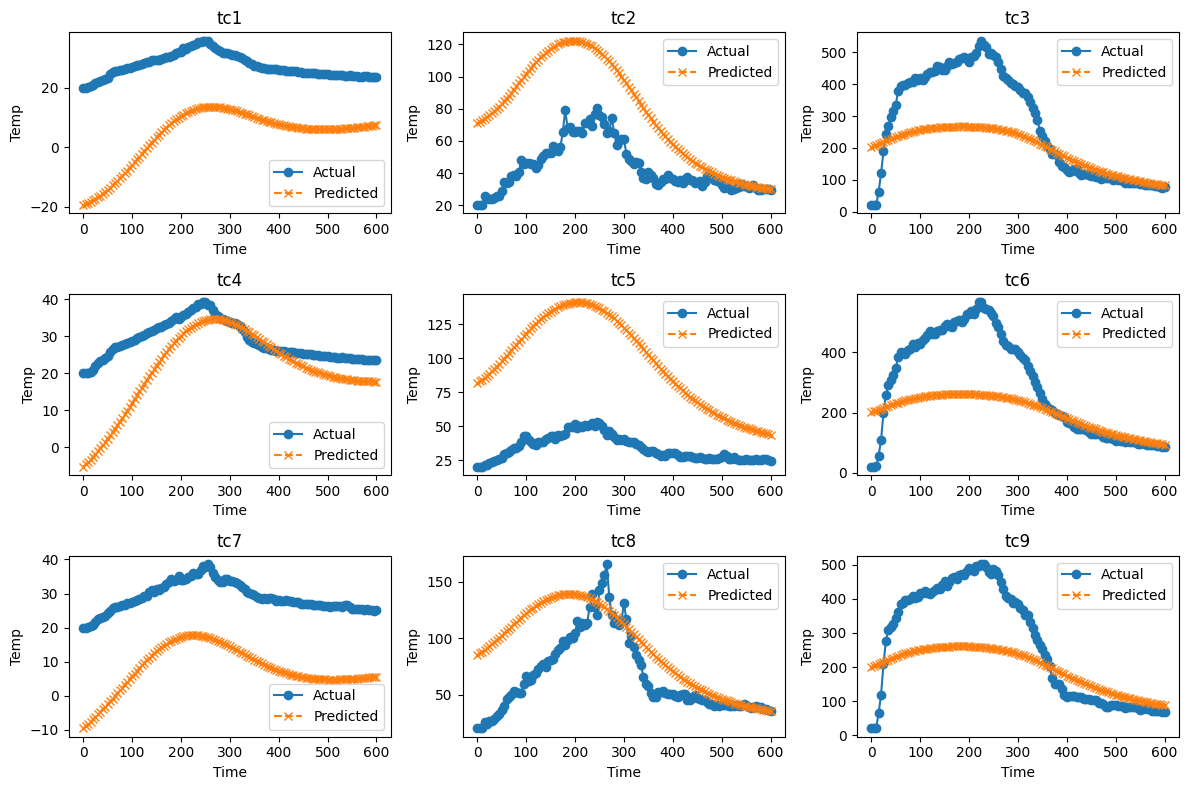


--- Hyperparam Set 11/32 ---
lr=0.001, layers=[3, 256, 256, 256, 1], activation=tanh, pde_weight_start=0.1, use_log=True
tc1: RMSE=2.71
tc2: RMSE=10.16
tc3: RMSE=107.57
tc4: RMSE=4.00
tc5: RMSE=26.94
tc6: RMSE=99.48
tc7: RMSE=2.26
tc8: RMSE=24.45
tc9: RMSE=89.62
Total/System RMSE: 58.65


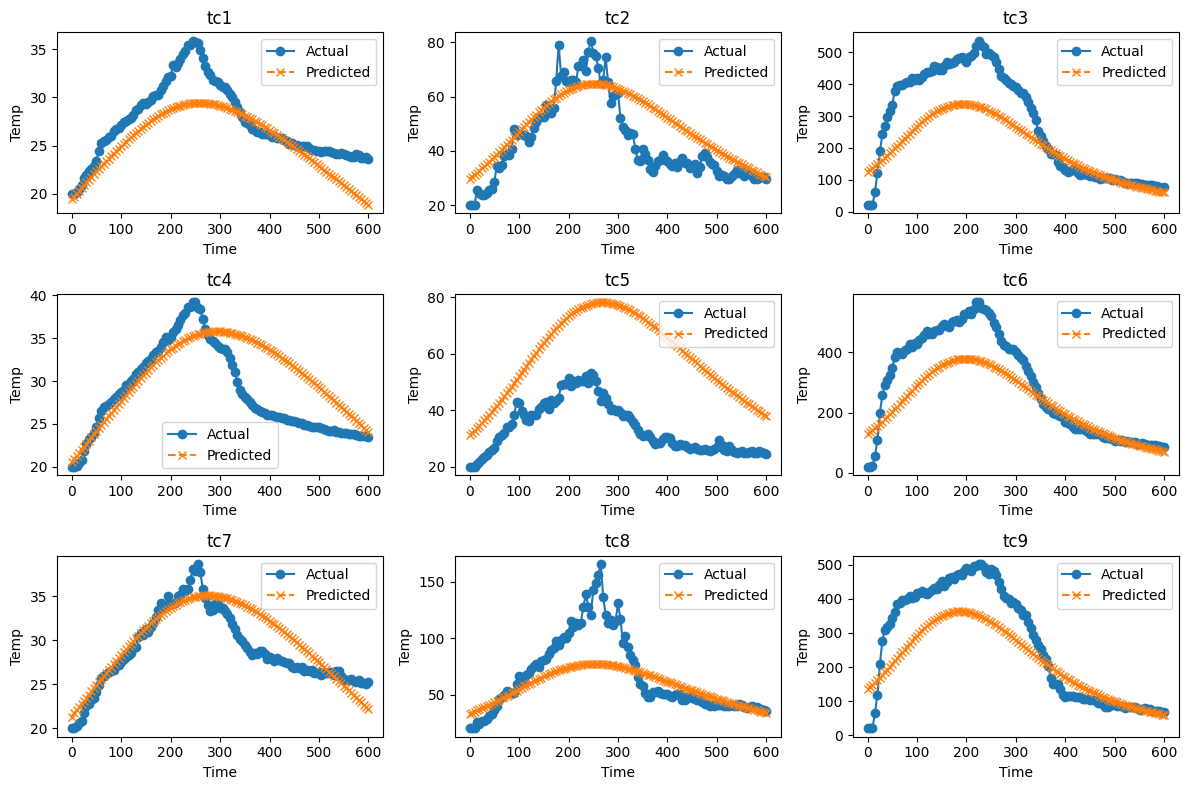


--- Hyperparam Set 12/32 ---
lr=0.001, layers=[3, 256, 256, 256, 1], activation=tanh, pde_weight_start=0.1, use_log=False
tc1: RMSE=24.76
tc2: RMSE=55.66
tc3: RMSE=139.14
tc4: RMSE=15.28
tc5: RMSE=75.02
tc6: RMSE=153.10
tc7: RMSE=14.25
tc8: RMSE=47.18
tc9: RMSE=134.71
Total/System RMSE: 90.03


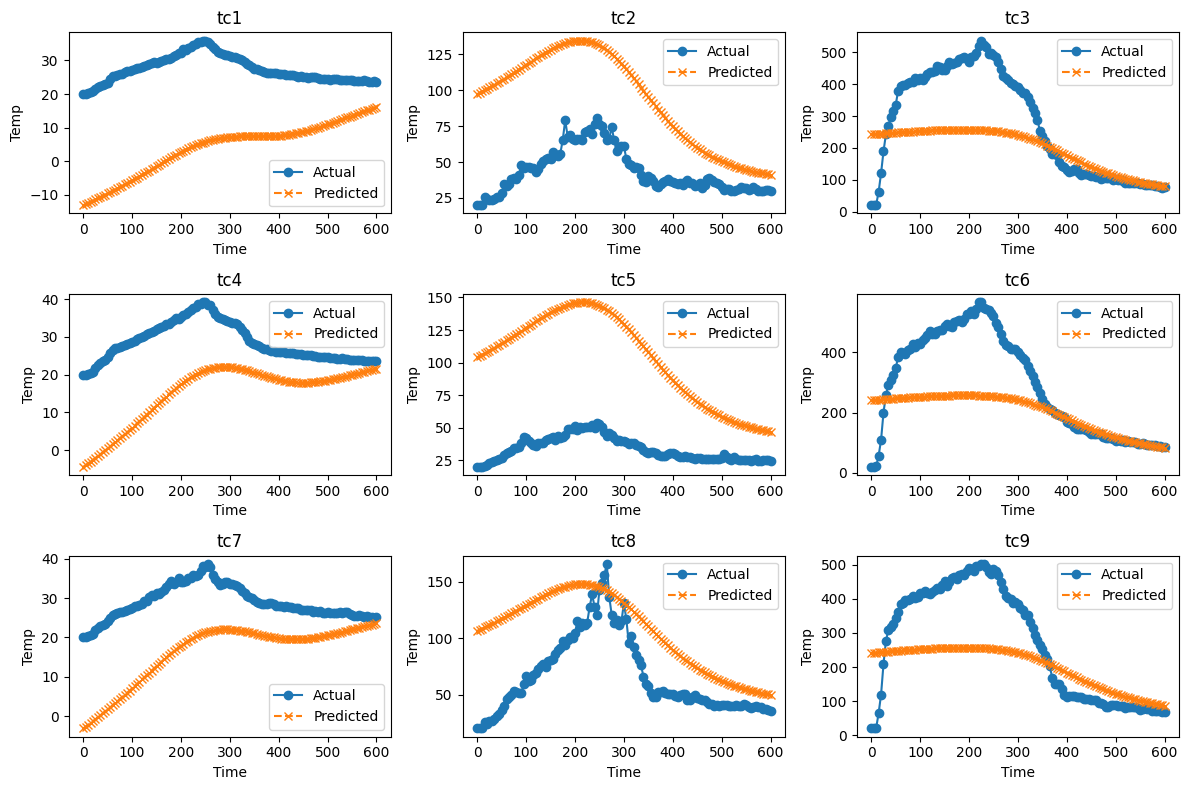


--- Hyperparam Set 13/32 ---
lr=0.001, layers=[3, 256, 256, 256, 1], activation=silu, pde_weight_start=0.05, use_log=True
tc1: RMSE=5.79
tc2: RMSE=9.85
tc3: RMSE=95.60
tc4: RMSE=3.06
tc5: RMSE=37.48
tc6: RMSE=55.27
tc7: RMSE=3.70
tc8: RMSE=20.77
tc9: RMSE=75.90
Total/System RMSE: 47.08


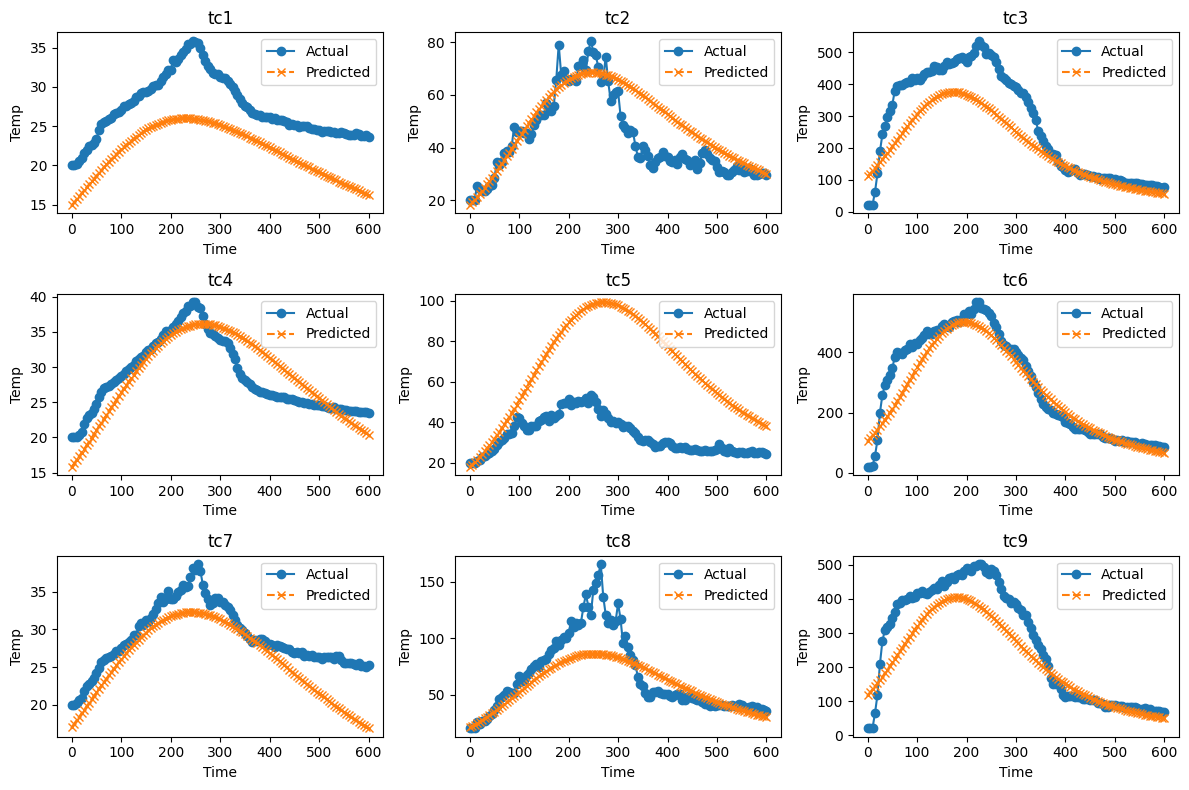


--- Hyperparam Set 14/32 ---
lr=0.001, layers=[3, 256, 256, 256, 1], activation=silu, pde_weight_start=0.05, use_log=False
tc1: RMSE=16.73
tc2: RMSE=24.91
tc3: RMSE=50.36
tc4: RMSE=15.90
tc5: RMSE=41.55
tc6: RMSE=50.77
tc7: RMSE=10.13
tc8: RMSE=27.21
tc9: RMSE=48.24
Total/System RMSE: 35.22


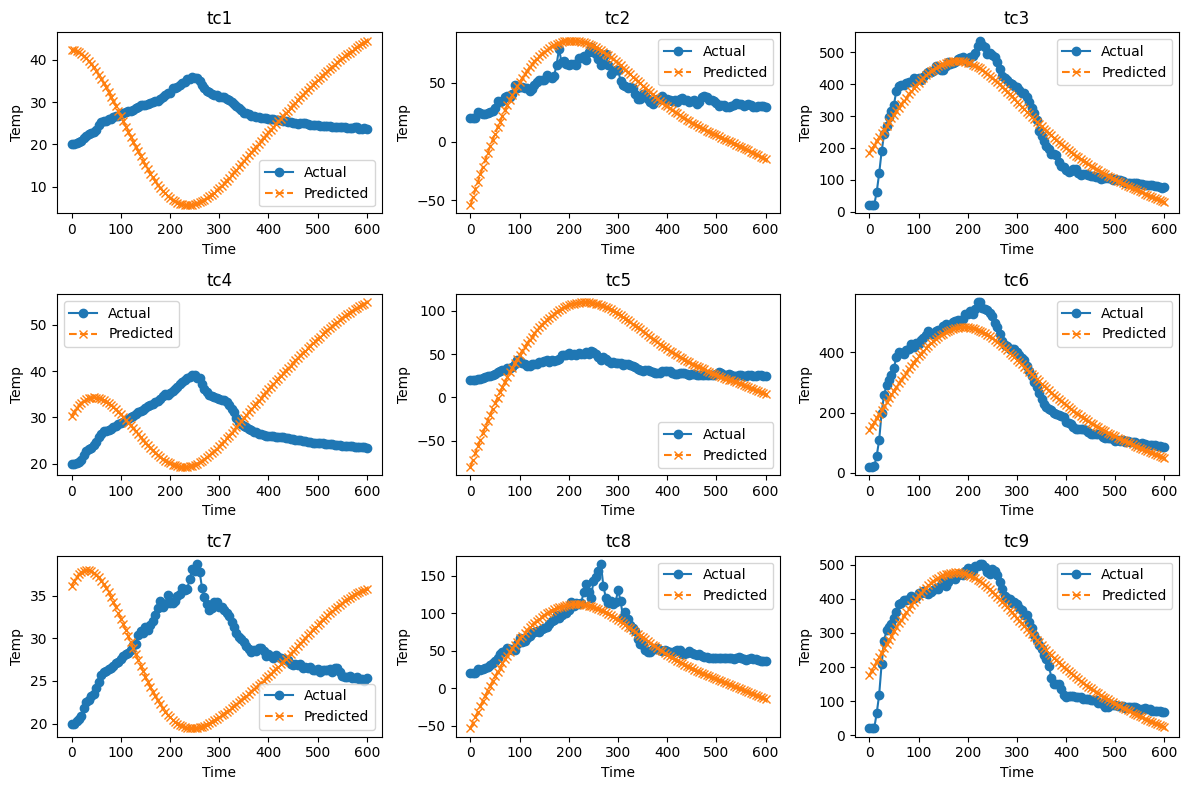


--- Hyperparam Set 15/32 ---
lr=0.001, layers=[3, 256, 256, 256, 1], activation=silu, pde_weight_start=0.1, use_log=True
tc1: RMSE=5.82
tc2: RMSE=10.57
tc3: RMSE=108.96
tc4: RMSE=3.66
tc5: RMSE=36.92
tc6: RMSE=67.26
tc7: RMSE=3.84
tc8: RMSE=23.56
tc9: RMSE=90.16
Total/System RMSE: 54.38


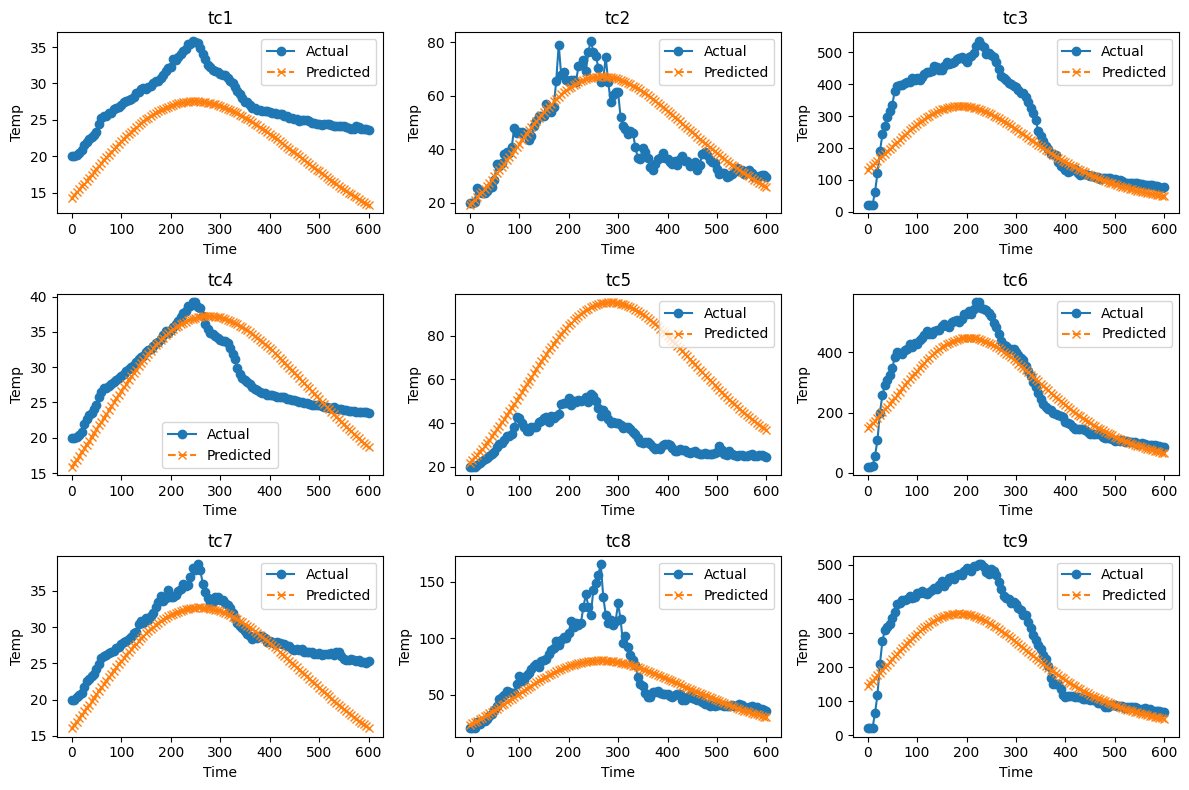


--- Hyperparam Set 16/32 ---
lr=0.001, layers=[3, 256, 256, 256, 1], activation=silu, pde_weight_start=0.1, use_log=False
tc1: RMSE=9.43
tc2: RMSE=27.05
tc3: RMSE=47.26
tc4: RMSE=13.82
tc5: RMSE=43.80
tc6: RMSE=47.73
tc7: RMSE=6.47
tc8: RMSE=27.18
tc9: RMSE=47.33
Total/System RMSE: 34.09


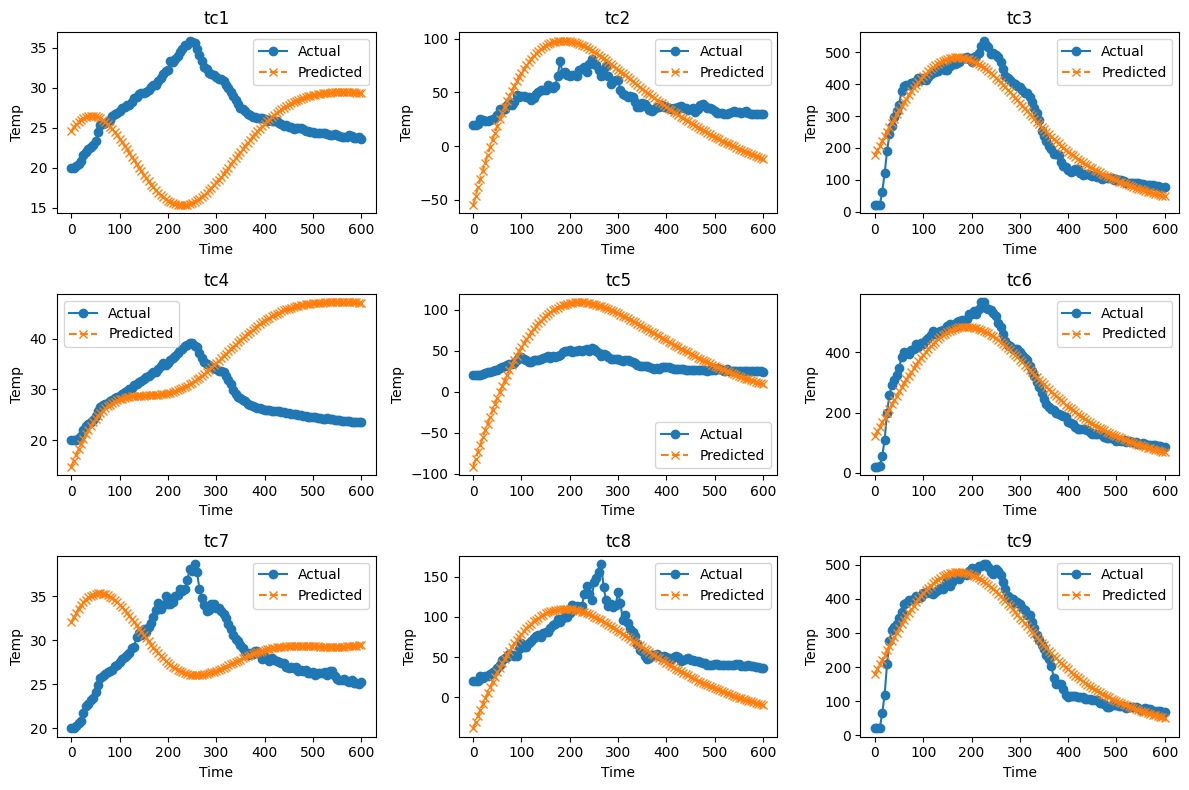


--- Hyperparam Set 17/32 ---
lr=0.0005, layers=[3, 128, 128, 128, 1], activation=tanh, pde_weight_start=0.05, use_log=True
tc1: RMSE=6.72
tc2: RMSE=11.43
tc3: RMSE=112.34
tc4: RMSE=4.15
tc5: RMSE=35.33
tc6: RMSE=81.30
tc7: RMSE=4.81
tc8: RMSE=25.20
tc9: RMSE=102.18
Total/System RMSE: 59.41


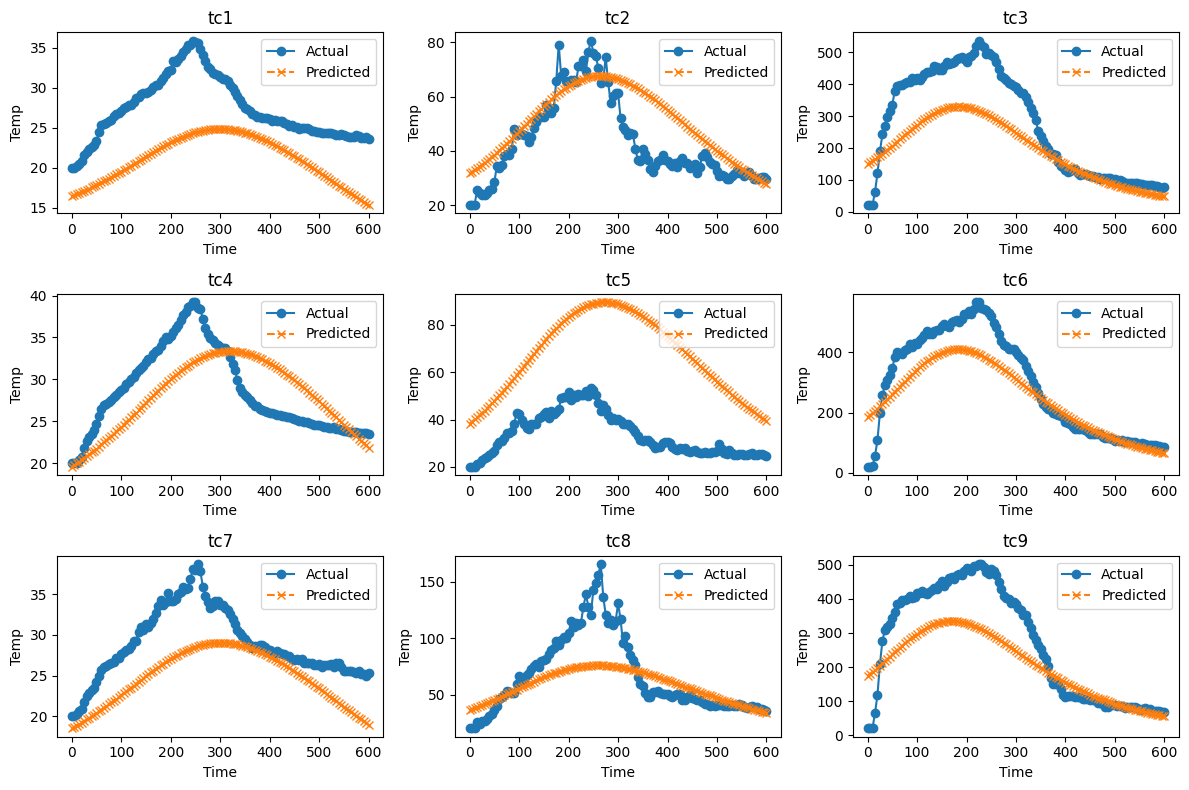


--- Hyperparam Set 18/32 ---
lr=0.0005, layers=[3, 128, 128, 128, 1], activation=tanh, pde_weight_start=0.05, use_log=False
tc1: RMSE=37.19
tc2: RMSE=39.55
tc3: RMSE=240.89
tc4: RMSE=36.05
tc5: RMSE=47.68
tc6: RMSE=257.07
tc7: RMSE=37.72
tc8: RMSE=34.99
tc9: RMSE=234.67
Total/System RMSE: 144.66


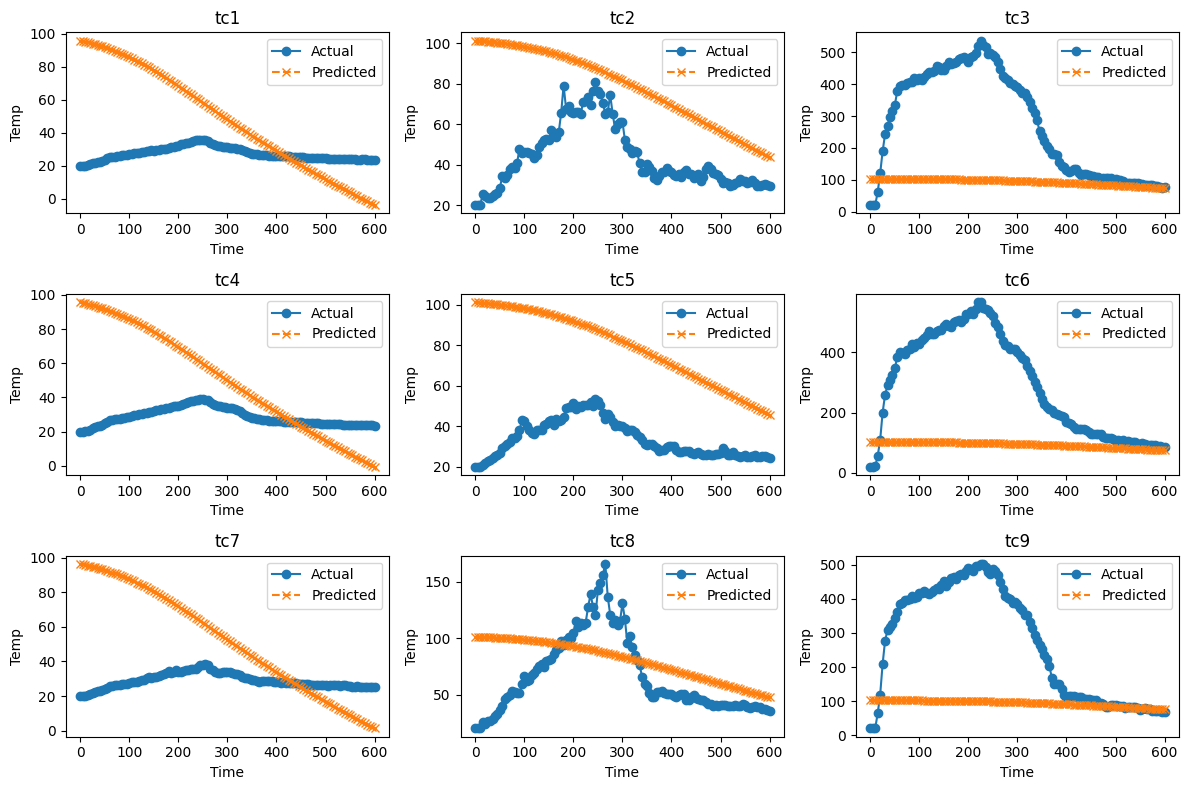


--- Hyperparam Set 19/32 ---
lr=0.0005, layers=[3, 128, 128, 128, 1], activation=tanh, pde_weight_start=0.1, use_log=True
tc1: RMSE=7.12
tc2: RMSE=10.76
tc3: RMSE=113.35
tc4: RMSE=4.48
tc5: RMSE=32.66
tc6: RMSE=81.47
tc7: RMSE=5.70
tc8: RMSE=26.12
tc9: RMSE=102.74
Total/System RMSE: 59.64


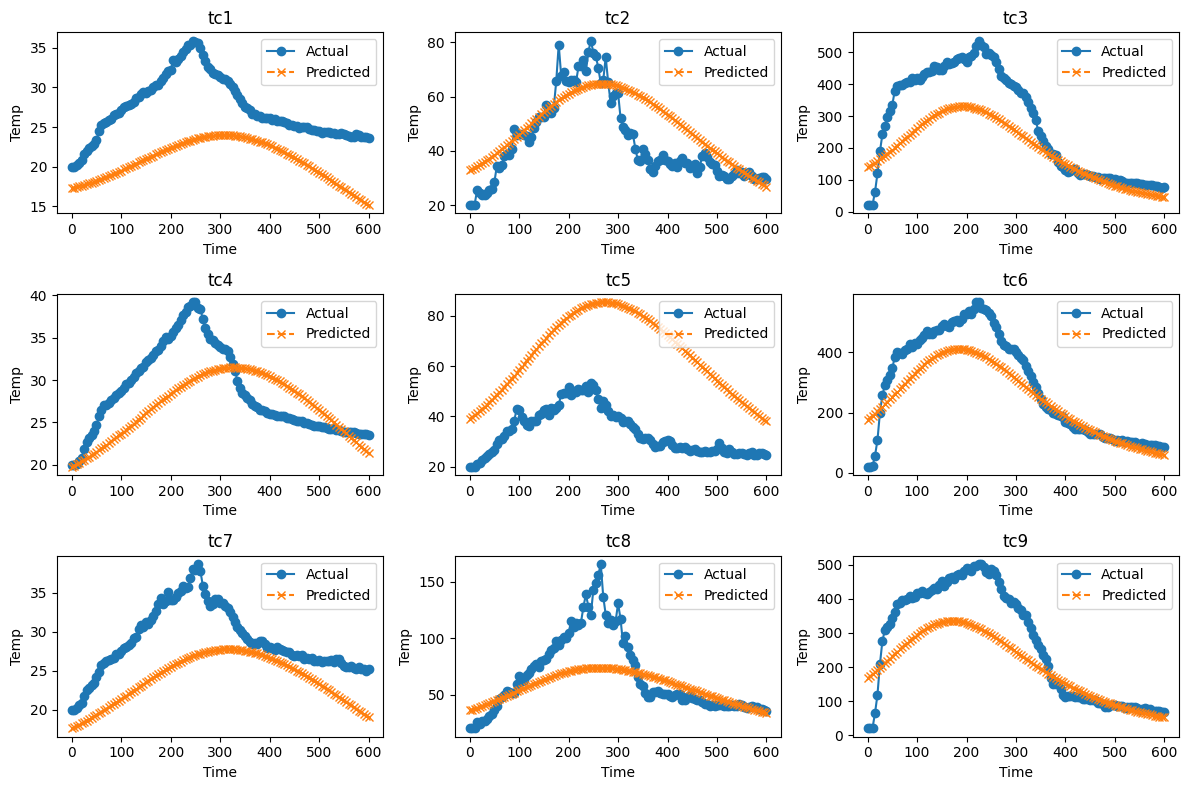


--- Hyperparam Set 20/32 ---
lr=0.0005, layers=[3, 128, 128, 128, 1], activation=tanh, pde_weight_start=0.1, use_log=False
tc1: RMSE=32.45
tc2: RMSE=39.14
tc3: RMSE=238.75
tc4: RMSE=31.69
tc5: RMSE=47.22
tc6: RMSE=254.94
tc7: RMSE=33.54
tc8: RMSE=35.20
tc9: RMSE=232.69
Total/System RMSE: 143.11


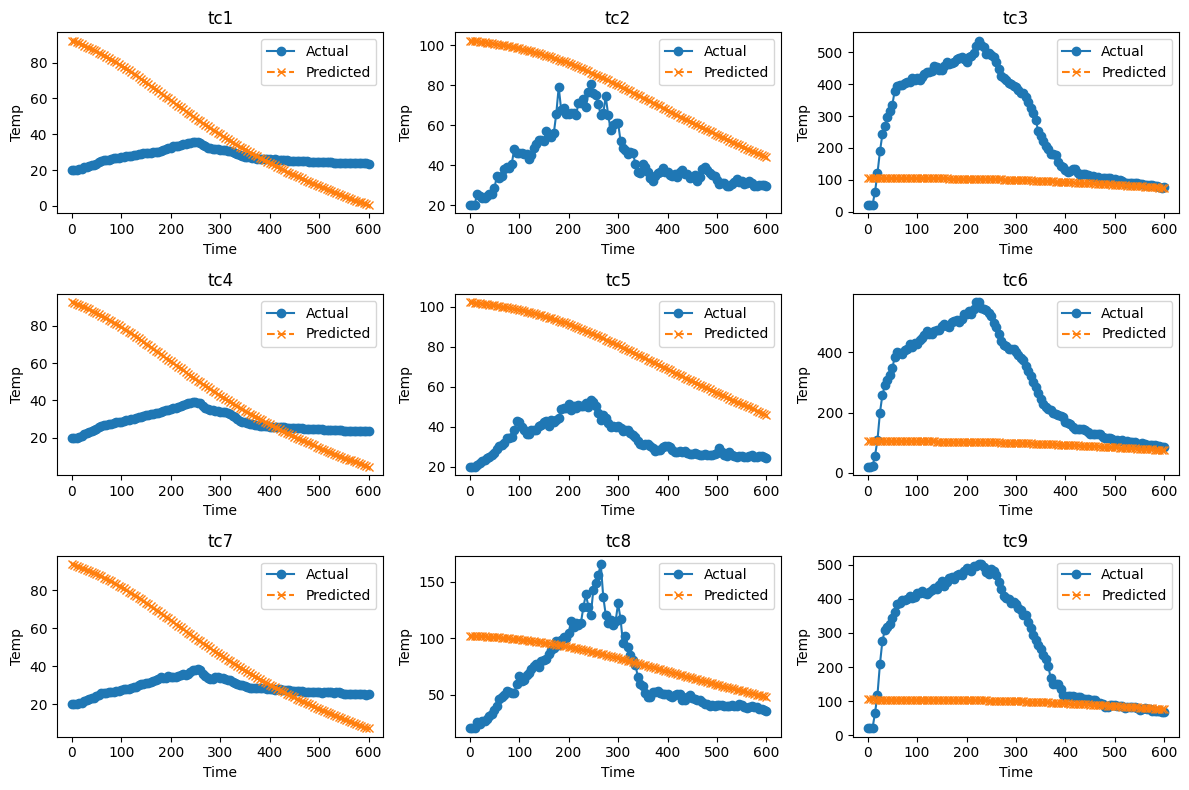


--- Hyperparam Set 21/32 ---
lr=0.0005, layers=[3, 128, 128, 128, 1], activation=silu, pde_weight_start=0.05, use_log=True
tc1: RMSE=6.35
tc2: RMSE=11.00
tc3: RMSE=127.20
tc4: RMSE=5.28
tc5: RMSE=35.54
tc6: RMSE=90.99
tc7: RMSE=4.30
tc8: RMSE=26.03
tc9: RMSE=105.76
Total/System RMSE: 64.80


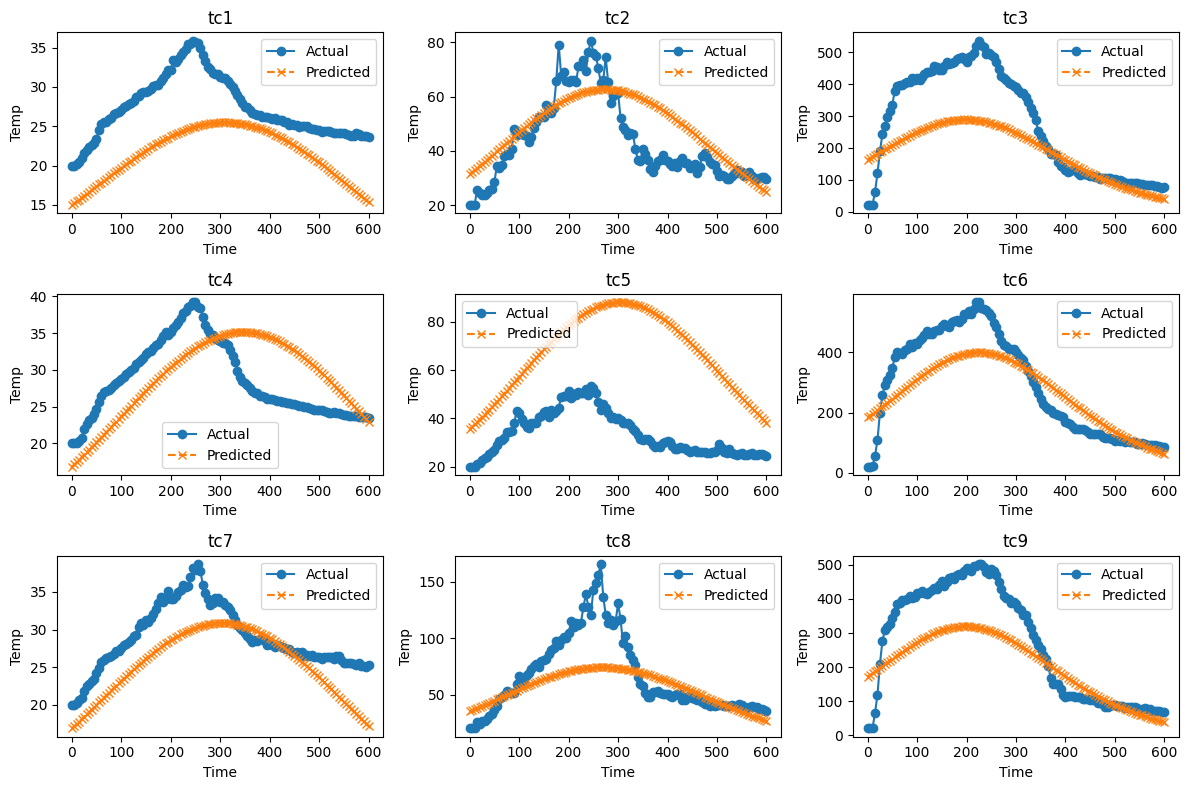


--- Hyperparam Set 22/32 ---
lr=0.0005, layers=[3, 128, 128, 128, 1], activation=silu, pde_weight_start=0.05, use_log=False
tc1: RMSE=30.79
tc2: RMSE=38.89
tc3: RMSE=75.93
tc4: RMSE=27.00
tc5: RMSE=78.25
tc6: RMSE=75.79
tc7: RMSE=20.70
tc8: RMSE=31.96
tc9: RMSE=70.44
Total/System RMSE: 55.01


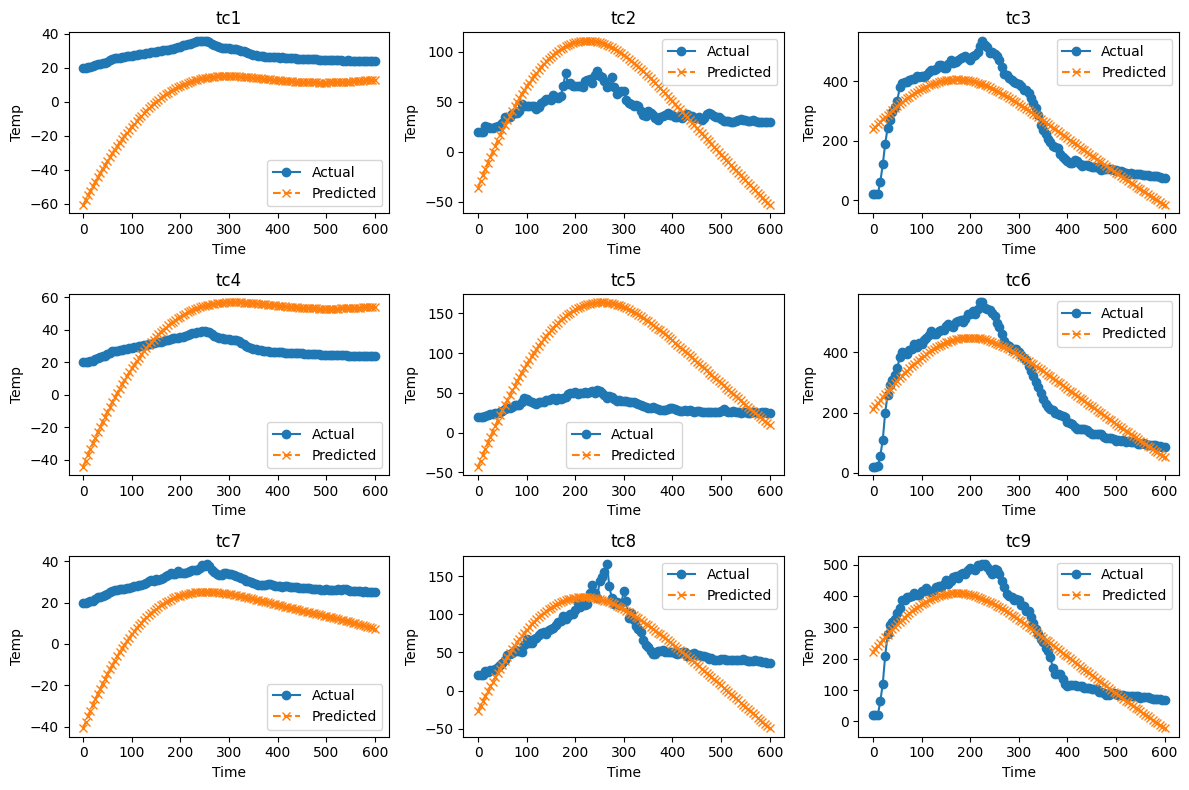


--- Hyperparam Set 23/32 ---
lr=0.0005, layers=[3, 128, 128, 128, 1], activation=silu, pde_weight_start=0.1, use_log=True
tc1: RMSE=6.72
tc2: RMSE=12.38
tc3: RMSE=124.66
tc4: RMSE=5.33
tc5: RMSE=35.44
tc6: RMSE=99.26
tc7: RMSE=4.21
tc8: RMSE=25.22
tc9: RMSE=106.91
Total/System RMSE: 65.79


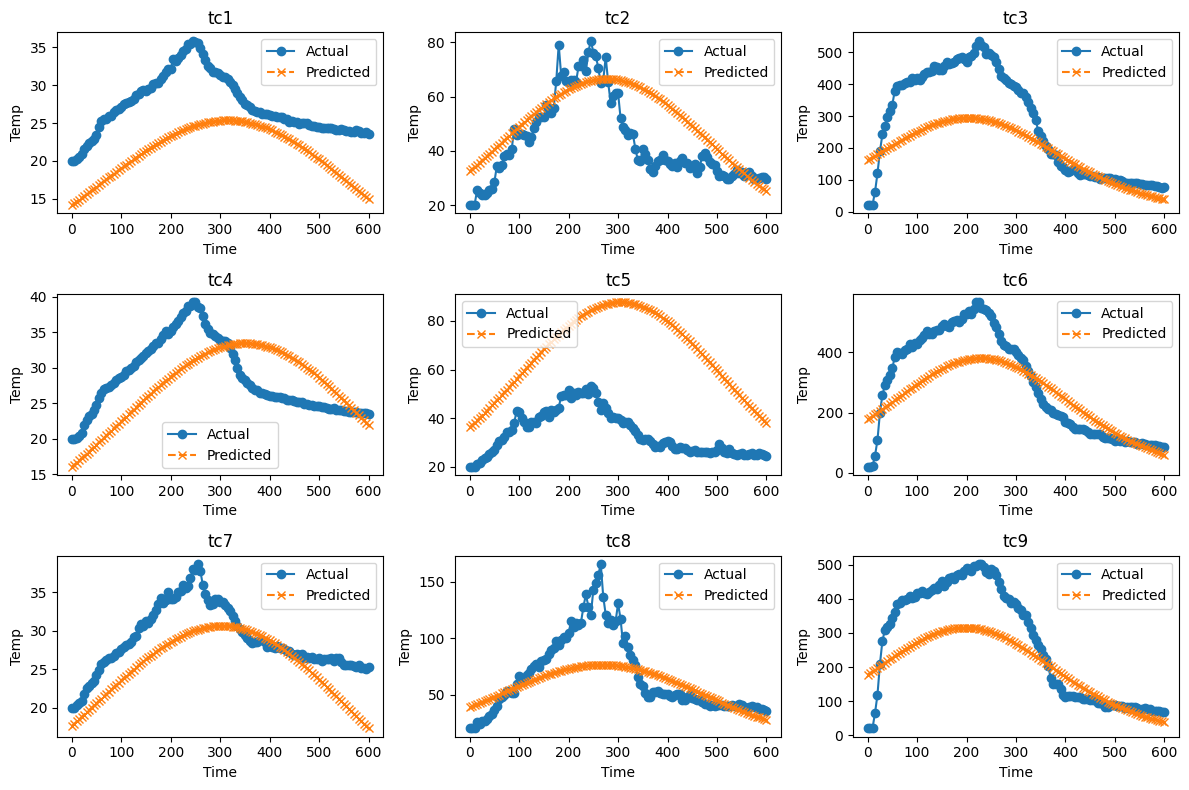


--- Hyperparam Set 24/32 ---
lr=0.0005, layers=[3, 128, 128, 128, 1], activation=silu, pde_weight_start=0.1, use_log=False
tc1: RMSE=30.33
tc2: RMSE=35.13
tc3: RMSE=76.74
tc4: RMSE=26.56
tc5: RMSE=77.22
tc6: RMSE=75.54
tc7: RMSE=23.42
tc8: RMSE=28.76
tc9: RMSE=71.61
Total/System RMSE: 54.69


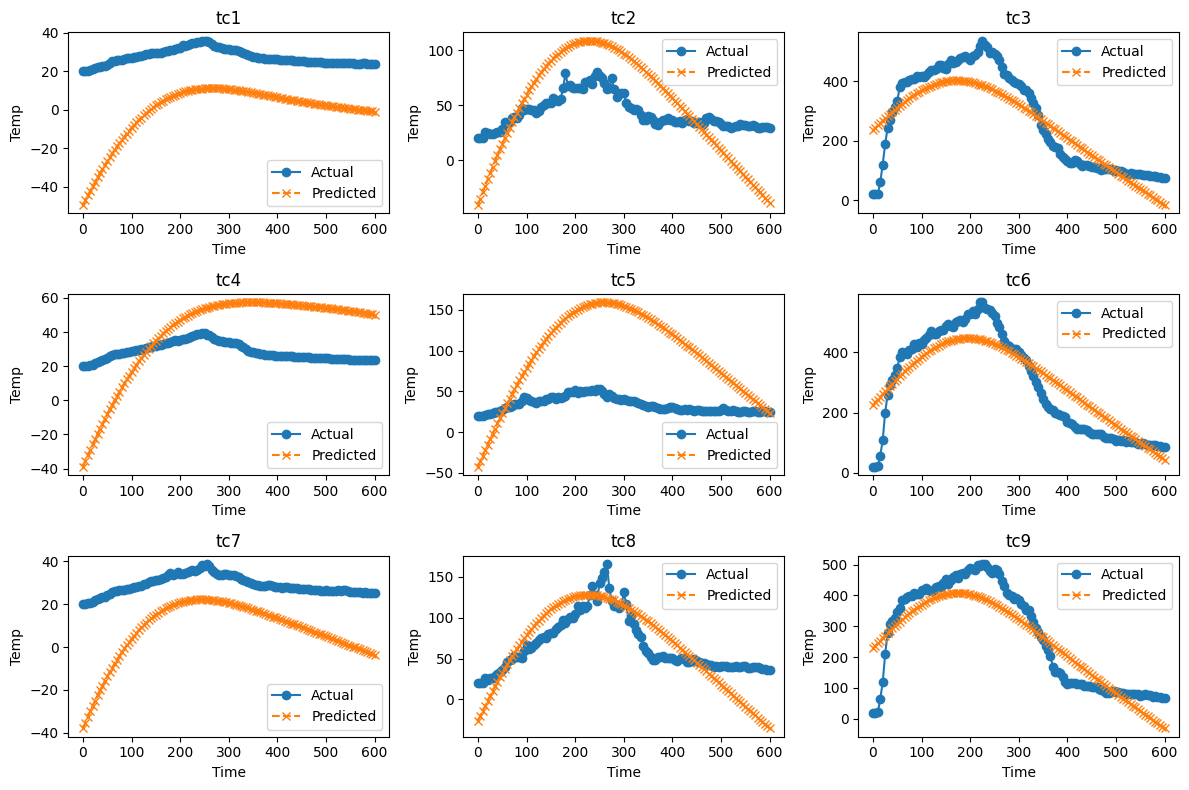


--- Hyperparam Set 25/32 ---
lr=0.0005, layers=[3, 256, 256, 256, 1], activation=tanh, pde_weight_start=0.05, use_log=True
tc1: RMSE=5.76
tc2: RMSE=7.53
tc3: RMSE=89.90
tc4: RMSE=4.08
tc5: RMSE=31.07
tc6: RMSE=60.31
tc7: RMSE=3.81
tc8: RMSE=23.14
tc9: RMSE=74.19
Total/System RMSE: 45.76


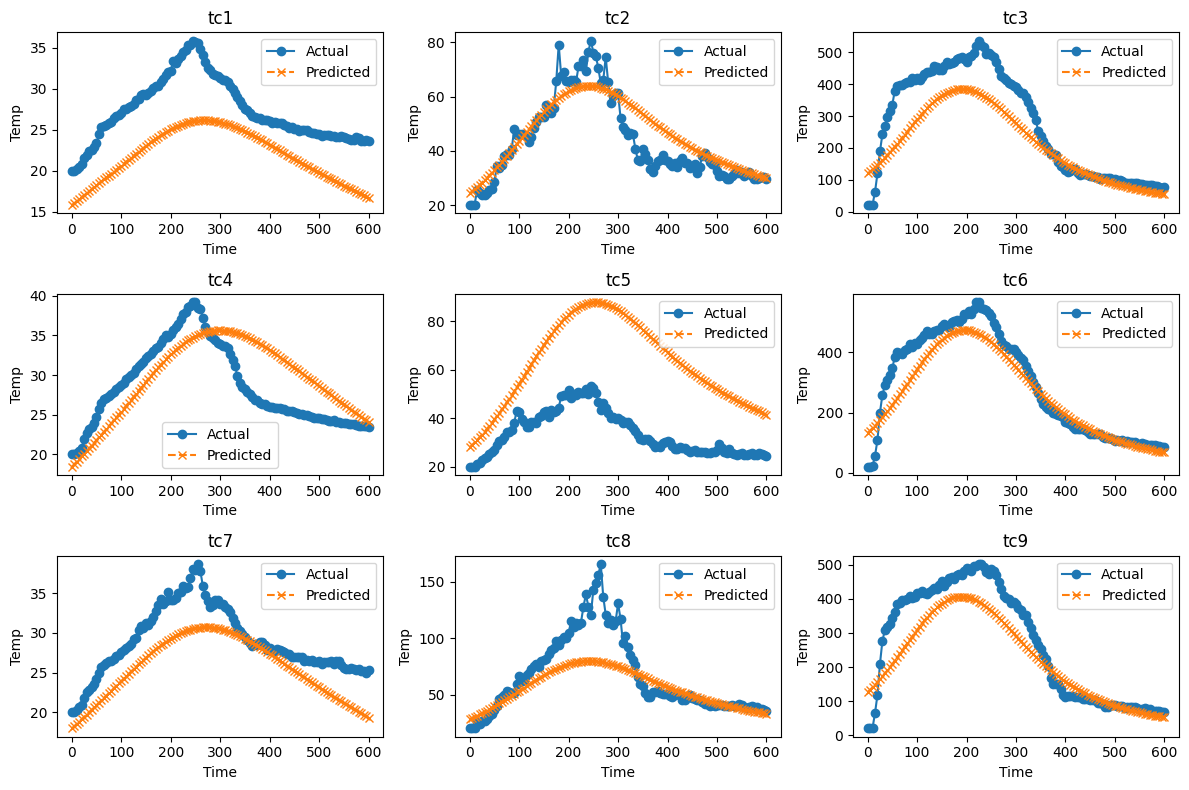


--- Hyperparam Set 26/32 ---
lr=0.0005, layers=[3, 256, 256, 256, 1], activation=tanh, pde_weight_start=0.05, use_log=False
tc1: RMSE=9.92
tc2: RMSE=50.30
tc3: RMSE=185.70
tc4: RMSE=4.42
tc5: RMSE=68.12
tc6: RMSE=200.44
tc7: RMSE=2.94
tc8: RMSE=50.48
tc9: RMSE=181.10
Total/System RMSE: 114.16


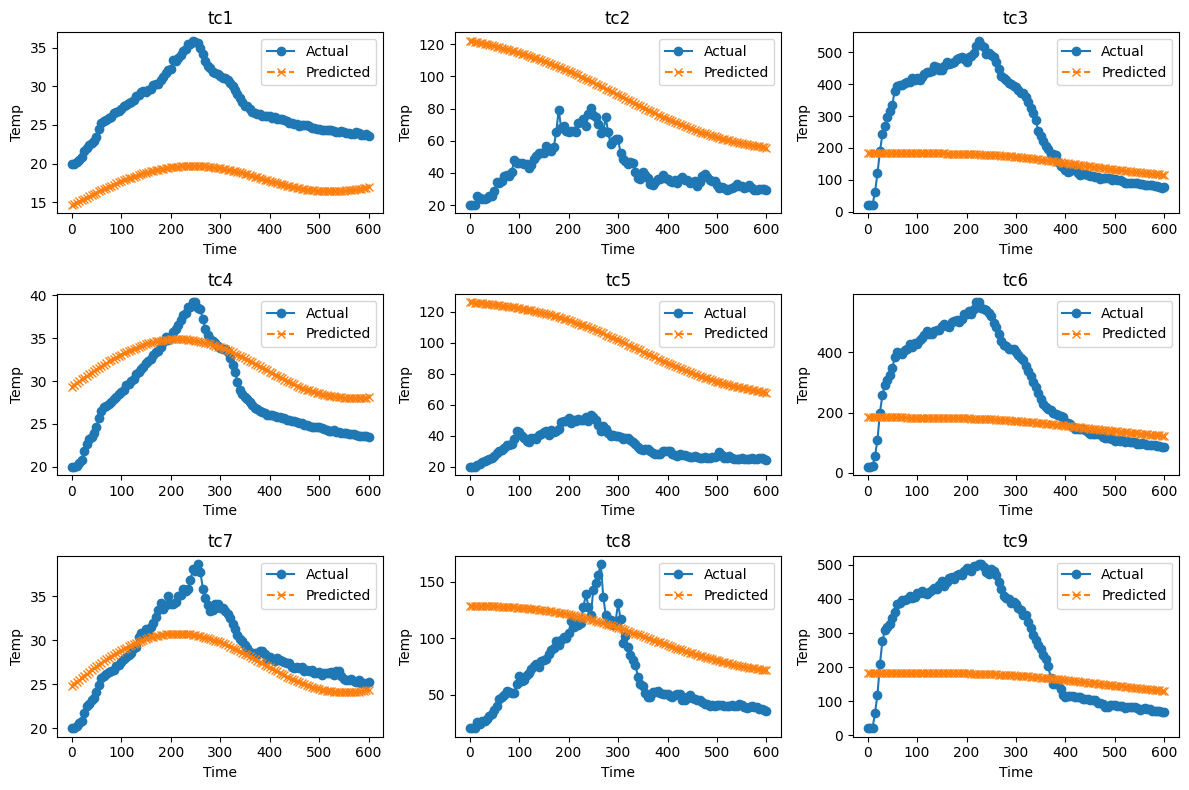


--- Hyperparam Set 27/32 ---
lr=0.0005, layers=[3, 256, 256, 256, 1], activation=tanh, pde_weight_start=0.1, use_log=True
tc1: RMSE=5.56
tc2: RMSE=10.27
tc3: RMSE=105.66
tc4: RMSE=3.33
tc5: RMSE=33.47
tc6: RMSE=76.90
tc7: RMSE=3.82
tc8: RMSE=24.95
tc9: RMSE=98.52
Total/System RMSE: 56.46


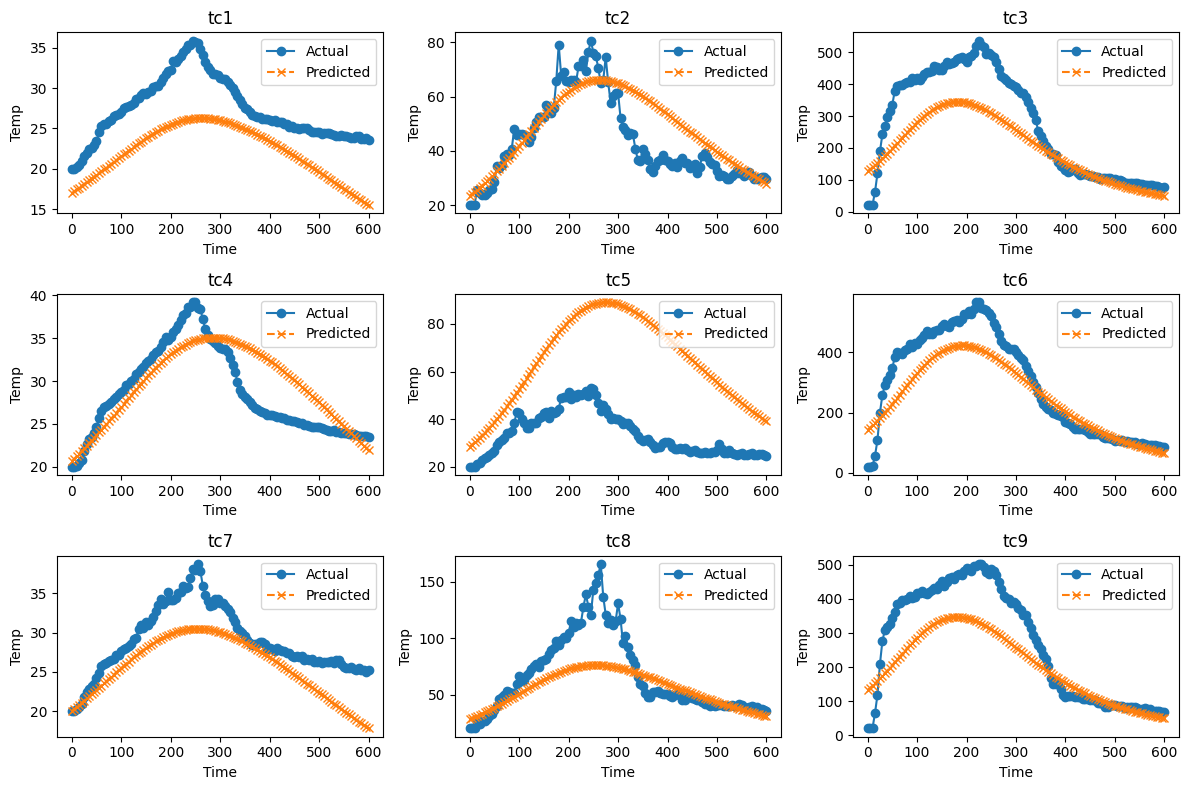


--- Hyperparam Set 28/32 ---
lr=0.0005, layers=[3, 256, 256, 256, 1], activation=tanh, pde_weight_start=0.1, use_log=False
tc1: RMSE=16.62
tc2: RMSE=45.63
tc3: RMSE=185.77
tc4: RMSE=8.67
tc5: RMSE=59.00
tc6: RMSE=201.34
tc7: RMSE=12.89
tc8: RMSE=46.38
tc9: RMSE=181.66
Total/System RMSE: 113.67


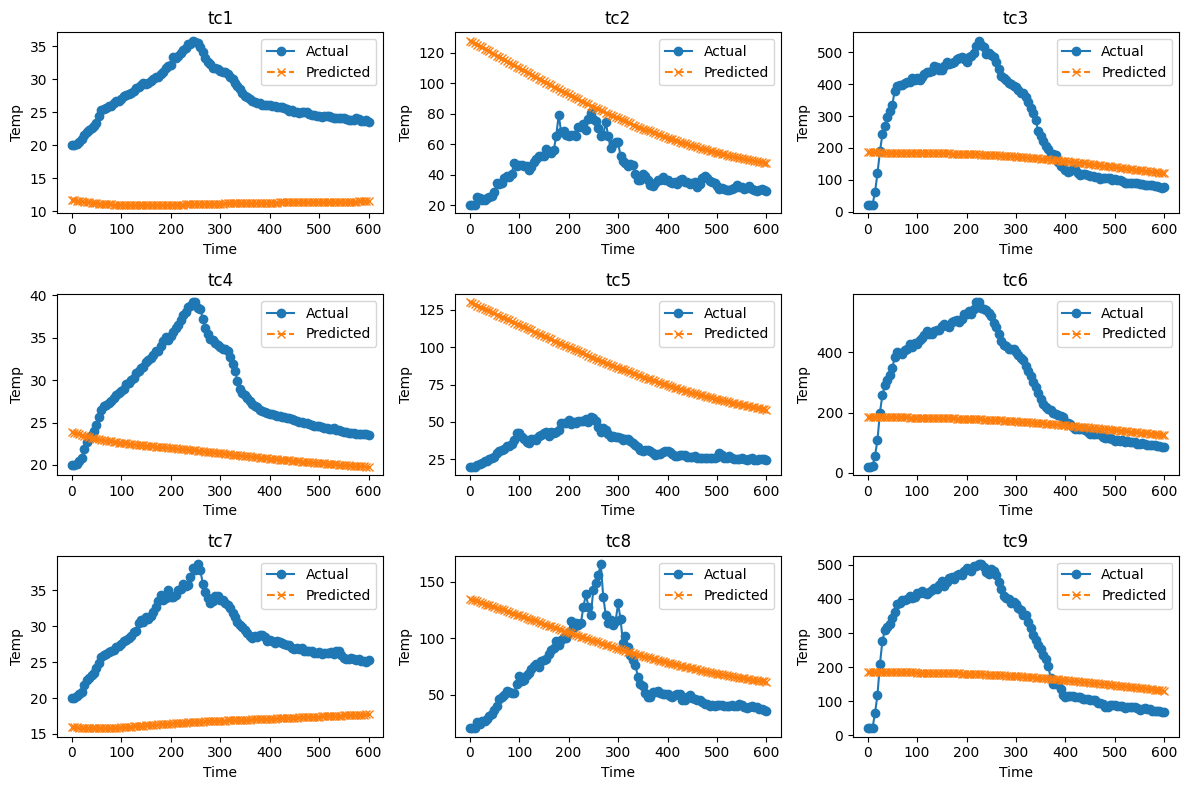


--- Hyperparam Set 29/32 ---
lr=0.0005, layers=[3, 256, 256, 256, 1], activation=silu, pde_weight_start=0.05, use_log=True
tc1: RMSE=6.11
tc2: RMSE=11.39
tc3: RMSE=119.67
tc4: RMSE=4.13
tc5: RMSE=36.07
tc6: RMSE=84.16
tc7: RMSE=3.96
tc8: RMSE=25.21
tc9: RMSE=101.77
Total/System RMSE: 61.37


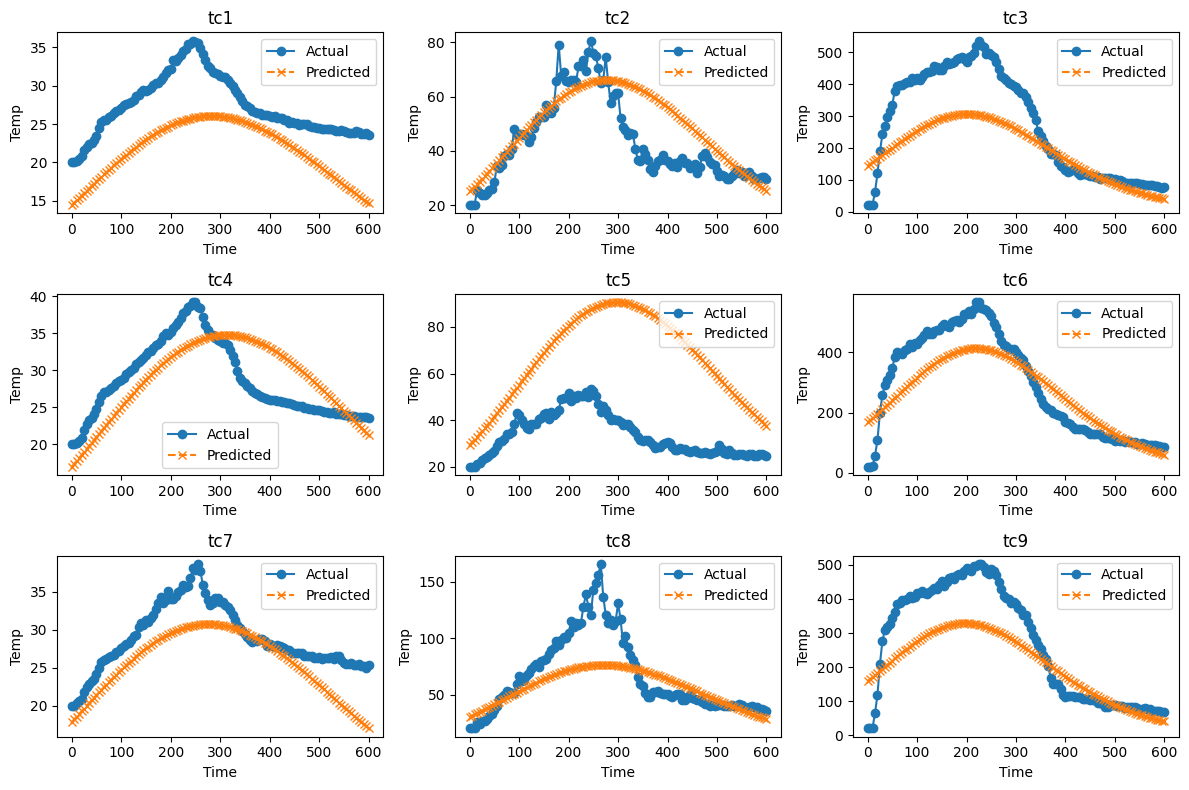


--- Hyperparam Set 30/32 ---
lr=0.0005, layers=[3, 256, 256, 256, 1], activation=silu, pde_weight_start=0.05, use_log=False
tc1: RMSE=14.70
tc2: RMSE=31.42
tc3: RMSE=68.83
tc4: RMSE=20.19
tc5: RMSE=39.99
tc6: RMSE=71.85
tc7: RMSE=13.46
tc8: RMSE=34.14
tc9: RMSE=68.42
Total/System RMSE: 46.11


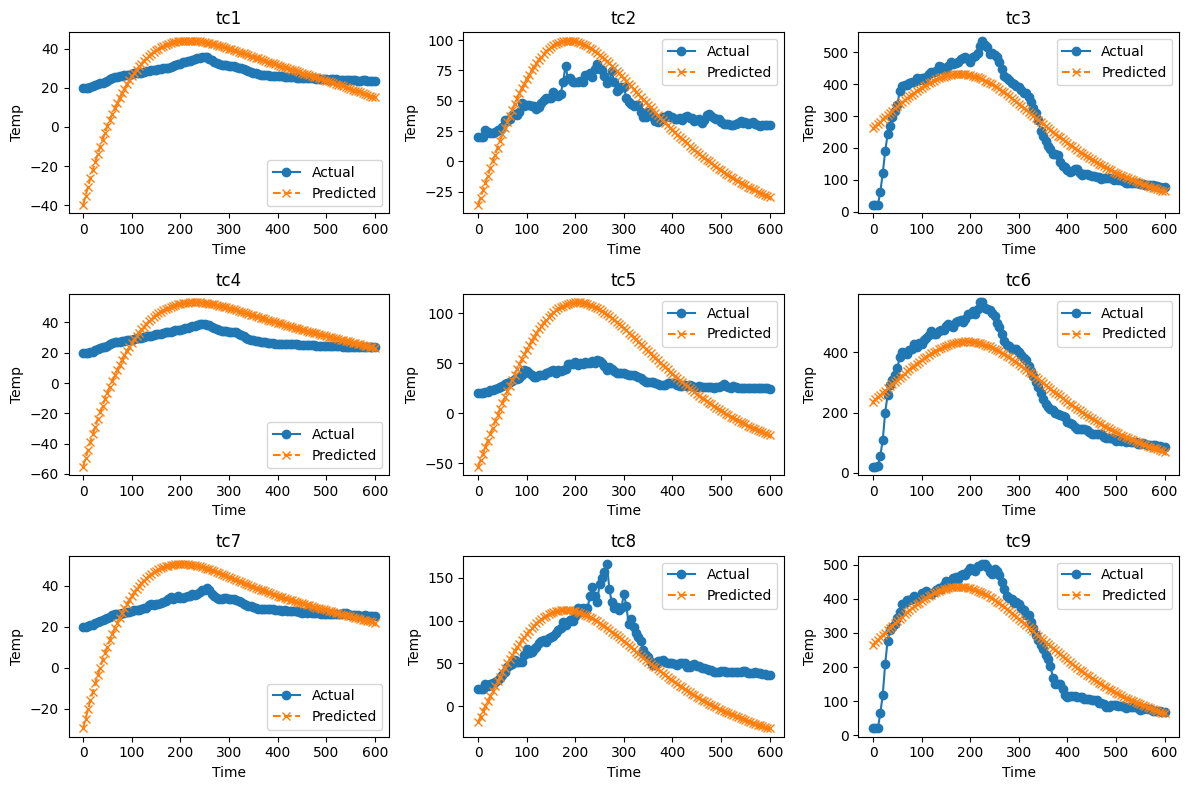


--- Hyperparam Set 31/32 ---
lr=0.0005, layers=[3, 256, 256, 256, 1], activation=silu, pde_weight_start=0.1, use_log=True
tc1: RMSE=6.03
tc2: RMSE=10.86
tc3: RMSE=120.01
tc4: RMSE=4.17
tc5: RMSE=36.30
tc6: RMSE=84.25
tc7: RMSE=3.93
tc8: RMSE=24.87
tc9: RMSE=100.23
Total/System RMSE: 61.17


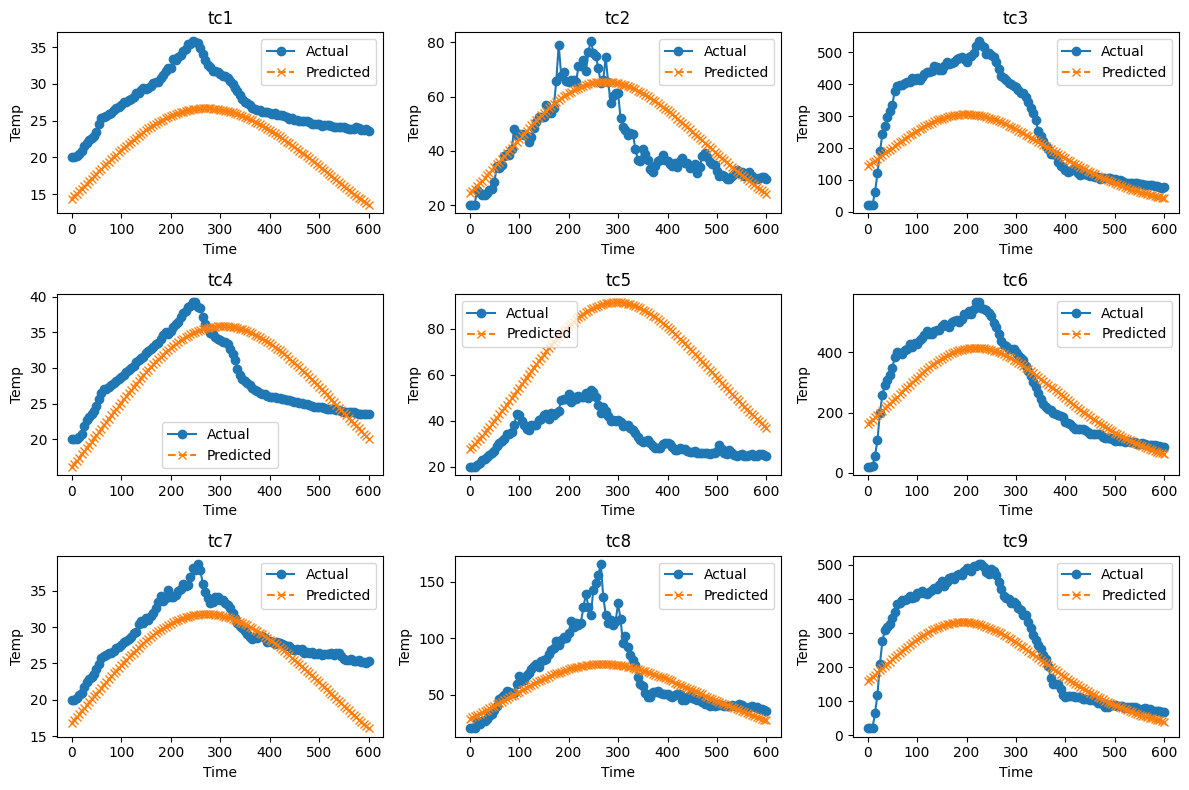


--- Hyperparam Set 32/32 ---
lr=0.0005, layers=[3, 256, 256, 256, 1], activation=silu, pde_weight_start=0.1, use_log=False
tc1: RMSE=27.11
tc2: RMSE=33.97
tc3: RMSE=76.28
tc4: RMSE=13.48
tc5: RMSE=85.70
tc6: RMSE=71.95
tc7: RMSE=22.92
tc8: RMSE=26.90
tc9: RMSE=72.68
Total/System RMSE: 54.71


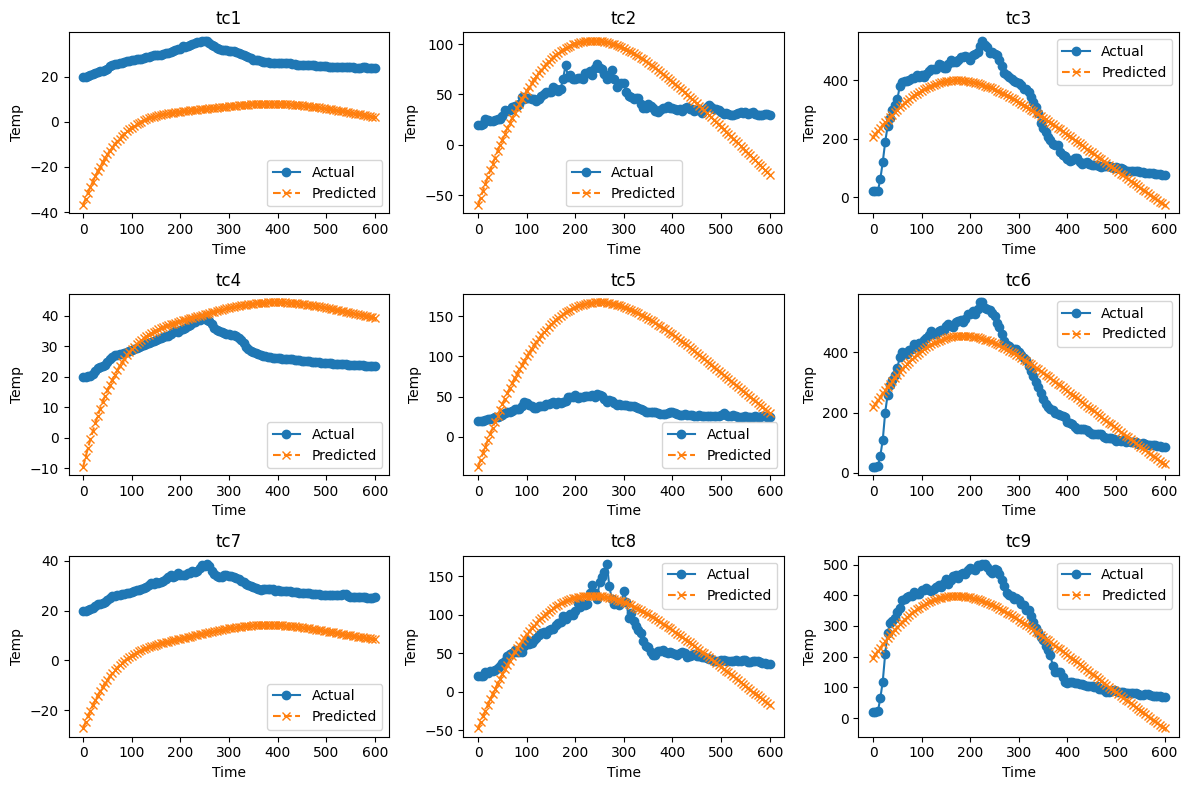


=== Hyperparameter Summary Table ===
        lr                 layers activation  pde_weight_start  use_log  \
0   0.0010  [3, 128, 128, 128, 1]       tanh              0.05     True   
1   0.0010  [3, 128, 128, 128, 1]       tanh              0.05    False   
2   0.0010  [3, 128, 128, 128, 1]       tanh              0.10     True   
3   0.0010  [3, 128, 128, 128, 1]       tanh              0.10    False   
4   0.0010  [3, 128, 128, 128, 1]       silu              0.05     True   
5   0.0010  [3, 128, 128, 128, 1]       silu              0.05    False   
6   0.0010  [3, 128, 128, 128, 1]       silu              0.10     True   
7   0.0010  [3, 128, 128, 128, 1]       silu              0.10    False   
8   0.0010  [3, 256, 256, 256, 1]       tanh              0.05     True   
9   0.0010  [3, 256, 256, 256, 1]       tanh              0.05    False   
10  0.0010  [3, 256, 256, 256, 1]       tanh              0.10     True   
11  0.0010  [3, 256, 256, 256, 1]       tanh              0.10

In [ ]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools

# -----------------------
# Hyperparameter grid
# -----------------------
hyperparams = {
    "lr": [1e-3, 5e-4],
    "layers": [[3,128,128,128,1],[3,256,256,256,1]],
    "activation": ["tanh","silu"],
    "pde_weight_start": [0.05, 0.1],
    "use_log_scale": [True, False]
}

alpha = 1.0
epochs = 2000 


 # adjust for final training
seed = 42

# -----------------------
# Reproducibility
# -----------------------
torch.manual_seed(seed)
np.random.seed(seed)

# -----------------------
# Load data
# -----------------------
with open("data/devpos.json","r") as f:
    sensor_positions = json.load(f)

data = pd.read_csv("data/dfdevc.csv")
records = []
for sensor, pos in sensor_positions.items():
    x,z = pos
    for idx,row in data.iterrows():
        t = row["Time"]
        T = row[sensor]
        records.append([sensor,x,z,t,T])
df_full = pd.DataFrame(records,columns=["sensor","x","z","t","T"])

# -----------------------
# PINN class
# -----------------------
class PINN(nn.Module):
    def __init__(self,layers,activation="tanh"):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i],layers[i+1]))
        self.act = nn.Tanh() if activation=="tanh" else nn.SiLU()
    def forward(self,x):
        out = x
        for layer in self.layers[:-1]:
            out = self.act(layer(out))
        return self.layers[-1](out)

# -----------------------
# PDE residual
# -----------------------
def pde_residual(model, xyz, alpha=1.0):
    xyz.requires_grad_(True)
    T_pred = model(xyz)
    T_t = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred), retain_graph=True, create_graph=True)[0][:,2:3]
    T_x = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred), retain_graph=True, create_graph=True)[0][:,0:1]
    T_xx = torch.autograd.grad(T_x, xyz, grad_outputs=torch.ones_like(T_x), retain_graph=True, create_graph=True)[0][:,0:1]
    T_z = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred), retain_graph=True, create_graph=True)[0][:,1:2]
    T_zz = torch.autograd.grad(T_z, xyz, grad_outputs=torch.ones_like(T_z), retain_graph=True, create_graph=True)[0][:,1:2]
    residual = T_t - alpha*(T_xx + T_zz)
    return residual

# -----------------------
# Helper: normalize data
# -----------------------
def prepare_data(df,use_log):
    df = df.copy()
    if use_log:
        df["T_scaled"] = np.log1p(df["T"])
    else:
        df["T_scaled"] = df["T"]
    df["x_norm"] = (df["x"] - df["x"].min())/(df["x"].max()-df["x"].min())
    df["z_norm"] = (df["z"] - df["z"].min())/(df["z"].max()-df["z"].min())
    df["t_norm"] = df["t"]/df["t"].max()
    X = torch.tensor(df[["x_norm","z_norm","t_norm"]].values,dtype=torch.float32)
    T = torch.tensor(df[["T_scaled"]].values,dtype=torch.float32)
    return X,T,df

# -----------------------
# Adaptive per-sensor weighting
# -----------------------
def get_weights(df):
    sensor_counts = df.groupby("sensor").size()
    weights = {s:1.0/len(sensor_counts) for s in sensor_counts.keys()}
    weights_tensor = torch.tensor(df["sensor"].map(weights).values,dtype=torch.float32).unsqueeze(1)
    return weights, weights_tensor

# -----------------------
# Training function
# -----------------------
def train_model(model,X,T,df,pde_weight_start,epochs,alpha,lr):
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    sensor_weights, weights_tensor = get_weights(df)
    for epoch in range(epochs+1):
        optimizer.zero_grad()
        T_pred = model(X)
        
        # Update adaptive weights every 100 epochs
        if epoch % 100 == 0:
            with torch.no_grad():
                df["T_pred_tmp"] = T_pred.numpy()
                for s in sensor_weights.keys():
                    s_data = df[df["sensor"]==s]
                    mse_s = ((s_data["T_scaled"]-s_data["T_pred_tmp"])**2).mean()
                    sensor_weights[s] = 0.5 + mse_s / mse_s.sum()
                total = sum(sensor_weights.values())
                sensor_weights = {k:v/total for k,v in sensor_weights.items()}
                weights_tensor = torch.tensor(df["sensor"].map(sensor_weights).values,dtype=torch.float32).unsqueeze(1)
        
        data_loss = torch.mean(weights_tensor*(T_pred-T)**2)
        residual = pde_residual(model,X,alpha)
        pde_weight = pde_weight_start + (1-pde_weight_start)*(epoch/epochs)
        pde_loss = pde_weight*torch.mean(residual**2)
        loss = data_loss + pde_loss
        loss.backward()
        optimizer.step()
        
    return model

# -----------------------
# Updated evaluate_model to include total/system RMSE
# -----------------------
def evaluate_model(model, X, df, use_log):
    model.eval()
    with torch.no_grad():
        T_pred_scaled = model(X).numpy()
        if use_log:
            T_pred = np.expm1(T_pred_scaled)
        else:
            T_pred = T_pred_scaled
        df["T_pred"] = T_pred

    sensors = list(df["sensor"].unique())
    sensor_rmse = {}
    all_errors = []
    for s in sensors:
        s_data = df[df["sensor"]==s]
        errors = s_data["T"] - s_data["T_pred"]
        mse = (errors**2).mean()
        sensor_rmse[s] = np.sqrt(mse)
        all_errors.extend(errors.tolist())

    total_rmse = np.sqrt(np.mean(np.array(all_errors)**2))
    return df, sensor_rmse, total_rmse

# -----------------------
# Update summary storage in hyperparameter loop
# -----------------------
summary_results = []

for idx, (lr,layers,activation,pde_weight_start,use_log) in enumerate(param_combinations):
    print(f"\n--- Hyperparam Set {idx+1}/{len(param_combinations)} ---")
    print(f"lr={lr}, layers={layers}, activation={activation}, pde_weight_start={pde_weight_start}, use_log={use_log}")
    
    X,T,df = prepare_data(df_full,use_log)
    model = PINN(layers,activation)
    
    model = train_model(model,X,T,df,pde_weight_start,epochs,alpha,lr)
    
    df_eval, sensor_rmse, total_rmse = evaluate_model(model,X,df,use_log)
    
    # store summary including total RMSE
    summary_results.append({
        "lr": lr,
        "layers": layers,
        "activation": activation,
        "pde_weight_start": pde_weight_start,
        "use_log": use_log,
        "total_rmse": total_rmse,
        **sensor_rmse
    })
    
    # Print RMSE for this combination
    for s,rmse in sensor_rmse.items():
        print(f"{s}: RMSE={rmse:.2f}")
    print(f"Total/System RMSE: {total_rmse:.2f}")
    
    # Plot predictions (optional, same as before)

    
    # Plot predictions
    plt.figure(figsize=(12,8))
    sensors_plot = list(sensor_positions.keys())
    for i,sensor in enumerate(sensors_plot):
        plt.subplot(3,3,i+1)
        x_s,z_s = sensor_positions[sensor]
        s_data = df_eval[(df_eval["x"]==x_s)&(df_eval["z"]==z_s)]
        plt.plot(s_data["t"],s_data["T"],'o-',label="Actual")
        plt.plot(s_data["t"],s_data["T_pred"],'x--',label="Predicted")
        plt.title(sensor)
        plt.xlabel("Time")
        plt.ylabel("Temp")
        plt.legend()
    plt.tight_layout()









    plt.show()

# -----------------------
# Summary table
# -----------------------
summary_df = pd.DataFrame(summary_results)
print("\n=== Hyperparameter Summary Table ===")
print(summary_df)
summary_df.to_csv("hyperparam_summary.csv",index=False)
print("Summary saved to hyperparam_summary.csv")


Training with loss tracking...
Epoch 0 | Data Loss: 1.9237 | PDE Loss: 0.0001 | Total Loss: 1.9239 | RMSE: 4.1610
Epoch 500 | Data Loss: 0.0308 | PDE Loss: 0.0005 | Total Loss: 0.0313 | RMSE: 0.5269
Epoch 1000 | Data Loss: 0.0146 | PDE Loss: 0.0077 | Total Loss: 0.0223 | RMSE: 0.3620
Epoch 1500 | Data Loss: 0.0129 | PDE Loss: 0.0008 | Total Loss: 0.0136 | RMSE: 0.3405
Epoch 2000 | Data Loss: 0.0119 | PDE Loss: 0.0004 | Total Loss: 0.0123 | RMSE: 0.3275
Epoch 2500 | Data Loss: 0.0109 | PDE Loss: 0.0008 | Total Loss: 0.0117 | RMSE: 0.3127
Epoch 3000 | Data Loss: 0.0101 | PDE Loss: 0.0004 | Total Loss: 0.0104 | RMSE: 0.3009
Epoch 3500 | Data Loss: 0.0099 | PDE Loss: 0.0003 | Total Loss: 0.0102 | RMSE: 0.2985
Epoch 4000 | Data Loss: 0.0088 | PDE Loss: 0.0143 | Total Loss: 0.0231 | RMSE: 0.2813
Epoch 4500 | Data Loss: 0.0079 | PDE Loss: 0.0000 | Total Loss: 0.0079 | RMSE: 0.2662
Epoch 5000 | Data Loss: 0.0073 | PDE Loss: 0.0648 | Total Loss: 0.0722 | RMSE: 0.2567


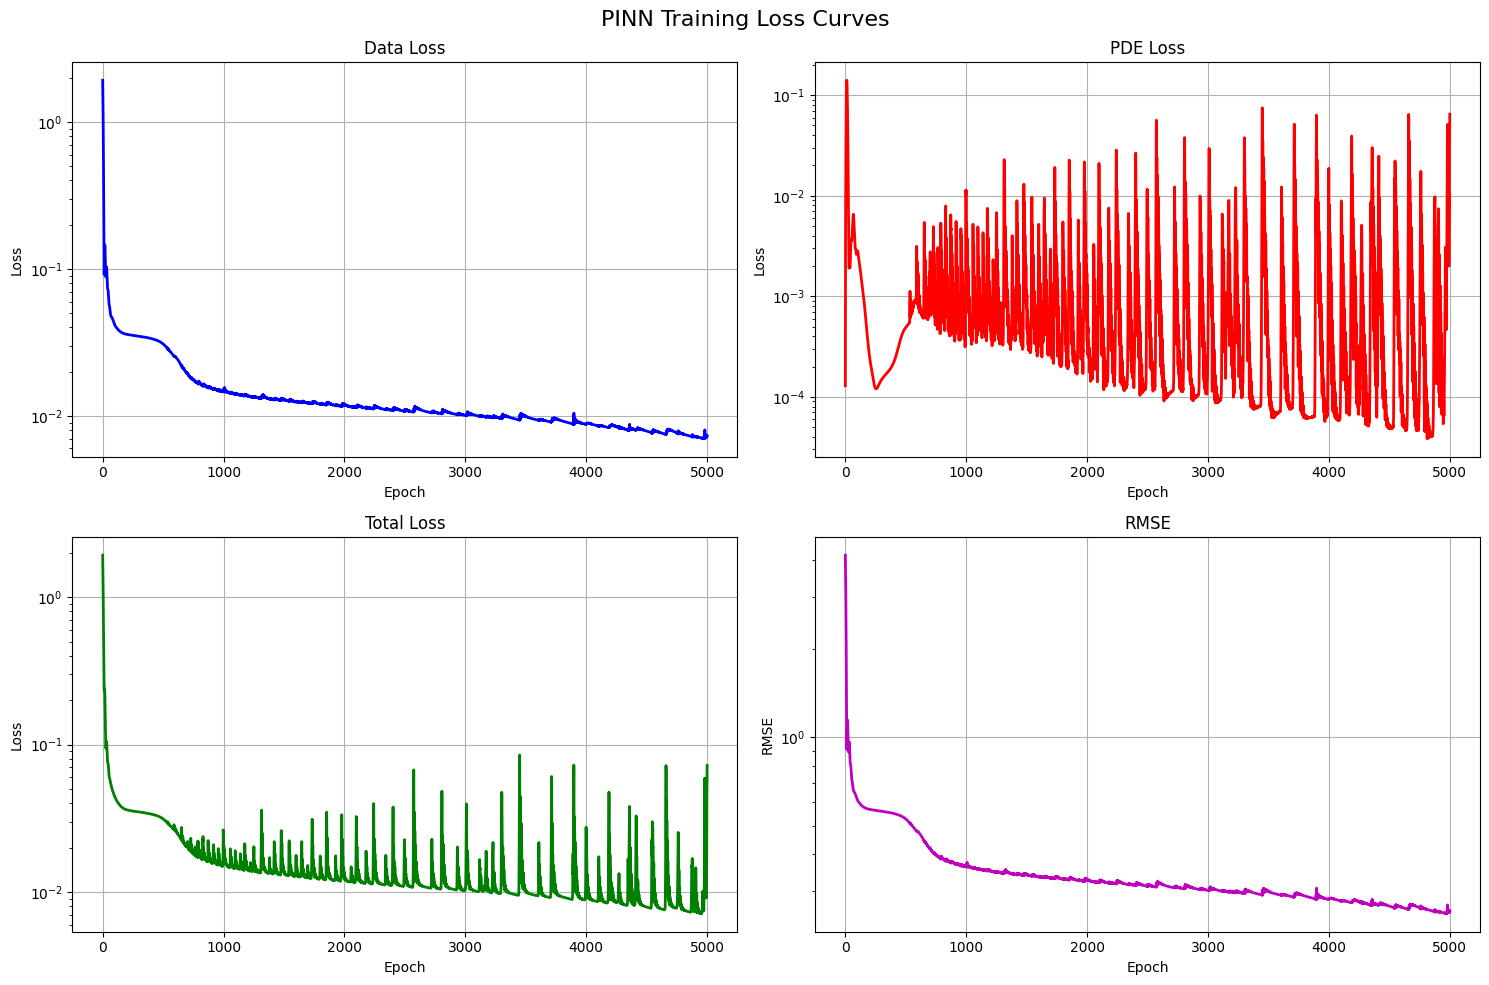

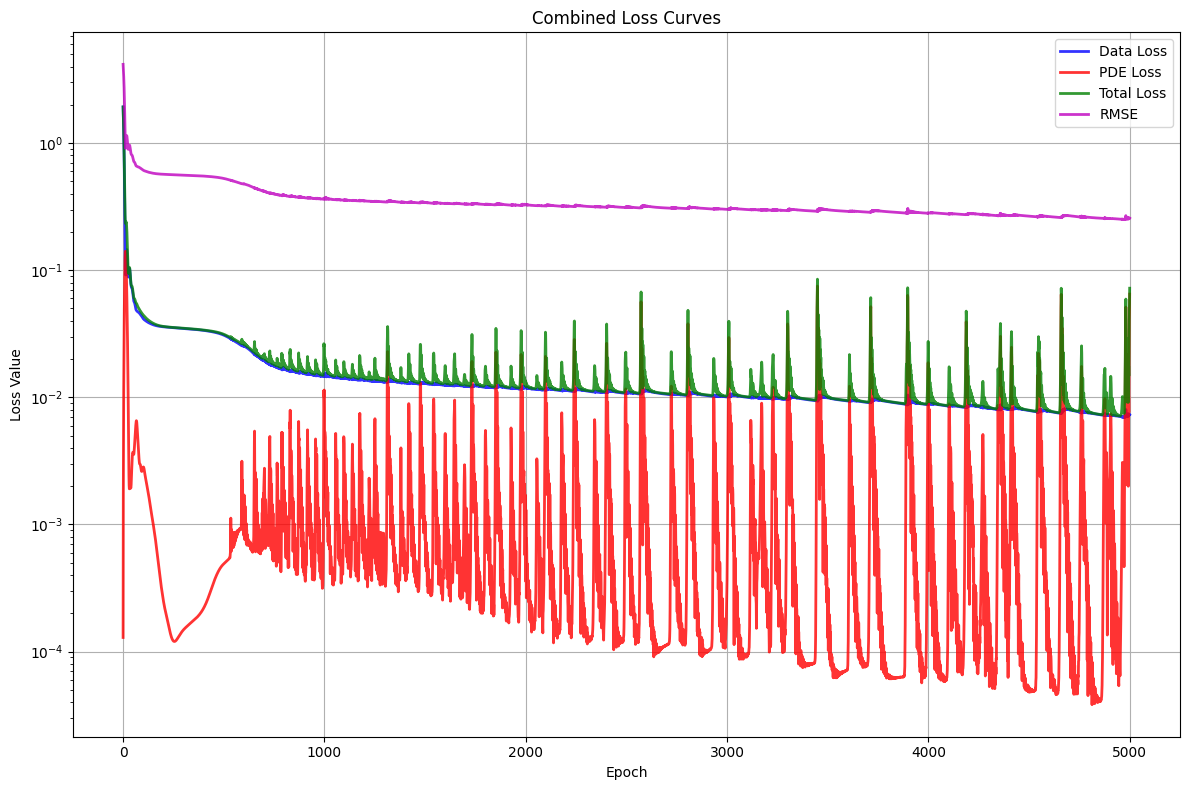


=== Final Loss Values ===
Final Data Loss: 0.007325
Final PDE Loss: 0.064836
Final Total Loss: 0.072160
Final RMSE: 0.256750

=== Loss Reduction ===
Data Loss Reduction: 1.923739 → 0.007325
PDE Loss Reduction: 0.000129 → 0.064836
Total Loss Reduction: 1.923868 → 0.072160
RMSE Reduction: 4.160968 → 0.256750
Loss history saved to loss_history.json


In [4]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# -----------------------
# Load Data (if not already loaded)
# -----------------------
with open("data/devpos.json", "r") as f:
    sensor_positions = json.load(f)

data = pd.read_csv("data/dfdevc.csv")
records = []
for sensor, pos in sensor_positions.items():
    x, z = pos
    for idx, row in data.iterrows():
        t = row["Time"]
        T = row[sensor]
        records.append([sensor, x, z, t, T])
df_full = pd.DataFrame(records, columns=["sensor", "x", "z", "t", "T"])

# -----------------------
# PINN Class
# -----------------------
class PINN(nn.Module):
    def __init__(self, layers, activation="tanh"):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.act = nn.Tanh() if activation=="tanh" else nn.SiLU()

    def forward(self, x):
        out = x
        for layer in self.layers[:-1]:
            out = self.act(layer(out))
        return self.layers[-1](out)

# -----------------------
# PDE Residual Function
# -----------------------
def pde_residual(model, xyz, alpha=1.0):
    xyz.requires_grad_(True)
    T_pred = model(xyz)
    T_t = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred), retain_graph=True, create_graph=True)[0][:,2:3]
    T_x = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred), retain_graph=True, create_graph=True)[0][:,0:1]
    T_xx = torch.autograd.grad(T_x, xyz, grad_outputs=torch.ones_like(T_x), retain_graph=True, create_graph=True)[0][:,0:1]
    T_z = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred), retain_graph=True, create_graph=True)[0][:,1:2]
    T_zz = torch.autograd.grad(T_z, xyz, grad_outputs=torch.ones_like(T_z), retain_graph=True, create_graph=True)[0][:,1:2]
    residual = T_t - alpha*(T_xx + T_zz)
    return residual

# -----------------------
# Helper: Normalize Data
# -----------------------
def prepare_data(df, use_log):
    df = df.copy()
    if use_log:
        df["T_scaled"] = np.log1p(df["T"])
    else:
        df["T_scaled"] = df["T"]
    df["x_norm"] = (df["x"] - df["x"].min())/(df["x"].max()-df["x"].min())
    df["z_norm"] = (df["z"] - df["z"].min())/(df["z"].max()-df["z"].min())
    df["t_norm"] = df["t"]/df["t"].max()
    X = torch.tensor(df[["x_norm","z_norm","t_norm"]].values, dtype=torch.float32)
    T = torch.tensor(df[["T_scaled"]].values, dtype=torch.float32)
    return X, T, df

# -----------------------
# Adaptive Per-Sensor Weighting
# -----------------------
def get_weights(df):
    sensor_counts = df.groupby("sensor").size()
    weights = {s: 1.0/len(sensor_counts) for s in sensor_counts.keys()}
    weights_tensor = torch.tensor(df["sensor"].map(weights).values, dtype=torch.float32).unsqueeze(1)
    return weights, weights_tensor

# -----------------------
# Enhanced Training Loop with Loss Tracking
# -----------------------
def train_model_with_loss_tracking(model, X, T, df, pde_weight_start, epochs, alpha, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    sensor_weights, weights_tensor = get_weights(df)
    
    # Initialize loss tracking lists
    epoch_list = []
    data_losses = []
    pde_losses = []
    total_losses = []
    rmse_values = []
    
    for epoch in range(epochs + 1):
        optimizer.zero_grad()
        T_pred = model(X)
        
        # Update adaptive weights every 100 epochs
        if epoch % 100 == 0:
            with torch.no_grad():
                df["T_pred_tmp"] = T_pred.numpy()
                for s in sensor_weights.keys():
                    s_data = df[df["sensor"] == s]
                    mse_s = ((s_data["T_scaled"] - s_data["T_pred_tmp"])**2).mean()
                    sensor_weights[s] = 0.5 + mse_s / mse_s.sum()
                total = sum(sensor_weights.values())
                sensor_weights = {k: v/total for k, v in sensor_weights.items()}
                weights_tensor = torch.tensor(df["sensor"].map(sensor_weights).values, dtype=torch.float32).unsqueeze(1)
        
        # Calculate losses
        data_loss = torch.mean(weights_tensor * (T_pred - T)**2)
        residual = pde_residual(model, X, alpha)
        pde_weight = pde_weight_start + (1 - pde_weight_start) * (epoch / epochs)
        pde_loss = pde_weight * torch.mean(residual**2)
        total_loss = data_loss + pde_loss
        
        # Calculate RMSE
        mse = torch.mean((T_pred - T)**2).item()
        rmse = np.sqrt(mse)
        
        # Store losses
        epoch_list.append(epoch)
        data_losses.append(data_loss.item())
        pde_losses.append(pde_loss.item())
        total_losses.append(total_loss.item())
        rmse_values.append(rmse)
        
        total_loss.backward()
        optimizer.step()
        
        # Print progress
        if epoch % 500 == 0:
            print(f"Epoch {epoch} | Data Loss: {data_loss.item():.4f} | PDE Loss: {pde_loss.item():.4f} | Total Loss: {total_loss.item():.4f} | RMSE: {rmse:.4f}")
    
    return model, {
        'epochs': epoch_list,
        'data_losses': data_losses,
        'pde_losses': pde_losses,
        'total_losses': total_losses,
        'rmse_values': rmse_values
    }

# -----------------------
# Plot Loss Curves
# -----------------------
def plot_loss_curves(loss_history, title="Training Loss Curves"):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = loss_history['epochs']
    
    # Data Loss
    axes[0, 0].plot(epochs, loss_history['data_losses'], 'b-', linewidth=2)
    axes[0, 0].set_title('Data Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True)
    axes[0, 0].set_yscale('log')
    
    # PDE Loss
    axes[0, 1].plot(epochs, loss_history['pde_losses'], 'r-', linewidth=2)
    axes[0, 1].set_title('PDE Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True)
    axes[0, 1].set_yscale('log')
    
    # Total Loss
    axes[1, 0].plot(epochs, loss_history['total_losses'], 'g-', linewidth=2)
    axes[1, 0].set_title('Total Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].grid(True)
    axes[1, 0].set_yscale('log')
    
    # RMSE
    axes[1, 1].plot(epochs, loss_history['rmse_values'], 'm-', linewidth=2)
    axes[1, 1].set_title('RMSE')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('RMSE')
    axes[1, 1].grid(True)
    axes[1, 1].set_yscale('log')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# -----------------------
# Combined Loss Plot
# -----------------------
def plot_combined_loss_curves(loss_history, title="Combined Loss Curves"):
    plt.figure(figsize=(12, 8))
    
    epochs = loss_history['epochs']
    
    plt.plot(epochs, loss_history['data_losses'], 'b-', linewidth=2, label='Data Loss', alpha=0.8)
    plt.plot(epochs, loss_history['pde_losses'], 'r-', linewidth=2, label='PDE Loss', alpha=0.8)
    plt.plot(epochs, loss_history['total_losses'], 'g-', linewidth=2, label='Total Loss', alpha=0.8)
    plt.plot(epochs, loss_history['rmse_values'], 'm-', linewidth=2, label='RMSE', alpha=0.8)
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()

# -----------------------
# Print Final Loss Values
# -----------------------
def print_final_losses(loss_history):
    print("\n=== Final Loss Values ===")
    print(f"Final Data Loss: {loss_history['data_losses'][-1]:.6f}")
    print(f"Final PDE Loss: {loss_history['pde_losses'][-1]:.6f}")
    print(f"Final Total Loss: {loss_history['total_losses'][-1]:.6f}")
    print(f"Final RMSE: {loss_history['rmse_values'][-1]:.6f}")
    
    print(f"\n=== Loss Reduction ===")
    print(f"Data Loss Reduction: {loss_history['data_losses'][0]:.6f} → {loss_history['data_losses'][-1]:.6f}")
    print(f"PDE Loss Reduction: {loss_history['pde_losses'][0]:.6f} → {loss_history['pde_losses'][-1]:.6f}")
    print(f"Total Loss Reduction: {loss_history['total_losses'][0]:.6f} → {loss_history['total_losses'][-1]:.6f}")
    print(f"RMSE Reduction: {loss_history['rmse_values'][0]:.6f} → {loss_history['rmse_values'][-1]:.6f}")

# -----------------------
# Example Usage with Your Best Configuration
# -----------------------
best_config = {
    "lr": 0.001,
    "layers": [3, 128, 128, 128, 1],
    "activation": "tanh",
    "pde_weight_start": 0.05,
    "use_log": True
}

print("Training with loss tracking...")
X, T, df = prepare_data(df_full, best_config["use_log"])
model = PINN(best_config["layers"], best_config["activation"])

# Train with loss tracking
trained_model, loss_history = train_model_with_loss_tracking(
    model, X, T, df, 
    best_config["pde_weight_start"], 
    5000,  # epochs
    1.0,   # alpha
    best_config["lr"]
)

# Plot loss curves
plot_loss_curves(loss_history, "PINN Training Loss Curves")
plot_combined_loss_curves(loss_history, "Combined Loss Curves")

# Print final values
print_final_losses(loss_history)

# -----------------------
# Save Loss History
# -----------------------
with open('loss_history.json', 'w') as f:
    json.dump(loss_history, f, indent=2)
print("Loss history saved to loss_history.json")


--- Training with alpha=0.5 ---
Alpha=0.5 | Total RMSE=13.404
tc1: RMSE=0.824
tc2: RMSE=4.034
tc3: RMSE=21.465
tc4: RMSE=1.682
tc5: RMSE=2.531
tc6: RMSE=19.941
tc7: RMSE=1.308
tc8: RMSE=10.831
tc9: RMSE=24.769


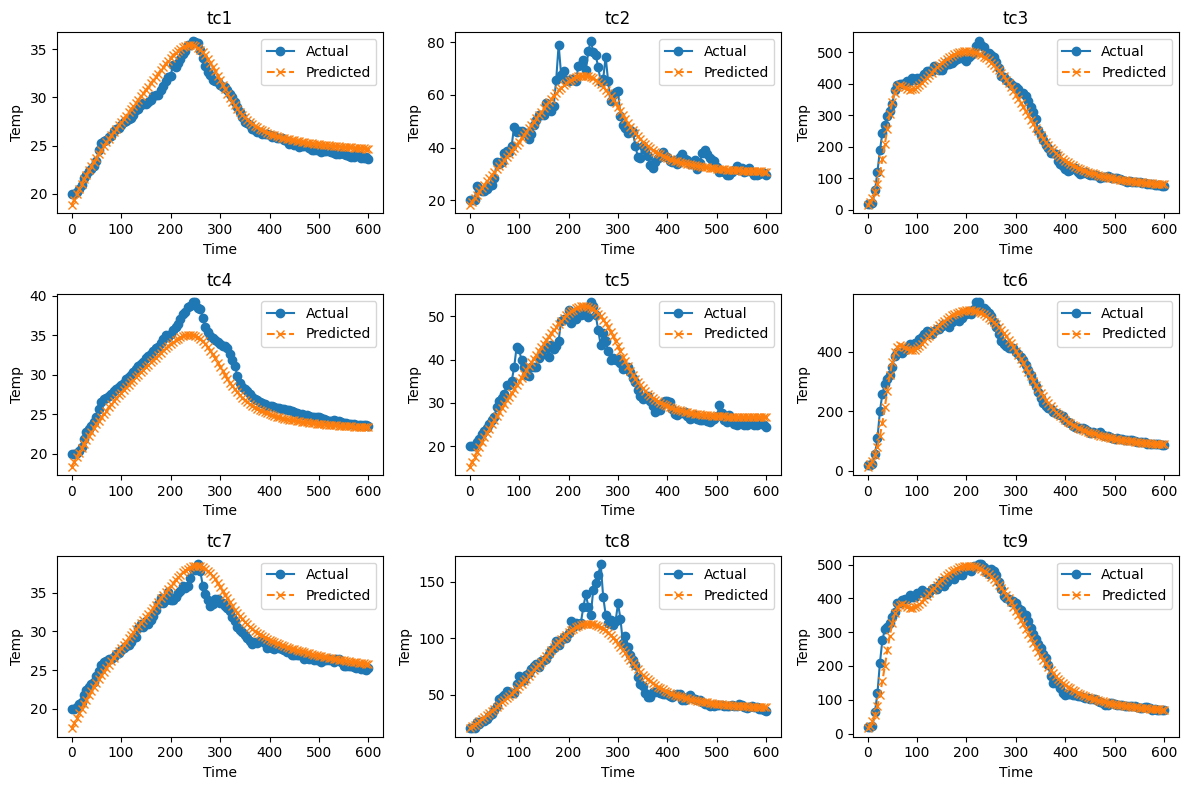


--- Training with alpha=1.0 ---
Alpha=1.0 | Total RMSE=17.141
tc1: RMSE=2.281
tc2: RMSE=4.358
tc3: RMSE=25.545
tc4: RMSE=1.255
tc5: RMSE=4.252
tc6: RMSE=30.573
tc7: RMSE=2.416
tc8: RMSE=9.606
tc9: RMSE=30.251


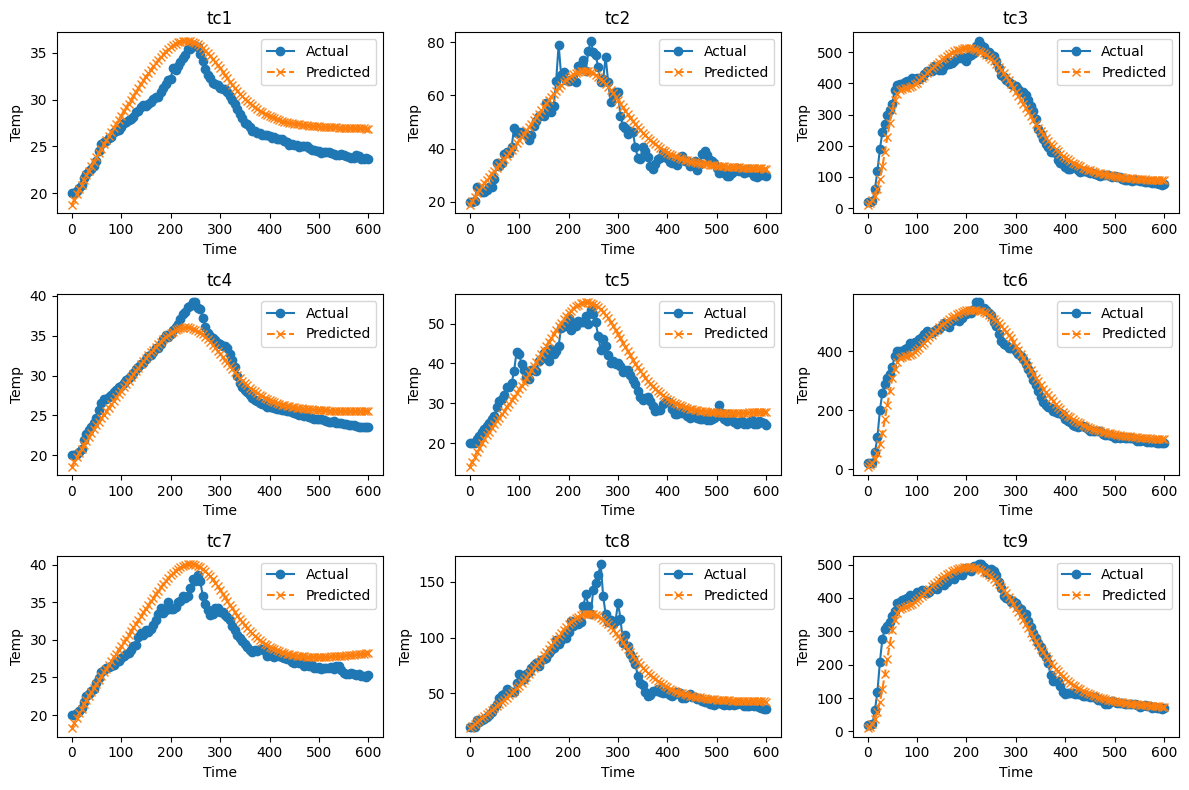


--- Training with alpha=2.0 ---
Alpha=2.0 | Total RMSE=15.302
tc1: RMSE=1.895
tc2: RMSE=4.752
tc3: RMSE=23.222
tc4: RMSE=1.033
tc5: RMSE=3.720
tc6: RMSE=28.025
tc7: RMSE=2.098
tc8: RMSE=11.468
tc9: RMSE=24.611


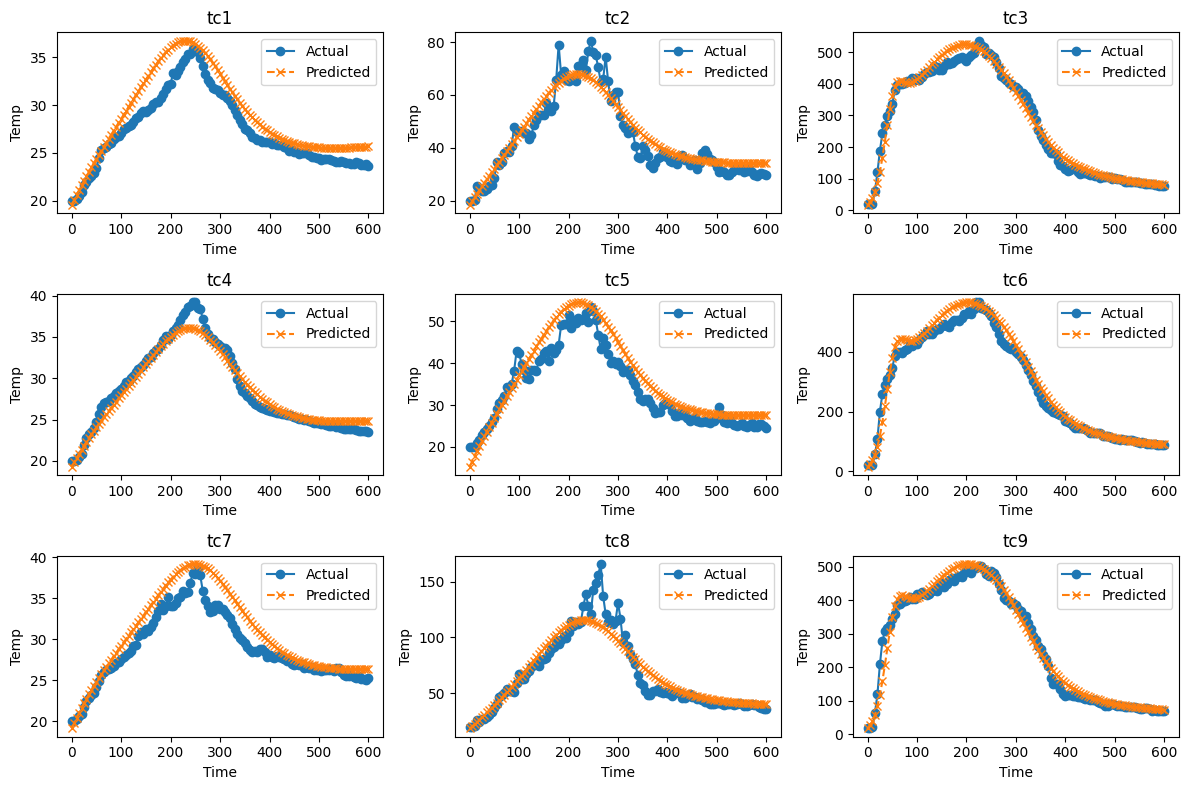


--- Training with alpha=1e-05 ---
Alpha=1e-05 | Total RMSE=15.486
tc1: RMSE=1.303
tc2: RMSE=4.323
tc3: RMSE=26.489
tc4: RMSE=1.070
tc5: RMSE=3.210
tc6: RMSE=21.387
tc7: RMSE=1.612
tc8: RMSE=10.508
tc9: RMSE=29.233


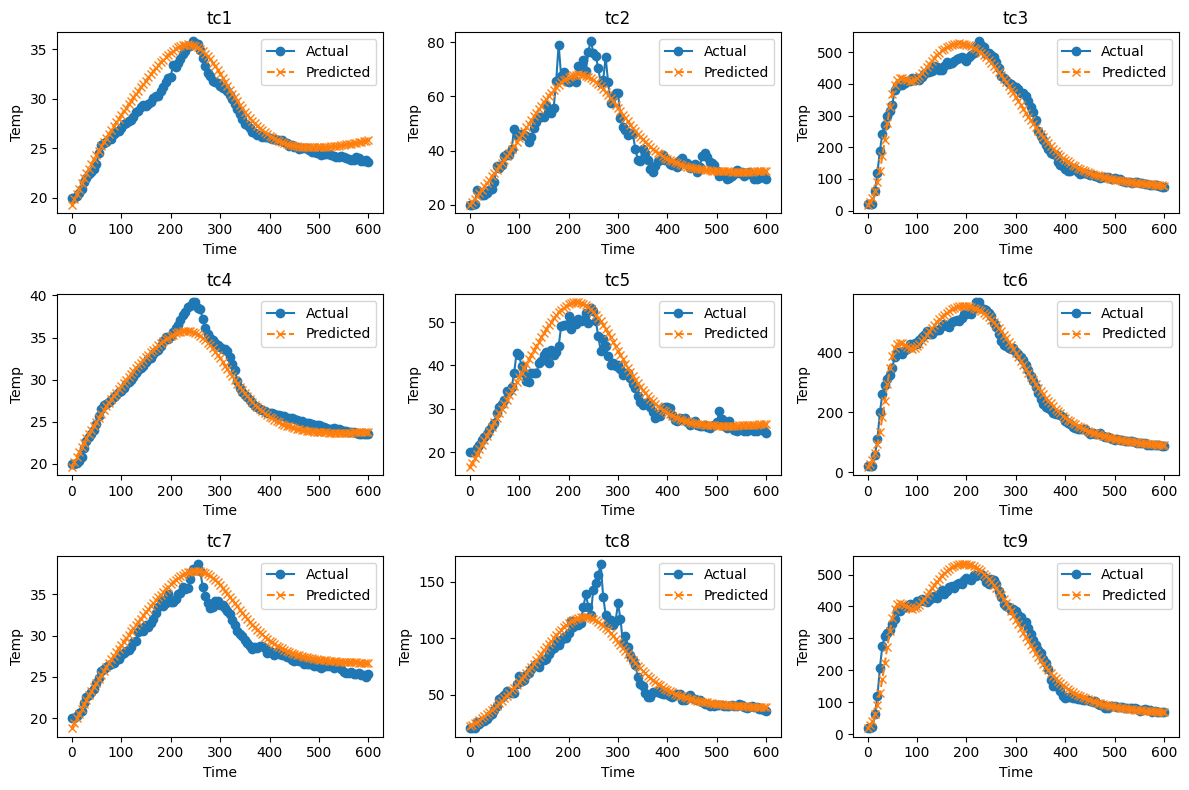


--- Training with alpha=2e-05 ---
Alpha=2e-05 | Total RMSE=12.747
tc1: RMSE=0.803
tc2: RMSE=4.497
tc3: RMSE=21.522
tc4: RMSE=2.207
tc5: RMSE=2.327
tc6: RMSE=19.868
tc7: RMSE=0.980
tc8: RMSE=11.257
tc9: RMSE=21.109


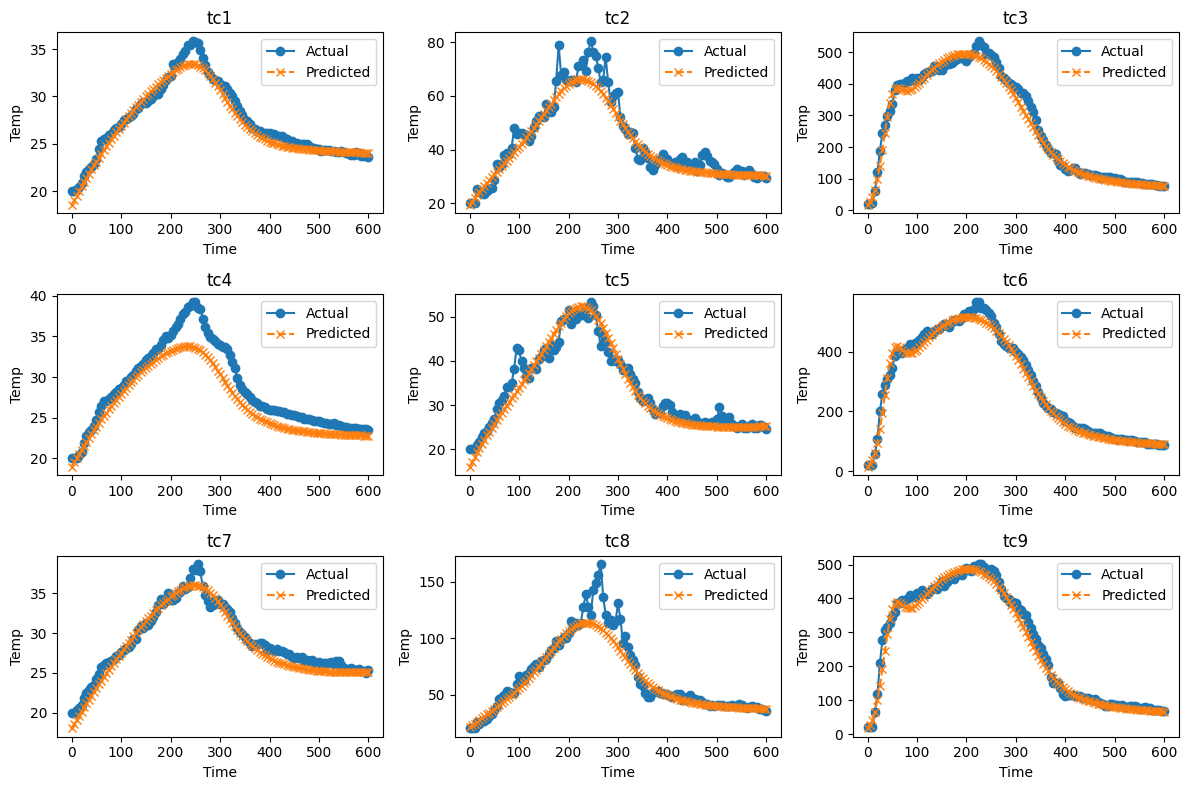


--- Training with alpha=1.2e-05 ---
Alpha=1.2e-05 | Total RMSE=12.690
tc1: RMSE=0.678
tc2: RMSE=4.571
tc3: RMSE=20.547
tc4: RMSE=2.548
tc5: RMSE=2.129
tc6: RMSE=20.727
tc7: RMSE=1.108
tc8: RMSE=11.059
tc9: RMSE=21.014


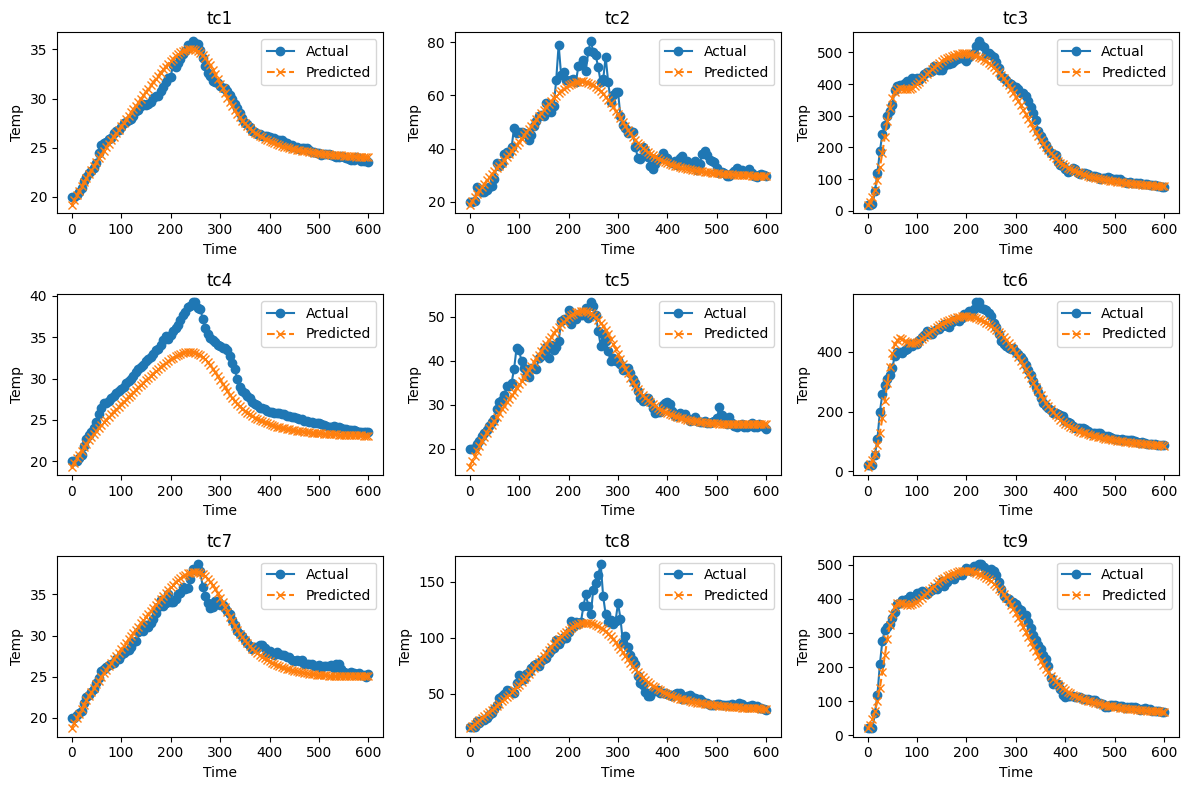


--- Training with alpha=1.5e-05 ---
Alpha=1.5e-05 | Total RMSE=15.719
tc1: RMSE=2.303
tc2: RMSE=4.128
tc3: RMSE=21.053
tc4: RMSE=1.211
tc5: RMSE=4.405
tc6: RMSE=32.481
tc7: RMSE=2.702
tc8: RMSE=8.998
tc9: RMSE=24.375


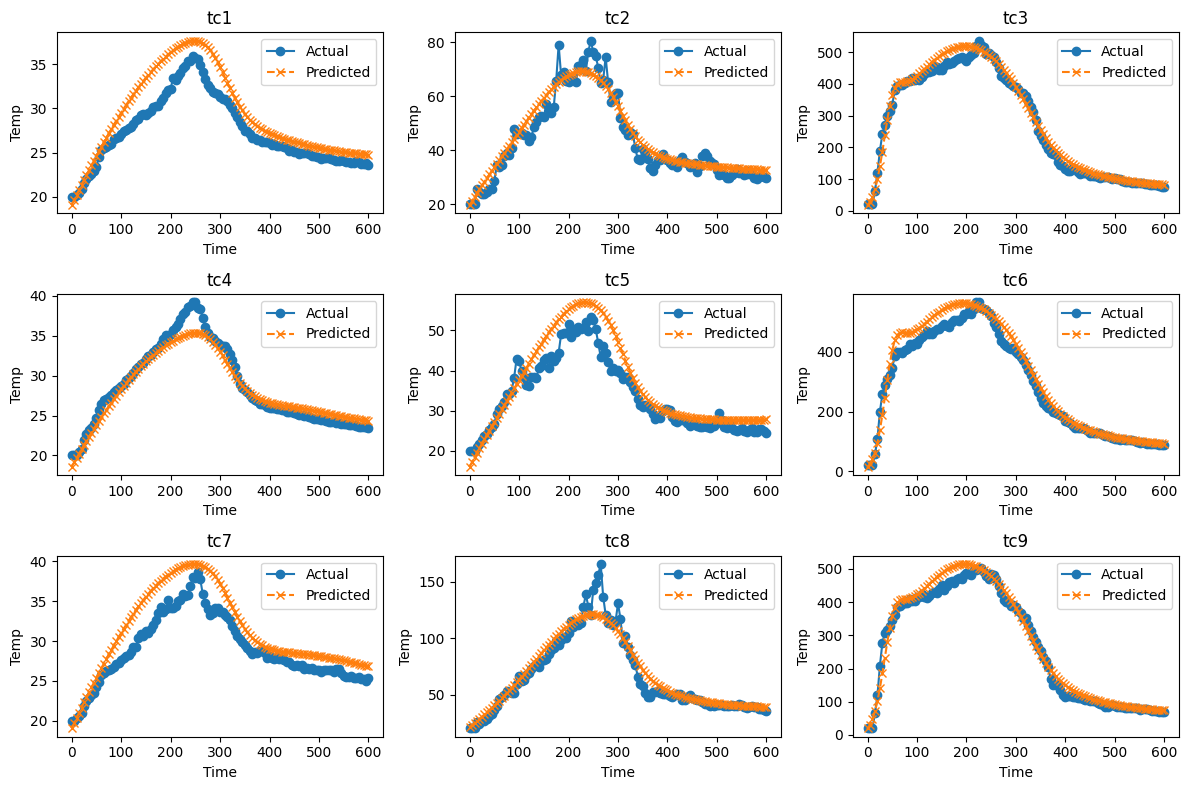


--- Training with alpha=1.9e-05 ---
Alpha=1.9e-05 | Total RMSE=11.226
tc1: RMSE=0.864
tc2: RMSE=3.827
tc3: RMSE=16.699
tc4: RMSE=1.106
tc5: RMSE=2.373
tc6: RMSE=19.382
tc7: RMSE=1.066
tc8: RMSE=9.991
tc9: RMSE=18.880


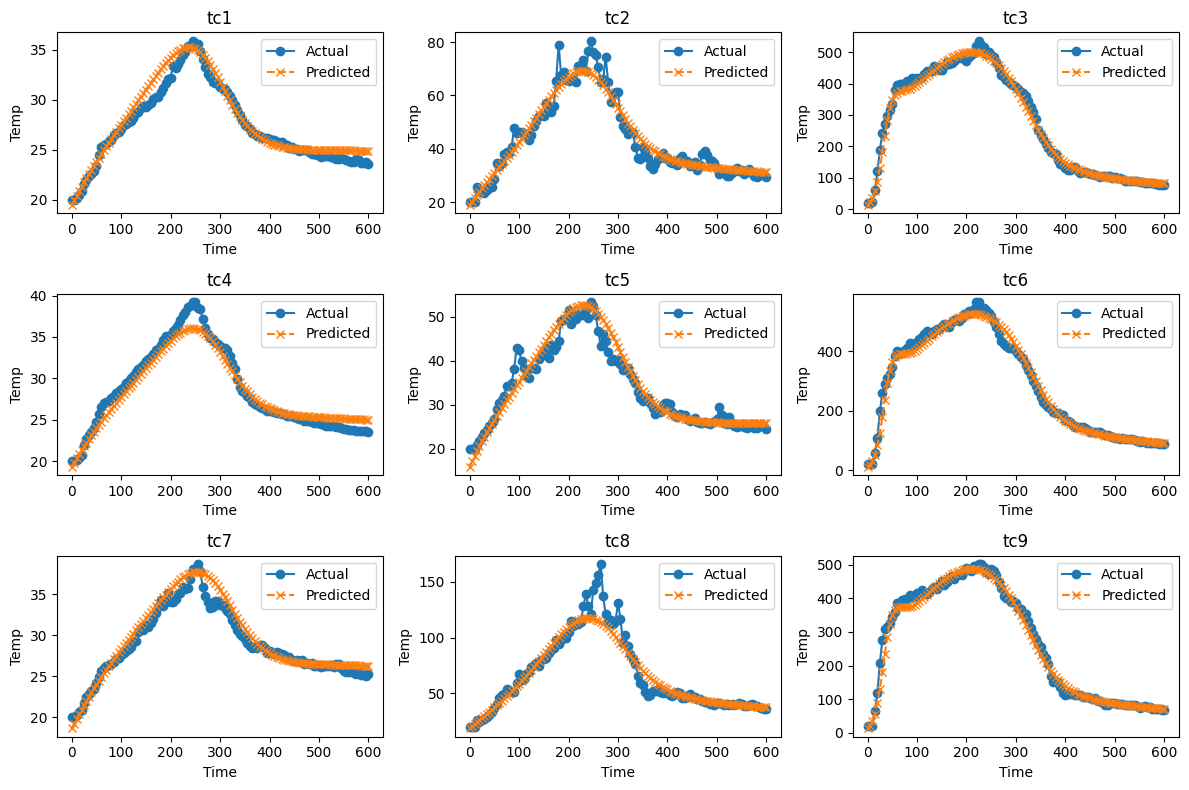

In [6]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# -----------------------
# Baseline hyperparameters
# -----------------------
lr = 0.001
layers = [3,128,128,128,1]
activation = "tanh"
epochs = 500
seed = 42
pde_weight_min = 1e-6
pde_weight_max = 0.05
pde_ramp_power = 2.0
use_log = True

torch.manual_seed(seed)
np.random.seed(seed)

# -----------------------
# Load data
# -----------------------
with open("data/devpos.json","r") as f:
    sensor_positions = json.load(f)
data = pd.read_csv("data/dfdevc.csv")
records = []
for sensor,pos in sensor_positions.items():
    x,z = pos
    for idx,row in data.iterrows():
        t = row["Time"]
        T = row[sensor]
        records.append([sensor,x,z,t,T])
df_full = pd.DataFrame(records,columns=["sensor","x","z","t","T"])

# -----------------------
# PINN
# -----------------------
class PINN(nn.Module):
    def __init__(self,layers,activation="tanh"):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i],layers[i+1]))
        self.act = nn.Tanh() if activation=="tanh" else nn.SiLU()
    def forward(self,x):
        out = x
        for layer in self.layers[:-1]:
            out = self.act(layer(out))
        return self.layers[-1](out)

# -----------------------
# PDE residual
# -----------------------
def pde_residual(model, xyz, alpha):
    xyz.requires_grad_(True)
    T_pred = model(xyz)
    grads = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred),
                                retain_graph=True, create_graph=True)[0]
    T_x = grads[:,0:1]; T_z = grads[:,1:2]; T_t = grads[:,2:3]
    T_xx = torch.autograd.grad(T_x, xyz, grad_outputs=torch.ones_like(T_x),
                               retain_graph=True, create_graph=True)[0][:,0:1]
    T_zz = torch.autograd.grad(T_z, xyz, grad_outputs=torch.ones_like(T_z),
                               retain_graph=True, create_graph=True)[0][:,1:2]
    return T_t - alpha*(T_xx + T_zz)

# -----------------------
# Prepare data
# -----------------------
def prepare_data(df,use_log=True):
    df = df.copy()
    if use_log:
        df["T_scaled"] = np.log1p(df["T"])
    else:
        df["T_scaled"] = df["T"]
    df["x_norm"] = (df["x"] - df["x"].min())/(df["x"].max()-df["x"].min())
    df["z_norm"] = (df["z"] - df["z"].min())/(df["z"].max()-df["z"].min())
    df["t_norm"] = df["t"]/df["t"].max()
    X = torch.tensor(df[["x_norm","z_norm","t_norm"]].values,dtype=torch.float32)
    T = torch.tensor(df[["T_scaled"]].values,dtype=torch.float32)
    return X,T,df

# -----------------------
# PDE weight schedule
# -----------------------
def pde_weight_schedule(epoch, epochs, wmin, wmax, power):
    frac = (epoch/epochs)**power
    return wmin + (wmax - wmin) * frac

# -----------------------
# Adaptive per-sensor weighting
# -----------------------
def get_weights(df):
    sensor_counts = df.groupby("sensor").size()
    weights = {s:1.0/len(sensor_counts) for s in sensor_counts.keys()}
    weights_tensor = torch.tensor(df["sensor"].map(weights).values,dtype=torch.float32).unsqueeze(1)
    return weights, weights_tensor

# -----------------------
# Training function
# -----------------------
def train_model(model, X, T, df, epochs, alpha, w_data, w_pde):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    running_data = 0.0
    running_pde = 0.0
    ema_decay = 0.99
    sensor_weights, weights_tensor = get_weights(df)

    log = {"epoch":[],"data_loss":[],"pde_loss":[],"total_loss":[],"mean_residual":[],"pde_weight":[]}

    for epoch in range(epochs+1):
        optimizer.zero_grad()
        T_pred = model(X)

        # Adaptive per-sensor weighting update every 100 epochs
        if epoch % 100 == 0:
            with torch.no_grad():
                df["T_pred_tmp"] = T_pred.numpy()
                for s in sensor_weights.keys():
                    s_data = df[df["sensor"]==s]
                    mse_s = ((s_data["T_scaled"]-s_data["T_pred_tmp"])**2).mean()
                    sensor_weights[s] = 0.5 + mse_s / mse_s.sum()
                total = sum(sensor_weights.values())
                sensor_weights = {k:v/total for k,v in sensor_weights.items()}
                weights_tensor = torch.tensor(df["sensor"].map(sensor_weights).values,dtype=torch.float32).unsqueeze(1)

        data_loss = torch.mean(weights_tensor*(T_pred - T)**2)
        residual = pde_residual(model, X, alpha)
        pde_weight = pde_weight_schedule(epoch, epochs, pde_weight_min, pde_weight_max, pde_ramp_power)
        pde_loss = torch.mean(residual**2) * pde_weight

        # EMA normalization
        running_data = ema_decay*running_data + (1-ema_decay)*data_loss.item()
        running_pde  = ema_decay*running_pde  + (1-ema_decay)*pde_loss.item()
        total_loss = w_data*(data_loss/(running_data+1e-12)) + w_pde*(pde_loss/(running_pde+1e-12))

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        log["epoch"].append(epoch)
        log["data_loss"].append(data_loss.item())
        log["pde_loss"].append(pde_loss.item())
        log["total_loss"].append(total_loss.item())
        log["mean_residual"].append(residual.abs().mean().item())
        log["pde_weight"].append(pde_weight)

    return model, log

# -----------------------
# Run hypertuning
# -----------------------
X,T,df = prepare_data(df_full, use_log)

# Stage A: alpha sweep
alpha_list = [0.5, 1.0, 2.0, 1e-5, 2e-5, 1.2e-5, 1.5e-5, 1.9e-5]
alpha_logs = {}

for alpha_val in alpha_list:
    print(f"\n--- Training with alpha={alpha_val} ---")
    model = PINN(layers, activation)
    model, log = train_model(model, X, T, df, epochs, alpha_val, w_data=1.0, w_pde=1e-3)
    alpha_logs[alpha_val] = log

    # After training model for current alpha
    model.eval()
    with torch.no_grad():
        T_pred_scaled = model(X).numpy()
        if use_log:
            T_pred = np.expm1(T_pred_scaled)
        else:
            T_pred = T_pred_scaled
        df["T_pred"] = T_pred

    # Compute per-sensor RMSE
    sensor_rmse = {}
    all_errors = []
    for s in df["sensor"].unique():
        s_data = df[df["sensor"]==s]
        errors = s_data["T"] - s_data["T_pred"]
        sensor_rmse[s] = np.sqrt((errors**2).mean())
        all_errors.extend(errors.tolist())
    total_rmse = np.sqrt(np.mean(np.array(all_errors)**2))

    print(f"Alpha={alpha_val} | Total RMSE={total_rmse:.3f}")
    for s,rmse in sensor_rmse.items():
        print(f"{s}: RMSE={rmse:.3f}")

    # Plot actual vs predicted for 9 sensors
    plt.figure(figsize=(12,8))
    for i,sensor in enumerate(df["sensor"].unique()):
        x_s, z_s = sensor_positions[sensor]
        s_data = df[(df["x"]==x_s)&(df["z"]==z_s)]
        plt.subplot(3,3,i+1)
        plt.plot(s_data["t"], s_data["T"], 'o-', label="Actual")
        plt.plot(s_data["t"], s_data["T_pred"], 'x--', label="Predicted")
        plt.title(sensor)
        plt.xlabel("Time")
        plt.ylabel("Temp")
        plt.legend()
    plt.tight_layout()
    plt.show()



--- Training with alpha=1.95e-05 ---
Alpha=1.95e-05 | Total RMSE=20.089
tc1: RMSE=1.993
tc2: RMSE=5.004
tc3: RMSE=27.670
tc4: RMSE=1.800
tc5: RMSE=4.459
tc6: RMSE=40.724
tc7: RMSE=2.730
tc8: RMSE=10.394
tc9: RMSE=32.254


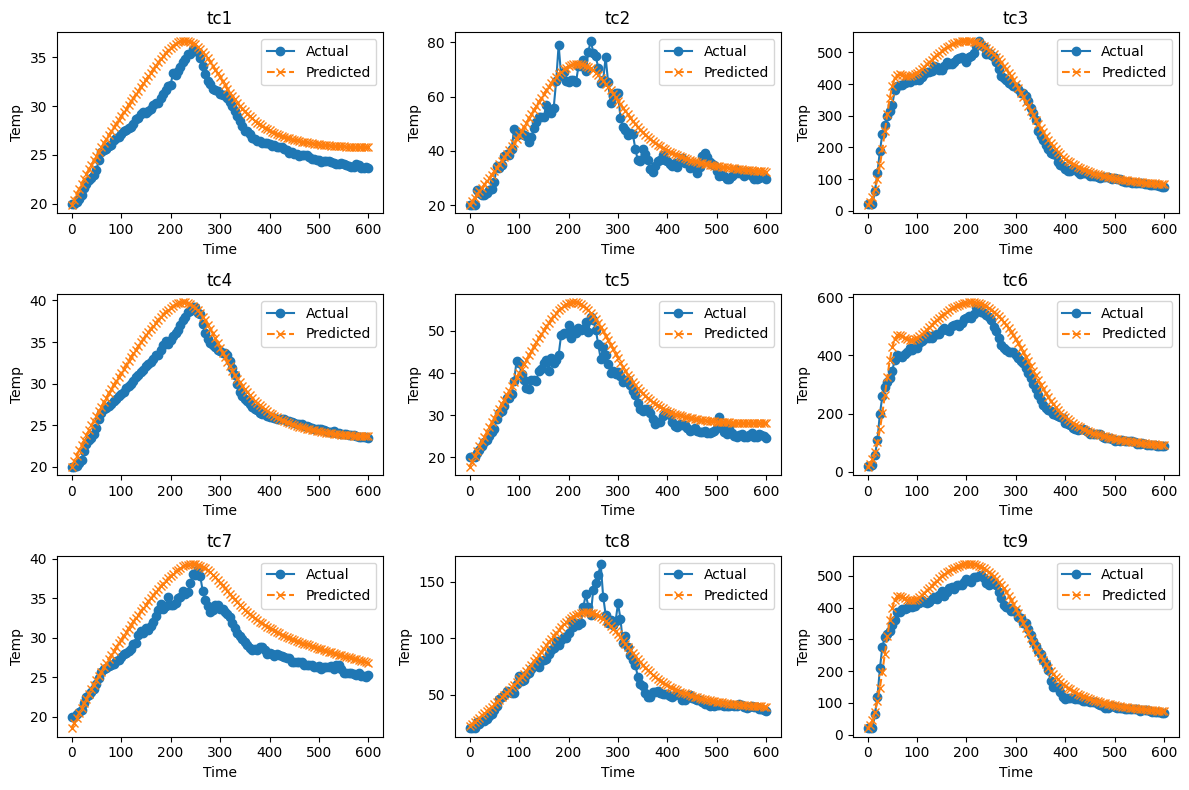

In [9]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# -----------------------
# Baseline hyperparameters
# -----------------------
lr = 0.001
layers = [3,128,128,128,1]
activation = "tanh"
epochs = 500
seed = 42
pde_weight_min = 1e-6
pde_weight_max = 0.05
pde_ramp_power = 2.0
use_log = True

torch.manual_seed(seed)
np.random.seed(seed)

# -----------------------
# Load data
# -----------------------
with open("data/devpos.json","r") as f:
    sensor_positions = json.load(f)
data = pd.read_csv("data/dfdevc.csv")
records = []
for sensor,pos in sensor_positions.items():
    x,z = pos
    for idx,row in data.iterrows():
        t = row["Time"]
        T = row[sensor]
        records.append([sensor,x,z,t,T])
df_full = pd.DataFrame(records,columns=["sensor","x","z","t","T"])

# -----------------------
# PINN
# -----------------------
class PINN(nn.Module):
    def __init__(self,layers,activation="tanh"):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i],layers[i+1]))
        self.act = nn.Tanh() if activation=="tanh" else nn.SiLU()
    def forward(self,x):
        out = x
        for layer in self.layers[:-1]:
            out = self.act(layer(out))
        return self.layers[-1](out)

# -----------------------
# PDE residual
# -----------------------
def pde_residual(model, xyz, alpha):
    xyz.requires_grad_(True)
    T_pred = model(xyz)
    grads = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred),
                                retain_graph=True, create_graph=True)[0]
    T_x = grads[:,0:1]; T_z = grads[:,1:2]; T_t = grads[:,2:3]
    T_xx = torch.autograd.grad(T_x, xyz, grad_outputs=torch.ones_like(T_x),
                               retain_graph=True, create_graph=True)[0][:,0:1]
    T_zz = torch.autograd.grad(T_z, xyz, grad_outputs=torch.ones_like(T_z),
                               retain_graph=True, create_graph=True)[0][:,1:2]
    return T_t - alpha*(T_xx + T_zz)

# -----------------------
# Prepare data
# -----------------------
def prepare_data(df,use_log=True):
    df = df.copy()
    if use_log:
        df["T_scaled"] = np.log1p(df["T"])
    else:
        df["T_scaled"] = df["T"]
    df["x_norm"] = (df["x"] - df["x"].min())/(df["x"].max()-df["x"].min())
    df["z_norm"] = (df["z"] - df["z"].min())/(df["z"].max()-df["z"].min())
    df["t_norm"] = df["t"]/df["t"].max()
    X = torch.tensor(df[["x_norm","z_norm","t_norm"]].values,dtype=torch.float32)
    T = torch.tensor(df[["T_scaled"]].values,dtype=torch.float32)
    return X,T,df

# -----------------------
# PDE weight schedule
# -----------------------
def pde_weight_schedule(epoch, epochs, wmin, wmax, power):
    frac = (epoch/epochs)**power
    return wmin + (wmax - wmin) * frac

# -----------------------
# Adaptive per-sensor weighting
# -----------------------
def get_weights(df):
    sensor_counts = df.groupby("sensor").size()
    weights = {s:1.0/len(sensor_counts) for s in sensor_counts.keys()}
    weights_tensor = torch.tensor(df["sensor"].map(weights).values,dtype=torch.float32).unsqueeze(1)
    return weights, weights_tensor

# -----------------------
# Training function
# -----------------------
def train_model(model, X, T, df, epochs, alpha, w_data, w_pde):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    running_data = 0.0
    running_pde = 0.0
    ema_decay = 0.99
    sensor_weights, weights_tensor = get_weights(df)

    log = {"epoch":[],"data_loss":[],"pde_loss":[],"total_loss":[],"mean_residual":[],"pde_weight":[]}

    for epoch in range(epochs+1):
        optimizer.zero_grad()
        T_pred = model(X)

        # Adaptive per-sensor weighting update every 100 epochs
        if epoch % 100 == 0:
            with torch.no_grad():
                df["T_pred_tmp"] = T_pred.numpy()
                for s in sensor_weights.keys():
                    s_data = df[df["sensor"]==s]
                    mse_s = ((s_data["T_scaled"]-s_data["T_pred_tmp"])**2).mean()
                    sensor_weights[s] = 0.5 + mse_s / mse_s.sum()
                total = sum(sensor_weights.values())
                sensor_weights = {k:v/total for k,v in sensor_weights.items()}
                weights_tensor = torch.tensor(df["sensor"].map(sensor_weights).values,dtype=torch.float32).unsqueeze(1)

        data_loss = torch.mean(weights_tensor*(T_pred - T)**2)
        residual = pde_residual(model, X, alpha)
        pde_weight = pde_weight_schedule(epoch, epochs, pde_weight_min, pde_weight_max, pde_ramp_power)
        pde_loss = torch.mean(residual**2) * pde_weight

        # EMA normalization
        running_data = ema_decay*running_data + (1-ema_decay)*data_loss.item()
        running_pde  = ema_decay*running_pde  + (1-ema_decay)*pde_loss.item()
        total_loss = w_data*(data_loss/(running_data+1e-12)) + w_pde*(pde_loss/(running_pde+1e-12))

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        log["epoch"].append(epoch)
        log["data_loss"].append(data_loss.item())
        log["pde_loss"].append(pde_loss.item())
        log["total_loss"].append(total_loss.item())
        log["mean_residual"].append(residual.abs().mean().item())
        log["pde_weight"].append(pde_weight)

    return model, log

# -----------------------
# Run hypertuning
# -----------------------
X,T,df = prepare_data(df_full, use_log)

# Stage A: alpha sweep
alpha_list = [1.95e-5]
alpha_logs = {}

for alpha_val in alpha_list:
    print(f"\n--- Training with alpha={alpha_val} ---")
    model = PINN(layers, activation)
    model, log = train_model(model, X, T, df, epochs, alpha_val, w_data=1.0, w_pde=1e-3)
    alpha_logs[alpha_val] = log

    # After training model for current alpha
    model.eval()
    with torch.no_grad():
        T_pred_scaled = model(X).numpy()
        if use_log:
            T_pred = np.expm1(T_pred_scaled)
        else:
            T_pred = T_pred_scaled
        df["T_pred"] = T_pred

    # Compute per-sensor RMSE
    sensor_rmse = {}
    all_errors = []
    for s in df["sensor"].unique():
        s_data = df[df["sensor"]==s]
        errors = s_data["T"] - s_data["T_pred"]
        sensor_rmse[s] = np.sqrt((errors**2).mean())
        all_errors.extend(errors.tolist())
    total_rmse = np.sqrt(np.mean(np.array(all_errors)**2))

    print(f"Alpha={alpha_val} | Total RMSE={total_rmse:.3f}")
    for s,rmse in sensor_rmse.items():
        print(f"{s}: RMSE={rmse:.3f}")

    # Plot actual vs predicted for 9 sensors
    plt.figure(figsize=(12,8))
    for i,sensor in enumerate(df["sensor"].unique()):
        x_s, z_s = sensor_positions[sensor]
        s_data = df[(df["x"]==x_s)&(df["z"]==z_s)]
        plt.subplot(3,3,i+1)
        plt.plot(s_data["t"], s_data["T"], 'o-', label="Actual")
        plt.plot(s_data["t"], s_data["T_pred"], 'x--', label="Predicted")
        plt.title(sensor)
        plt.xlabel("Time")
        plt.ylabel("Temp")
        plt.legend()
    plt.tight_layout()
    plt.show()



--- Training with time-dependent alpha ---
Total RMSE=15.131
tc1: RMSE=1.241
tc2: RMSE=4.407
tc3: RMSE=22.499
tc4: RMSE=0.888
tc5: RMSE=2.546
tc6: RMSE=25.412
tc7: RMSE=1.742
tc8: RMSE=10.407
tc9: RMSE=27.732


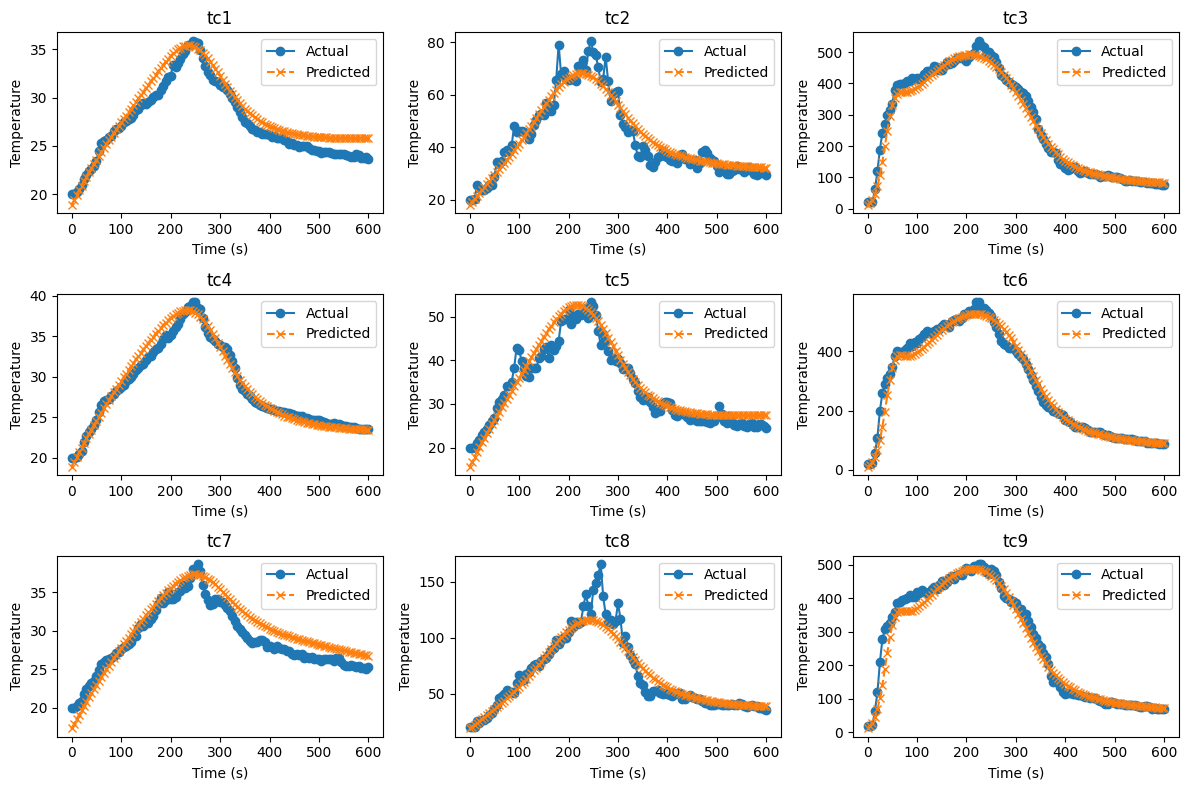

In [8]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# -----------------------
# Baseline hyperparameters
# -----------------------
lr = 0.001
layers = [3, 128, 128, 128, 1]
activation = "tanh"
epochs = 500
seed = 42
pde_weight_min = 1e-6
pde_weight_max = 0.05
pde_ramp_power = 2.0
use_log = True

torch.manual_seed(seed)
np.random.seed(seed)

# -----------------------
# Load data
# -----------------------
with open("data/devpos.json", "r") as f:
    sensor_positions = json.load(f)

data = pd.read_csv("data/dfdevc.csv")
records = []
for sensor, pos in sensor_positions.items():
    x, z = pos
    for idx, row in data.iterrows():
        t = row["Time"]
        T = row[sensor]
        records.append([sensor, x, z, t, T])
df_full = pd.DataFrame(records, columns=["sensor", "x", "z", "t", "T"])

# -----------------------
# PINN
# -----------------------
class PINN(nn.Module):
    def __init__(self, layers, activation="tanh"):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
        self.act = nn.Tanh() if activation == "tanh" else nn.SiLU()

    def forward(self, x):
        out = x
        for layer in self.layers[:-1]:
            out = self.act(layer(out))
        return self.layers[-1](out)

# -----------------------
# PDE residual with time-dependent alpha
# -----------------------
def pde_residual(model, xyz, t_max):
    xyz.requires_grad_(True)
    T_pred = model(xyz)
    grads = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred),
                                retain_graph=True, create_graph=True)[0]
    T_x = grads[:, 0:1]
    T_z = grads[:, 1:2]
    T_t = grads[:, 2:3]
    T_xx = torch.autograd.grad(T_x, xyz, grad_outputs=torch.ones_like(T_x),
                               retain_graph=True, create_graph=True)[0][:, 0:1]
    T_zz = torch.autograd.grad(T_z, xyz, grad_outputs=torch.ones_like(T_z),
                               retain_graph=True, create_graph=True)[0][:, 1:2]

    # De-normalize time
    t_norm = xyz[:, 2:3]
    t_actual = t_norm * t_max

    # Use different alpha before and after 15 seconds
    alpha_val = torch.where(t_actual <= 15.0, torch.tensor(2e-5), torch.tensor(1.9e-5))

    return T_t - alpha_val * (T_xx + T_zz)

# -----------------------
# Prepare data
# -----------------------
def prepare_data(df, use_log=True):
    df = df.copy()
    if use_log:
        df["T_scaled"] = np.log1p(df["T"])
    else:
        df["T_scaled"] = df["T"]
    df["x_norm"] = (df["x"] - df["x"].min()) / (df["x"].max() - df["x"].min())
    df["z_norm"] = (df["z"] - df["z"].min()) / (df["z"].max() - df["z"].min())
    df["t_norm"] = df["t"] / df["t"].max()
    X = torch.tensor(df[["x_norm", "z_norm", "t_norm"]].values, dtype=torch.float32)
    T = torch.tensor(df[["T_scaled"]].values, dtype=torch.float32)
    return X, T, df

# -----------------------
# PDE weight schedule
# -----------------------
def pde_weight_schedule(epoch, epochs, wmin, wmax, power):
    frac = (epoch / epochs) ** power
    return wmin + (wmax - wmin) * frac

# -----------------------
# Adaptive per-sensor weighting
# -----------------------
def get_weights(df):
    sensor_counts = df.groupby("sensor").size()
    weights = {s: 1.0 / len(sensor_counts) for s in sensor_counts.keys()}
    weights_tensor = torch.tensor(df["sensor"].map(weights).values, dtype=torch.float32).unsqueeze(1)
    return weights, weights_tensor

# -----------------------
# Training function
# -----------------------
def train_model(model, X, T, df, epochs, w_data, w_pde, t_max):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    running_data = 0.0
    running_pde = 0.0
    ema_decay = 0.99
    sensor_weights, weights_tensor = get_weights(df)

    log = {"epoch": [], "data_loss": [], "pde_loss": [], "total_loss": [], "mean_residual": [], "pde_weight": []}

    for epoch in range(epochs + 1):
        optimizer.zero_grad()
        T_pred = model(X)

        if epoch % 100 == 0:
            with torch.no_grad():
                df["T_pred_tmp"] = T_pred.numpy()
                for s in sensor_weights.keys():
                    s_data = df[df["sensor"] == s]
                    mse_s = ((s_data["T_scaled"] - s_data["T_pred_tmp"]) ** 2).mean()
                    sensor_weights[s] = 0.5 + mse_s / mse_s.sum()
                total = sum(sensor_weights.values())
                sensor_weights = {k: v / total for k, v in sensor_weights.items()}
                weights_tensor = torch.tensor(df["sensor"].map(sensor_weights).values, dtype=torch.float32).unsqueeze(1)

        data_loss = torch.mean(weights_tensor * (T_pred - T) ** 2)
        residual = pde_residual(model, X, t_max)
        pde_weight = pde_weight_schedule(epoch, epochs, pde_weight_min, pde_weight_max, pde_ramp_power)
        pde_loss = torch.mean(residual ** 2) * pde_weight

        running_data = ema_decay * running_data + (1 - ema_decay) * data_loss.item()
        running_pde = ema_decay * running_pde + (1 - ema_decay) * pde_loss.item()
        total_loss = w_data * (data_loss / (running_data + 1e-12)) + w_pde * (pde_loss / (running_pde + 1e-12))

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        log["epoch"].append(epoch)
        log["data_loss"].append(data_loss.item())
        log["pde_loss"].append(pde_loss.item())
        log["total_loss"].append(total_loss.item())
        log["mean_residual"].append(residual.abs().mean().item())
        log["pde_weight"].append(pde_weight)

    return model, log

# -----------------------
# Run
# -----------------------
X, T, df = prepare_data(df_full, use_log)
t_max = df["t"].max()

print("\n--- Training with time-dependent alpha ---")
model = PINN(layers, activation)
model, log = train_model(model, X, T, df, epochs, w_data=1.0, w_pde=1e-3, t_max=t_max)

# -----------------------
# Evaluation
# -----------------------
model.eval()
with torch.no_grad():
    T_pred_scaled = model(X).numpy()
    if use_log:
        T_pred = np.expm1(T_pred_scaled)
    else:
        T_pred = T_pred_scaled
    df["T_pred"] = T_pred

# Per-sensor RMSE
sensor_rmse = {}
all_errors = []
for s in df["sensor"].unique():
    s_data = df[df["sensor"] == s]
    errors = s_data["T"] - s_data["T_pred"]
    sensor_rmse[s] = np.sqrt((errors ** 2).mean())
    all_errors.extend(errors.tolist())
total_rmse = np.sqrt(np.mean(np.array(all_errors) ** 2))

print(f"Total RMSE={total_rmse:.3f}")
for s, rmse in sensor_rmse.items():
    print(f"{s}: RMSE={rmse:.3f}")

# Plot results
plt.figure(figsize=(12, 8))
for i, sensor in enumerate(df["sensor"].unique()[:9]):
    x_s, z_s = sensor_positions[sensor]
    s_data = df[(df["x"] == x_s) & (df["z"] == z_s)]
    plt.subplot(3, 3, i + 1)
    plt.plot(s_data["t"], s_data["T"], 'o-', label="Actual")
    plt.plot(s_data["t"], s_data["T_pred"], 'x--', label="Predicted")
    plt.title(sensor)
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature")
    plt.legend()
plt.tight_layout()
plt.show()



--- Training with w_data=1.0, w_pde=0.001 ---
RMSE=15.1313


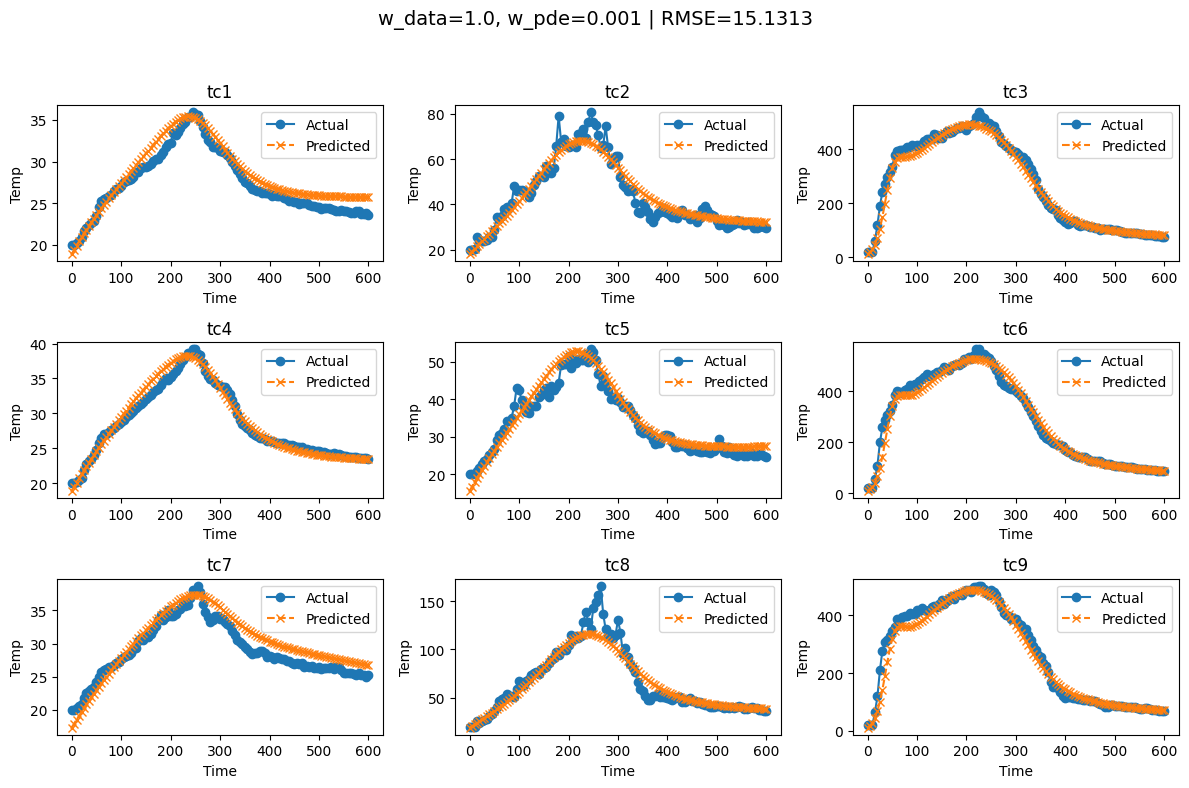


--- Training with w_data=0.9, w_pde=0.001 ---
RMSE=13.7228


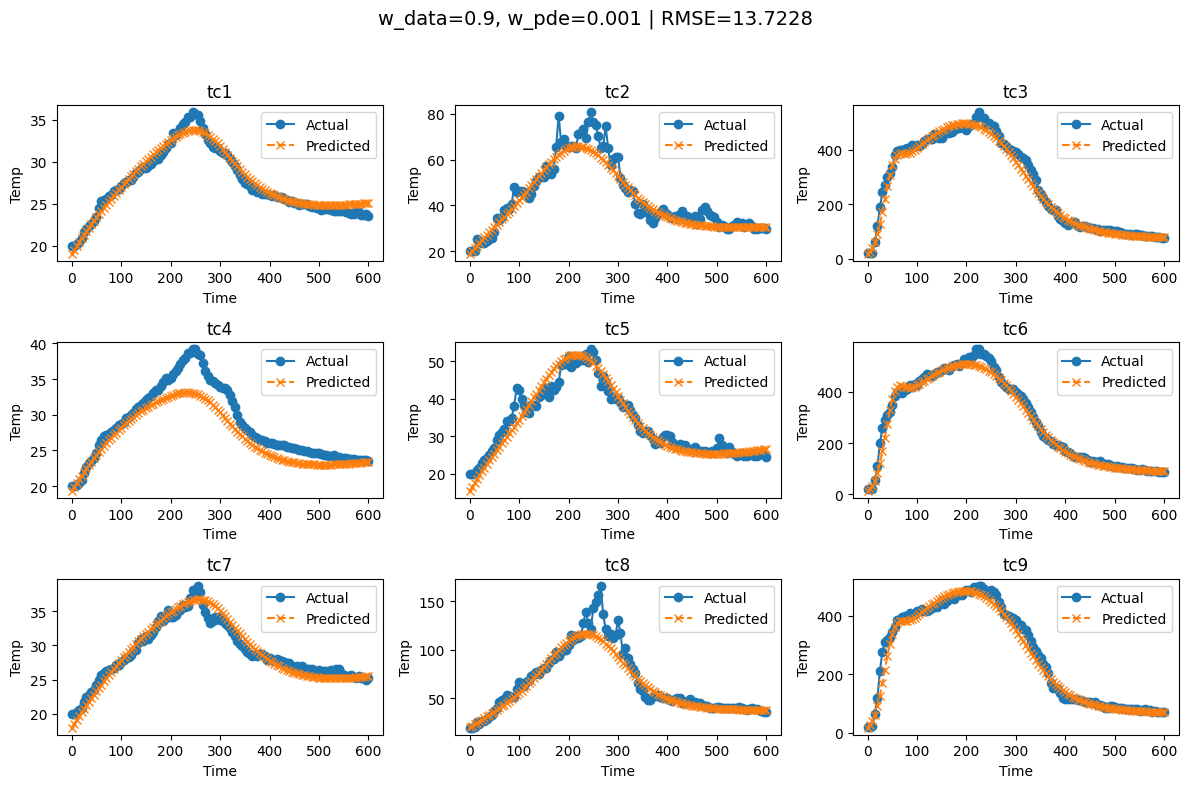


--- Training with w_data=1.1, w_pde=0.001 ---
RMSE=13.7671


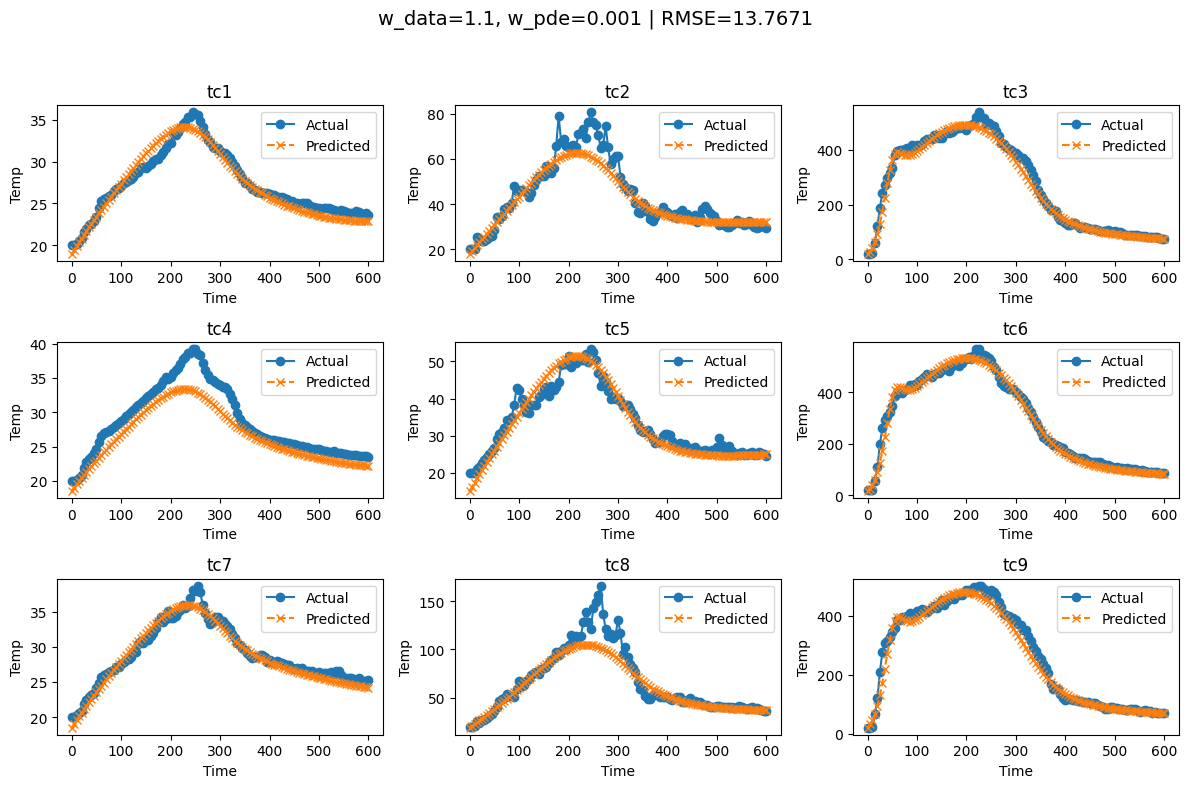


✅ Best weights found: w_data=0.9, w_pde=0.001 | RMSE=13.7228


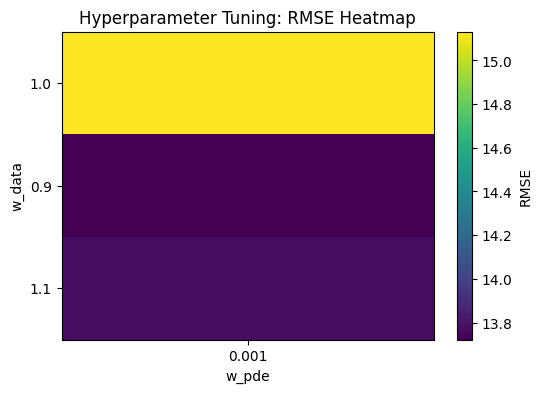

In [12]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# -----------------------
# Baseline hyperparameters
# -----------------------
lr = 0.001
layers = [3,128,128,128,1]
activation = "tanh"
epochs = 500
seed = 42
pde_weight_min = 1e-6
pde_weight_max = 0.05
pde_ramp_power = 2.0
use_log = True

torch.manual_seed(seed)
np.random.seed(seed)

# -----------------------
# Load data
# -----------------------
with open("data/devpos.json","r") as f:
    sensor_positions = json.load(f)
data = pd.read_csv("data/dfdevc.csv")

records = []
for sensor,pos in sensor_positions.items():
    x,z = pos
    for idx,row in data.iterrows():
        t = row["Time"]
        T = row[sensor]
        records.append([sensor,x,z,t,T])
df_full = pd.DataFrame(records,columns=["sensor","x","z","t","T"])

# -----------------------
# PINN
# -----------------------
class PINN(nn.Module):
    def __init__(self,layers,activation="tanh"):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i],layers[i+1]))
        self.act = nn.Tanh() if activation=="tanh" else nn.SiLU()
    def forward(self,x):
        out = x
        for layer in self.layers[:-1]:
            out = self.act(layer(out))
        return self.layers[-1](out)

# -----------------------
# PDE residual (alpha dynamic)
# -----------------------
def pde_residual(model, xyz):
    xyz.requires_grad_(True)
    T_pred = model(xyz)
    grads = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred),
                                retain_graph=True, create_graph=True)[0]
    T_x = grads[:,0:1]; T_z = grads[:,1:2]; T_t = grads[:,2:3]
    T_xx = torch.autograd.grad(T_x, xyz, grad_outputs=torch.ones_like(T_x),
                               retain_graph=True, create_graph=True)[0][:,0:1]
    T_zz = torch.autograd.grad(T_z, xyz, grad_outputs=torch.ones_like(T_z),
                               retain_graph=True, create_graph=True)[0][:,1:2]
    t_real = xyz[:,2] * t_max
    alpha = torch.where(t_real <= 15.0, torch.tensor(2e-5), torch.tensor(1.9e-5))
    alpha = alpha.unsqueeze(1)
    return T_t - alpha*(T_xx + T_zz)

# -----------------------
# Data prep
# -----------------------
def prepare_data(df,use_log=True):
    df = df.copy()
    if use_log:
        df["T_scaled"] = np.log1p(df["T"])
    else:
        df["T_scaled"] = df["T"]
    df["x_norm"] = (df["x"] - df["x"].min())/(df["x"].max()-df["x"].min())
    df["z_norm"] = (df["z"] - df["z"].min())/(df["z"].max()-df["z"].min())
    df["t_norm"] = df["t"]/df["t"].max()
    X = torch.tensor(df[["x_norm","z_norm","t_norm"]].values,dtype=torch.float32)
    T = torch.tensor(df[["T_scaled"]].values,dtype=torch.float32)
    return X,T,df

# -----------------------
# PDE weight schedule
# -----------------------
def pde_weight_schedule(epoch, epochs, wmin, wmax, power):
    frac = (epoch/epochs)**power
    return wmin + (wmax - wmin) * frac

# -----------------------
# Sensor weights
# -----------------------
def get_weights(df):
    sensor_counts = df.groupby("sensor").size()
    weights = {s:1.0/len(sensor_counts) for s in sensor_counts.keys()}
    weights_tensor = torch.tensor(df["sensor"].map(weights).values,dtype=torch.float32).unsqueeze(1)
    return weights, weights_tensor

# -----------------------
# Training function
# -----------------------
def train_model(model, X, T, df, epochs, w_data, w_pde):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    running_data = 0.0
    running_pde = 0.0
    ema_decay = 0.99
    sensor_weights, weights_tensor = get_weights(df)

    log = {"epoch":[],"data_loss":[],"pde_loss":[],"total_loss":[],"mean_residual":[],"pde_weight":[]}

    for epoch in range(epochs+1):
        optimizer.zero_grad()
        T_pred = model(X)

        if epoch % 100 == 0:
            with torch.no_grad():
                df["T_pred_tmp"] = T_pred.numpy()
                for s in sensor_weights.keys():
                    s_data = df[df["sensor"]==s]
                    mse_s = ((s_data["T_scaled"]-s_data["T_pred_tmp"])**2).mean()
                    sensor_weights[s] = 0.5 + mse_s / mse_s.sum()
                total = sum(sensor_weights.values())
                sensor_weights = {k:v/total for k,v in sensor_weights.items()}
                weights_tensor = torch.tensor(df["sensor"].map(sensor_weights).values,dtype=torch.float32).unsqueeze(1)

        data_loss = torch.mean(weights_tensor*(T_pred - T)**2)
        residual = pde_residual(model, X)
        pde_weight = pde_weight_schedule(epoch, epochs, pde_weight_min, pde_weight_max, pde_ramp_power)
        pde_loss = torch.mean(residual**2) * pde_weight

        running_data = ema_decay*running_data + (1-ema_decay)*data_loss.item()
        running_pde  = ema_decay*running_pde  + (1-ema_decay)*pde_loss.item()
        total_loss = w_data*(data_loss/(running_data+1e-12)) + w_pde*(pde_loss/(running_pde+1e-12))

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        log["epoch"].append(epoch)
        log["data_loss"].append(data_loss.item())
        log["pde_loss"].append(pde_loss.item())
        log["total_loss"].append(total_loss.item())
        log["mean_residual"].append(residual.abs().mean().item())
        log["pde_weight"].append(pde_weight)

    return model, log

# -----------------------
# Prepare data
# -----------------------
X,T,df = prepare_data(df_full, use_log)
t_max = df["t"].max()

# -----------------------
# Hyperparameter tuning
# -----------------------
w_data_list = [1.0, 0.9, 1.1]
w_pde_list  = [1e-3]

results = {}

for w_d in w_data_list:
    for w_p in w_pde_list:
        print(f"\n--- Training with w_data={w_d}, w_pde={w_p} ---")
        model = PINN(layers, activation)
        model, log = train_model(model, X, T, df, epochs, w_d, w_p)

        model.eval()
        with torch.no_grad():
            T_pred_scaled = model(X).numpy()
            T_pred = np.expm1(T_pred_scaled) if use_log else T_pred_scaled
            df["T_pred"] = T_pred

        # Compute RMSE
        errors = df["T"] - df["T_pred"]
        rmse = np.sqrt(np.mean(errors**2))
        results[(w_d, w_p)] = rmse
        print(f"RMSE={rmse:.4f}")

        # --- 9 Sensor Plot ---
        plt.figure(figsize=(12,8))
        sensors_to_plot = df["sensor"].unique()[:9]
        for i,sensor in enumerate(sensors_to_plot):
            x_s, z_s = sensor_positions[sensor]
            s_data = df[(df["x"]==x_s)&(df["z"]==z_s)]
            plt.subplot(3,3,i+1)
            plt.plot(s_data["t"], s_data["T"], 'o-', label="Actual")
            plt.plot(s_data["t"], s_data["T_pred"], 'x--', label="Predicted")
            plt.title(sensor)
            plt.xlabel("Time")
            plt.ylabel("Temp")
            plt.legend()
        plt.suptitle(f"w_data={w_d}, w_pde={w_p} | RMSE={rmse:.4f}", fontsize=14)
        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()

# -----------------------
# Find best combination
# -----------------------
best_combo = min(results, key=results.get)
print(f"\n✅ Best weights found: w_data={best_combo[0]}, w_pde={best_combo[1]} | RMSE={results[best_combo]:.4f}")

# -----------------------
# RMSE Heatmap
# -----------------------
plt.figure(figsize=(6,4))
rmse_matrix = np.array([[results[(wd,wp)] for wp in w_pde_list] for wd in w_data_list])
plt.imshow(rmse_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label='RMSE')
plt.xticks(range(len(w_pde_list)), w_pde_list)
plt.yticks(range(len(w_data_list)), w_data_list)
plt.xlabel("w_pde")
plt.ylabel("w_data")
plt.title("Hyperparameter Tuning: RMSE Heatmap")
plt.show()



🚀 Final Training Started | w_data=0.9, w_pde=0.001

✅ Final Model RMSE: 11.7980


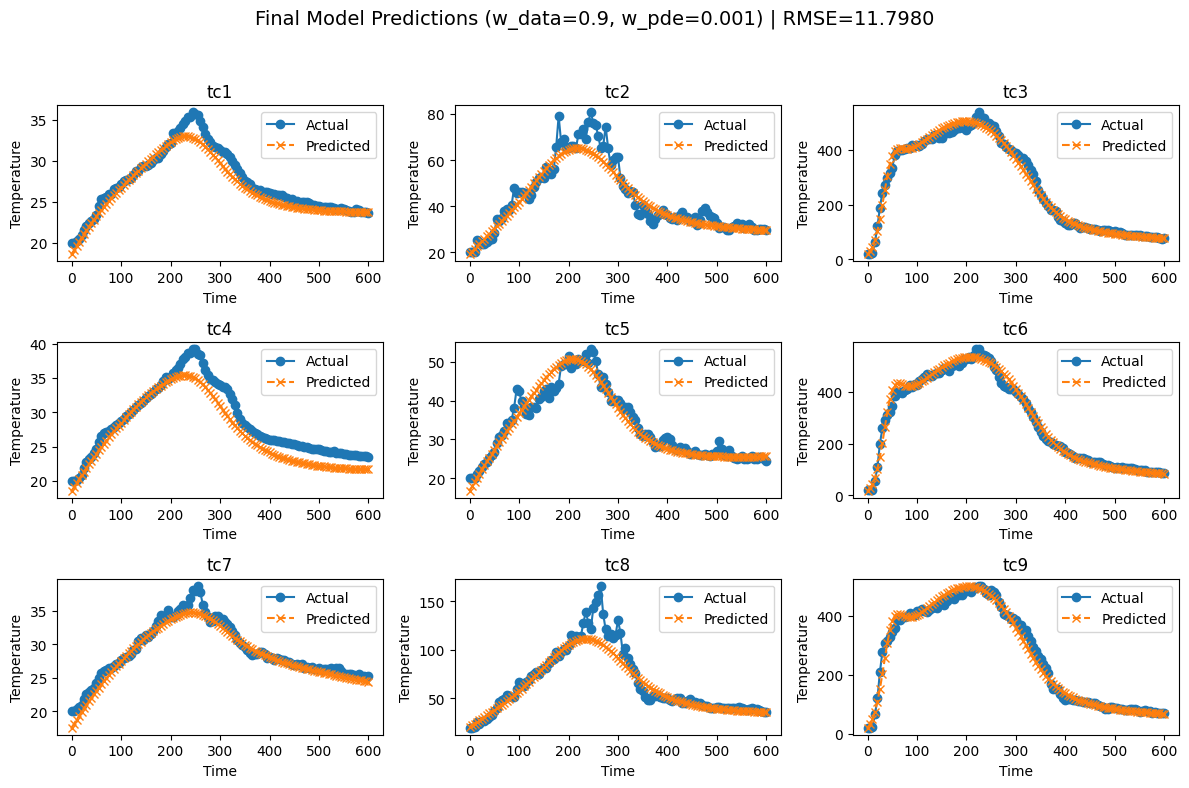

In [13]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

# -----------------------
# Baseline hyperparameters (final)
# -----------------------
lr = 0.001
layers = [3,128,128,128,1]
activation = "tanh"
epochs = 500
seed = 42
use_log = True

# Best weights (from tuning)
w_data = 0.9
w_pde  = 1e-3

# PDE schedule constants
pde_weight_min = 1e-6
pde_weight_max = 0.05
pde_ramp_power = 2.0

torch.manual_seed(seed)
np.random.seed(seed)

# -----------------------
# Load data
# -----------------------
with open("data/devpos.json","r") as f:
    sensor_positions = json.load(f)
data = pd.read_csv("data/dfdevc.csv")

records = []
for sensor,pos in sensor_positions.items():
    x,z = pos
    for _,row in data.iterrows():
        t = row["Time"]
        T = row[sensor]
        records.append([sensor,x,z,t,T])
df_full = pd.DataFrame(records,columns=["sensor","x","z","t","T"])

# -----------------------
# PINN model
# -----------------------
class PINN(nn.Module):
    def __init__(self,layers,activation="tanh"):
        super().__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i],layers[i+1]))
        self.act = nn.Tanh() if activation=="tanh" else nn.SiLU()
    def forward(self,x):
        out = x
        for layer in self.layers[:-1]:
            out = self.act(layer(out))
        return self.layers[-1](out)

# -----------------------
# PDE residual (time-dependent alpha)
# -----------------------
def pde_residual(model, xyz):
    xyz.requires_grad_(True)
    T_pred = model(xyz)
    grads = torch.autograd.grad(T_pred, xyz, grad_outputs=torch.ones_like(T_pred),
                                retain_graph=True, create_graph=True)[0]
    T_x = grads[:,0:1]; T_z = grads[:,1:2]; T_t = grads[:,2:3]
    T_xx = torch.autograd.grad(T_x, xyz, grad_outputs=torch.ones_like(T_x),
                               retain_graph=True, create_graph=True)[0][:,0:1]
    T_zz = torch.autograd.grad(T_z, xyz, grad_outputs=torch.ones_like(T_z),
                               retain_graph=True, create_graph=True)[0][:,1:2]

    # Dynamic alpha based on real time
    t_real = xyz[:,2] * t_max
    alpha = torch.where(t_real <= 15.0, torch.tensor(2e-5), torch.tensor(1.9e-5))
    alpha = alpha.unsqueeze(1)

    return T_t - alpha*(T_xx + T_zz)

# -----------------------
# Prepare data
# -----------------------
def prepare_data(df,use_log=True):
    df = df.copy()
    df["T_scaled"] = np.log1p(df["T"]) if use_log else df["T"]
    df["x_norm"] = (df["x"] - df["x"].min())/(df["x"].max()-df["x"].min())
    df["z_norm"] = (df["z"] - df["z"].min())/(df["z"].max()-df["z"].min())
    df["t_norm"] = df["t"]/df["t"].max()
    X = torch.tensor(df[["x_norm","z_norm","t_norm"]].values,dtype=torch.float32)
    T = torch.tensor(df[["T_scaled"]].values,dtype=torch.float32)
    return X,T,df

# -----------------------
# PDE weight scheduler
# -----------------------
def pde_weight_schedule(epoch, epochs, wmin, wmax, power):
    frac = (epoch/epochs)**power
    return wmin + (wmax - wmin) * frac

# -----------------------
# Sensor weights
# -----------------------
def get_weights(df):
    sensor_counts = df.groupby("sensor").size()
    weights = {s:1.0/len(sensor_counts) for s in sensor_counts.keys()}
    weights_tensor = torch.tensor(df["sensor"].map(weights).values,dtype=torch.float32).unsqueeze(1)
    return weights, weights_tensor

# -----------------------
# Training loop
# -----------------------
def train_model(model, X, T, df, epochs, w_data, w_pde):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    running_data, running_pde = 0.0, 0.0
    ema_decay = 0.99
    sensor_weights, weights_tensor = get_weights(df)

    log = {"epoch":[],"data_loss":[],"pde_loss":[],"total_loss":[],"mean_residual":[],"pde_weight":[]}

    for epoch in range(epochs+1):
        optimizer.zero_grad()
        T_pred = model(X)

        if epoch % 100 == 0:
            with torch.no_grad():
                df["T_pred_tmp"] = T_pred.numpy()
                for s in sensor_weights.keys():
                    s_data = df[df["sensor"]==s]
                    mse_s = ((s_data["T_scaled"]-s_data["T_pred_tmp"])**2).mean()
                    sensor_weights[s] = 0.5 + mse_s / mse_s.sum()
                total = sum(sensor_weights.values())
                sensor_weights = {k:v/total for k,v in sensor_weights.items()}
                weights_tensor = torch.tensor(df["sensor"].map(sensor_weights).values,dtype=torch.float32).unsqueeze(1)

        data_loss = torch.mean(weights_tensor*(T_pred - T)**2)
        residual = pde_residual(model, X)
        pde_weight = pde_weight_schedule(epoch, epochs, pde_weight_min, pde_weight_max, pde_ramp_power)
        pde_loss = torch.mean(residual**2) * pde_weight

        running_data = ema_decay*running_data + (1-ema_decay)*data_loss.item()
        running_pde  = ema_decay*running_pde  + (1-ema_decay)*pde_loss.item()
        total_loss = w_data*(data_loss/(running_data+1e-12)) + w_pde*(pde_loss/(running_pde+1e-12))

        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        log["epoch"].append(epoch)
        log["data_loss"].append(data_loss.item())
        log["pde_loss"].append(pde_loss.item())
        log["total_loss"].append(total_loss.item())
        log["mean_residual"].append(residual.abs().mean().item())
        log["pde_weight"].append(pde_weight)

    return model, log

# -----------------------
# Run final training
# -----------------------
X, T, df = prepare_data(df_full, use_log)
t_max = df["t"].max()

print(f"\n🚀 Final Training Started | w_data={w_data}, w_pde={w_pde}")
model = PINN(layers, activation)
model, log = train_model(model, X, T, df, epochs, w_data, w_pde)

# -----------------------
# Evaluate and visualize
# -----------------------
model.eval()
with torch.no_grad():
    T_pred_scaled = model(X).numpy()
    T_pred = np.expm1(T_pred_scaled) if use_log else T_pred_scaled
    df["T_pred"] = T_pred

errors = df["T"] - df["T_pred"]
rmse = np.sqrt(np.mean(errors**2))
print(f"\n✅ Final Model RMSE: {rmse:.4f}")

# --- Plot 9 sensors ---
plt.figure(figsize=(12,8))
sensors_to_plot = df["sensor"].unique()[:9]
for i,sensor in enumerate(sensors_to_plot):
    x_s, z_s = sensor_positions[sensor]
    s_data = df[(df["x"]==x_s)&(df["z"]==z_s)]
    plt.subplot(3,3,i+1)
    plt.plot(s_data["t"], s_data["T"], 'o-', label="Actual")
    plt.plot(s_data["t"], s_data["T_pred"], 'x--', label="Predicted")
    plt.title(sensor)
    plt.xlabel("Time")
    plt.ylabel("Temperature")
    plt.legend()

plt.suptitle(f"Final Model Predictions (w_data={w_data}, w_pde={w_pde}) | RMSE={rmse:.4f}", fontsize=14)
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()



🚀 Extended Training Started | 2000 epochs | w_data=0.9, w_pde=0.001


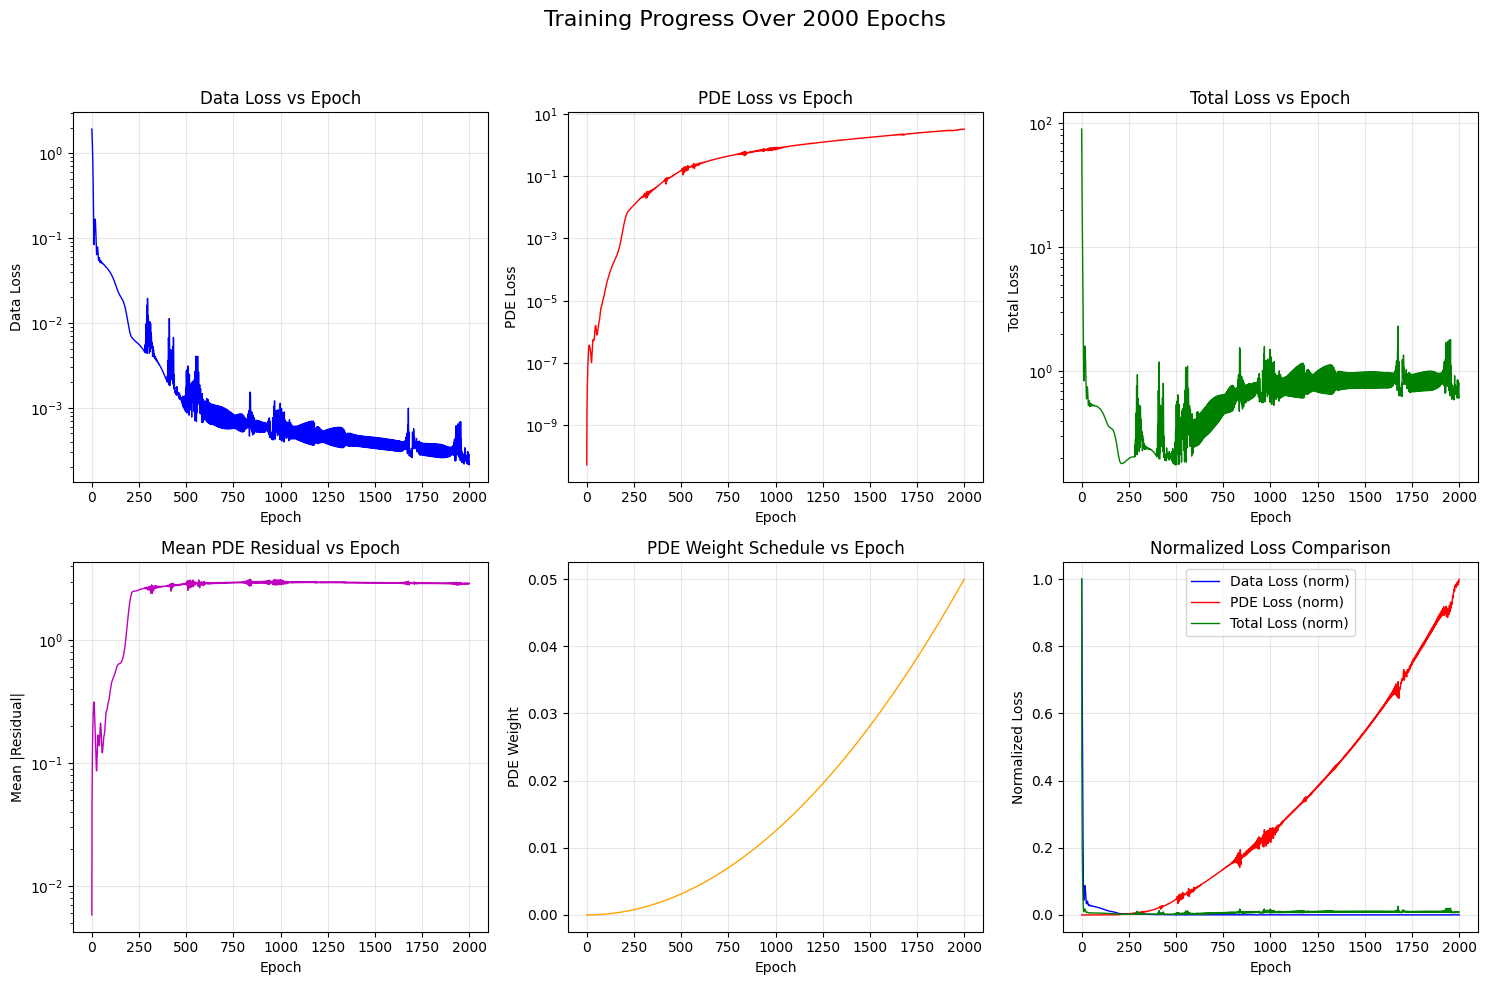


📊 Final Training Statistics:
Final Data Loss: 0.000279
Final PDE Loss: 3.238554
Final Total Loss: 0.801624
Final Mean Residual: 2.909515
Final PDE Weight: 0.050000

✅ Extended Model RMSE: 6.9018

📈 Loss Convergence Analysis:
Data Loss: Started at 1.924880, Ended at 0.000279
PDE Loss: Started at 0.000000, Ended at 3.238554
Total Loss: Started at 90.034828, Ended at 0.801624

Last 100 epochs trend:
Data Loss trend: Stable/Increasing
PDE Loss trend: Stable/Increasing
Total Loss trend: Stable/Increasing


In [14]:
# -----------------------
# Extended Training for 2000 epochs with Loss Plotting
# -----------------------

# Update epochs to 2000
epochs_extended = 2000

# Reset model and training
torch.manual_seed(seed)
np.random.seed(seed)

print(f"\n🚀 Extended Training Started | {epochs_extended} epochs | w_data={w_data}, w_pde={w_pde}")
model_extended = PINN(layers, activation)
model_extended, log_extended = train_model(model_extended, X, T, df, epochs_extended, w_data, w_pde)

# -----------------------
# Plot Loss Curves
# -----------------------
plt.figure(figsize=(15, 10))

# Plot 1: Data Loss vs Epoch
plt.subplot(2, 3, 1)
plt.plot(log_extended["epoch"], log_extended["data_loss"], 'b-', linewidth=1)
plt.title('Data Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Data Loss')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 2: PDE Loss vs Epoch
plt.subplot(2, 3, 2)
plt.plot(log_extended["epoch"], log_extended["pde_loss"], 'r-', linewidth=1)
plt.title('PDE Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('PDE Loss')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 3: Total Loss vs Epoch
plt.subplot(2, 3, 3)
plt.plot(log_extended["epoch"], log_extended["total_loss"], 'g-', linewidth=1)
plt.title('Total Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 4: Mean Residual vs Epoch
plt.subplot(2, 3, 4)
plt.plot(log_extended["epoch"], log_extended["mean_residual"], 'm-', linewidth=1)
plt.title('Mean PDE Residual vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Mean |Residual|')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Plot 5: PDE Weight Schedule vs Epoch
plt.subplot(2, 3, 5)
plt.plot(log_extended["epoch"], log_extended["pde_weight"], 'orange', linewidth=1)
plt.title('PDE Weight Schedule vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('PDE Weight')
plt.grid(True, alpha=0.3)

# Plot 6: All Losses Together (normalized)
plt.subplot(2, 3, 6)
# Normalize losses for comparison
data_loss_norm = np.array(log_extended["data_loss"]) / np.max(log_extended["data_loss"])
pde_loss_norm = np.array(log_extended["pde_loss"]) / np.max(log_extended["pde_loss"])
total_loss_norm = np.array(log_extended["total_loss"]) / np.max(log_extended["total_loss"])

plt.plot(log_extended["epoch"], data_loss_norm, 'b-', label='Data Loss (norm)', linewidth=1)
plt.plot(log_extended["epoch"], pde_loss_norm, 'r-', label='PDE Loss (norm)', linewidth=1)
plt.plot(log_extended["epoch"], total_loss_norm, 'g-', label='Total Loss (norm)', linewidth=1)
plt.title('Normalized Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.suptitle(f'Training Progress Over {epochs_extended} Epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# -----------------------
# Print Final Statistics
# -----------------------
print(f"\n📊 Final Training Statistics:")
print(f"Final Data Loss: {log_extended['data_loss'][-1]:.6f}")
print(f"Final PDE Loss: {log_extended['pde_loss'][-1]:.6f}")
print(f"Final Total Loss: {log_extended['total_loss'][-1]:.6f}")
print(f"Final Mean Residual: {log_extended['mean_residual'][-1]:.6f}")
print(f"Final PDE Weight: {log_extended['pde_weight'][-1]:.6f}")

# -----------------------
# Evaluate Extended Model
# -----------------------
model_extended.eval()
with torch.no_grad():
    T_pred_scaled_ext = model_extended(X).numpy()
    T_pred_ext = np.expm1(T_pred_scaled_ext) if use_log else T_pred_scaled_ext
    df["T_pred_ext"] = T_pred_ext

errors_ext = df["T"] - df["T_pred_ext"]
rmse_ext = np.sqrt(np.mean(errors_ext**2))
print(f"\n✅ Extended Model RMSE: {rmse_ext:.4f}")

# -----------------------
# Loss Convergence Analysis
# -----------------------
print(f"\n📈 Loss Convergence Analysis:")
print(f"Data Loss: Started at {log_extended['data_loss'][0]:.6f}, Ended at {log_extended['data_loss'][-1]:.6f}")
print(f"PDE Loss: Started at {log_extended['pde_loss'][0]:.6f}, Ended at {log_extended['pde_loss'][-1]:.6f}")
print(f"Total Loss: Started at {log_extended['total_loss'][0]:.6f}, Ended at {log_extended['total_loss'][-1]:.6f}")

# Check if losses are still decreasing
last_100_data = log_extended['data_loss'][-100:]
last_100_pde = log_extended['pde_loss'][-100:]
last_100_total = log_extended['total_loss'][-100:]

print(f"\nLast 100 epochs trend:")
print(f"Data Loss trend: {'Decreasing' if np.mean(np.diff(last_100_data)) < 0 else 'Stable/Increasing'}")
print(f"PDE Loss trend: {'Decreasing' if np.mean(np.diff(last_100_pde)) < 0 else 'Stable/Increasing'}")
print(f"Total Loss trend: {'Decreasing' if np.mean(np.diff(last_100_total)) < 0 else 'Stable/Increasing'}")